In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim=1, unbiased=False, keepdim=True).sqrt()
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.g + self.b

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))

class DsConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride = 1, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias=bias),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)
## 디코더
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out


In [3]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from functools import partial
from einops import rearrange
from math import sqrt

def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth

class EfficientSelfAttention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        heads,
        reduction_ratio
    ):
        super().__init__()
        self.scale = (dim // heads) ** -0.5
        self.heads = heads

        self.to_q = nn.Conv2d(dim, dim, 1, bias = False)
        self.to_kv = nn.Conv2d(dim, dim * 2, reduction_ratio, stride = reduction_ratio, bias = False)
        self.to_out = nn.Conv2d(dim, dim, 1, bias = False)

    def forward(self, x):
        h, w = x.shape[-2:]
        heads = self.heads

        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h = heads), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) c -> b (h c) x y', h = heads, x = h, y = w)
        return self.to_out(out)

class MixFeedForward(nn.Module):
    def __init__(
        self,
        *,
        dim,
        expansion_factor
    ):
        super().__init__()
        hidden_dim = dim * expansion_factor
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1),
            DsConv2d(hidden_dim, hidden_dim, 3, padding = 1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1)
        )

    def forward(self, x):
        return self.net(x)

## 컨볼루션 임베딩
class Embedding(nn.Module):
    def __init__(self, dim_in,dim_out, kernel_size, stride, padding):
        super(Embedding, self).__init__()
        self.embedding = nn.Conv2d(dim_in, 
                                   dim_out, 
                                   kernel_size=kernel_size, 
                                   stride=stride, 
                                   padding=padding)
        
    def forward(self, x):
        return self.embedding(x)
    
'''
5. MiT (Mixer Transformer)
이미지를 여러 스테이지로 처리합니다. 각 스테이지는 이미지를 패치로 나누고, 패치를 임베딩한 후, 여러 개의 Transformer 레이어를 적용합니다.
이 과정은 이미지의 다양한 해상도에서 특징을 추출합니다. 
'''    
class MiT(nn.Module):
    def __init__(
        self,
        *,
        channels,
        dims,
        heads,
        ff_expansion,
        reduction_ratio,
        num_layers,
        stage_kernel_stride_pad = ((7, 4, 3),  
                                   (3, 2, 1), 
                                   (3, 2, 1), 
                                   (3, 2, 1))
    ):
        super().__init__()


        dims = (channels, *dims)
        dim_pairs = list(zip(dims[:-1], dims[1:]))

        self.stages = nn.ModuleList([])

        for (dim_in, dim_out), (kernel, stride, padding), num_layers, ff_expansion, heads, reduction_ratio in zip(
            dim_pairs, stage_kernel_stride_pad, num_layers, ff_expansion, heads, reduction_ratio):
            #여기서 너비와 높이가 같은 정사각형 패치를 사용합니다.
            get_overlap_patches = nn.Unfold(kernel, stride = stride, padding = padding)
            overlap_patch_embed = nn.Conv2d(dim_in * kernel ** 2, dim_out, 1)

            layers = nn.ModuleList([])

            for _ in range(num_layers):
                layers.append(nn.ModuleList([
                    PreNorm(dim_out, EfficientSelfAttention(dim = dim_out, heads = heads, reduction_ratio = reduction_ratio)),
                    PreNorm(dim_out, MixFeedForward(dim = dim_out, expansion_factor = ff_expansion)),
                ]))

            self.stages.append(nn.ModuleList([
                get_overlap_patches,
                overlap_patch_embed,
                layers
            ]))

    def forward(
        self,
        x,
        return_layer_outputs = False
    ):
        h, w = x.shape[-2:]
        
        
        layer_outputs = []
        for (get_overlap_patches, overlap_embed, layers) in self.stages:
            x = get_overlap_patches(x)
            
            num_patches = x.shape[-1]
            ratio = int(sqrt((h * w) / num_patches))
            
            x = rearrange(x, 'b c (h w) -> b c h w', h = h // ratio)

            x = overlap_embed(x)
            for (attn, ff) in layers:
                x = attn(x) + x
                x = ff(x) + x

            layer_outputs.append(x)

        ret = x if not return_layer_outputs else layer_outputs
        return ret
    
class Head(nn.Module):
    def __init__(self, input_dim = 256 ,dim=128, num_classes=11):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_dim , (input_dim//3)*2, kernel_size=1),  
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Conv2d((input_dim//3)*2 , input_dim//3, kernel_size=1),  
            nn.Conv2d(dim, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        return self.layers(x)

'''
6. Segformer
MiT를 통해 추출된 여러 스케일의 특징을 결합하고, 최종적으로 세그멘테이션 맵을 생성합니다.
각 스테이지의 출력을 디코더 차원으로 매핑하고, 업샘플링하여 동일한 해상도로 만든 후, 이를 결합합니다.
결합된 특징 맵을 사용하여 최종 세그멘테이션 맵을 생성합니다.
'''
class ARC_Net(nn.Module):
    def __init__(
        self,
        *,
        dims=(32, 64, 160, 256),
        heads=(1, 2, 5, 8),
        ff_expansion=(8, 8, 4, 4),
        reduction_ratio=(8, 4, 2, 1),
        num_layers=2,
        channels=11,
        num_classes=11,
        kernel_stride_paddings = ((1, 1, 0),(3, 2, 1), (3, 2, 1), (3, 2, 1))
    ):
        super().__init__()
        self.channels = channels
        decoder_dim = dims[-1]
        
        dims, heads, ff_expansion, reduction_ratio, num_layers = map(
            partial(cast_tuple, depth=len(kernel_stride_paddings)), (dims, heads, ff_expansion, reduction_ratio, num_layers))

        
        self.mit = MiT(
            channels=channels,
            dims=dims,
            heads=heads,
            ff_expansion=ff_expansion,
            reduction_ratio=reduction_ratio,
            num_layers=num_layers,
            stage_kernel_stride_pad=kernel_stride_paddings
        )

        self.to_fused = nn.ModuleList([nn.Sequential(
            nn.Conv2d(dim, decoder_dim, 1),
            nn.Upsample(scale_factor=2 ** i)
        ) for i, dim in enumerate(dims)])

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.1)
        
        self.cbam = CBAM(gate_channels = decoder_dim * (len(kernel_stride_paddings)-1) * 2)  
        
        self.cbam2 = CBAM(gate_channels = decoder_dim * (len(kernel_stride_paddings)-1) * 2)
        
        self.reduce = nn.Conv2d(decoder_dim * (len(kernel_stride_paddings)-1) * 2, decoder_dim * (len(kernel_stride_paddings)-1), 1)        
        
        self.to_segmentation = Head(decoder_dim*(len(kernel_stride_paddings)-1)* 3, decoder_dim*(len(kernel_stride_paddings)-1) , num_classes)
        
    def _fusion(self, x):
        x = self.mit(x, return_layer_outputs=True)
        # 드랍아웃 
        x = [self.gelu(x) for x in x]
        x = [self.dropout(x) for x in x]
        fused = []
        for output, to_fused in zip(x[1:], self.to_fused[1:]):
            x = to_fused(output)  # Conv2d 적용
            # 업샘플링하여 공간 크기를 맞춥니다.
            fused.append(x)
        fused = torch.cat(fused, dim=1)
        
        return fused    
    
    def forward(self, x, ex_inputs, ex_outputs):
        x = self._fusion(x) # [b,1,H,W] -> [b,dim_0,H,W],...,[b,dim_n, H//(n+1), W//(n+1)] 
                            # -> [b,dim_n, H, W],...,[b,dim_n, H, W] -> [b, dim_n * 2, H, W]
                            # [b, 256, 32, 32]
                            
        # 예제 입력과 출력을 채널 차원으로 분할
        n_examples = ex_inputs.size(1)//self.channels  # n_examples * channels (여기서는 3)
        
        # 예제 수만큼 반복하면서 예제 입력과 출력을 처리
        fused = []
        for i in range(n_examples):
            ex_i = ex_inputs[:, i*self.channels:(i+1)*self.channels, :, :]  # [batch_size, 1, H, W]
            ex_o = ex_outputs[:, i*self.channels:(i+1)*self.channels, :, :]  # [batch_size, 1, H, W]
            
            ex_i = self._fusion(ex_i)
            ex_o = self._fusion(ex_o)
            
            ex_f = torch.cat([ex_i, ex_o], dim=1)
            ex_f = self.cbam(ex_f)
            ex_f = self.reduce(ex_f)
            fused.append(ex_f)
        
        for i, ex_f in enumerate(fused):
            ex_f = torch.cat([x, ex_f], dim=1)
            ex_f = self.cbam2(ex_f)
            ex_f = self.reduce(ex_f)
            fused[i] = ex_f
        
        fused = torch.cat(fused, dim=1)
        output = self.to_segmentation(fused)
        
        return output

In [4]:
# 모델 생성 및 출력
model_args = {
    'dims': (32, 64, 128,256),
    'heads': 4,
    'ff_expansion': 4,
    'reduction_ratio': (4,2,2,2),
    'num_layers': (1,2,3,4),
    'channels': 11,
    'num_classes': 11,
    'kernel_stride_paddings': ((3, 1, 1),(3, 2, 1),(3, 2, 1),(3, 2, 1))
    }

In [5]:
# dims, heads, ff_expansion, reduction_ratio, num_layers = map(
#             partial(cast_tuple, depth=4), (model_args['dims'], 
#                                            model_args['heads'], 
#                                            model_args['ff_expansion'], 
#                                            model_args['reduction_ratio'], 
#                                            model_args['num_layers']))
# mit = MiT(
#         dims=dims,
#         heads=heads,
#         ff_expansion=ff_expansion,
#         reduction_ratio=reduction_ratio,
#         num_layers=num_layers,
#         channels=model_args['channels'],
#         stage_kernel_stride_pad=model_args['kernel_stride_paddings'],
        
#           )
# x = torch.randn(10, 1, 30, 30)

# print("Input shape:", x.shape)
# x = mit(x,return_layer_outputs = True)

# print("Output shape:", x[0].shape)
# print("Output shape:", x[1].shape)

In [6]:
# tensor = torch.randn(10, 1, 30, 30)
# i = 0
# h = tensor[:, i:i+11, :, :]
# h.shape

In [7]:
# fuse = [torch.randn(10, 256, 32, 32), torch.randn(10, 256, 32, 32), torch.randn(10, 256, 32, 32)]

# x= torch.randn(10, 256, 32, 32)
# for i , ex in enumerate(fuse) :
#     print("fuse shape:", ex.shape)
#     ex = torch.cat([ex, x], dim=1)
#     print("fuse shape:", ex.shape)
#     fuse[i] = ex
#     print("fuse shape:", fuse[i].shape)
#     print("==================")

In [8]:
# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
print(f'Using {device} device')
model = ARC_Net(**model_args).to(device)
# 입력 텐서 생성
x = torch.randn(10, 11, 32, 32).to(device)
e_i, e_o = torch.randn(10, 33, 32, 32).to(device), torch.randn(10, 33, 32, 32).to(device)
print(model(x,e_i,e_o).shape)

Using cuda device
torch.Size([10, 11, 32, 32])


In [9]:
from thop import profile
from thop import clever_format

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
print(f'Using {device} device')
outer_model = ARC_Net(**model_args).to(device)

from torchinfo import summary

summary(outer_model, input_size=((1, 11, 32, 32), (1, 33, 32, 32), (1, 33, 32, 32)))

Using cuda device


Layer (type:depth-idx)                                                 Output Shape              Param #
ARC_Net                                                                [1, 11, 32, 32]           8,448
├─MiT: 1-1                                                             [1, 32, 32, 32]           --
│    └─ModuleList: 2-29                                                --                        (recursive)
│    │    └─ModuleList: 3-69                                           --                        (recursive)
│    │    └─ModuleList: 3-70                                           --                        (recursive)
│    │    └─ModuleList: 3-71                                           --                        (recursive)
│    │    └─ModuleList: 3-72                                           --                        (recursive)
├─GELU: 1-2                                                            [1, 32, 32, 32]           --
├─GELU: 1-3                                    

In [10]:
# tensor = torch.zeros(1, 30, 30)
# tensor = F.one_hot(tensor.long(), num_classes=11)
# print(tensor.shape)
# tensor = tensor.permute(0, 3, 1, 2)
# print(tensor.shape)
# tensor = tensor.squeeze(0)    
# print(tensor.shape)
# print(tensor.dtype)
# tensor = tensor.to(torch.float32)  # 수정된 부분
# print(tensor.dtype)
# tensor.shape


In [11]:
import numpy as np
import os
import torch.optim as optim
from torch import nn
from copy import deepcopy
import json
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import random
from itertools import combinations

def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data
import random
from itertools import combinations

def one_hot_encoding(tensor):
    tensor = F.one_hot(tensor.long(), num_classes=11)
    tensor = tensor.permute(0, 3, 1, 2)
    tensor = tensor.squeeze(0)
    # 여기서 명시적으로 dtype을 float32로 설정합니다
    tensor = tensor.to(torch.float32)  # 수정된 부분
    return tensor


class ARC_Dataset(Dataset):
    def __init__(self, challenges, solution, task_data_num=1, example_data_num=3, max_combinations=10):
        challenges = load_json(challenges)
        solution = load_json(solution)
        self.data = []
        self.task_data_num = task_data_num
        self.example_data_num = example_data_num
        self.max_combinations = max_combinations

        for key, value in challenges.items():
            for i in range(len(value['test'])):
                task_input = value['test'][i]['input']
                task_output = solution[key][i]
                example_list = value['train'].copy()

                n_examples = len(example_list)  # 원래 예제의 개수

                # 예제 수가 example_data_num보다 적으면 현재 작업의 예제를 복제하여 채움
                if n_examples < self.example_data_num:
                    while len(example_list) < self.example_data_num:
                        example_list.append(random.choice(example_list))

                    # 조합은 예제 리스트 자체로 설정
                    ex_combinations = [tuple(example_list)]
                else:
                    # 예제의 조합 생성
                    ex_combinations = list(combinations(example_list, self.example_data_num))

                    # 조합의 수를 제한
                    if len(ex_combinations) > self.max_combinations:
                        ex_combinations = random.sample(ex_combinations, self.max_combinations)

                for ex_combo in ex_combinations:
                    ex_input = [ex['input'] for ex in ex_combo]
                    ex_output = [ex['output'] for ex in ex_combo]

                    # 데이터에 추가하면서 원래 예제의 개수도 포함
                    self.data.append({
                        'id': key,
                        'input': task_input,
                        'output': task_output,
                        'ex_input': ex_input,
                        'ex_output': ex_output,
                        'num_original_examples': n_examples  # 원래 예제 개수 추가
                    })

        # 리스트를 데이터프레임으로 변환
        self.df = pd.DataFrame(self.data)
        
    def __len__(self):
        return len(self.df)
    
    def pad_to_32x32(self, tensor):
        if tensor.dim() == 2:
            tensor = tensor.unsqueeze(0)
        c, h, w = tensor.shape
        pad_h = max(0, 32 - h)
        pad_w = max(0, 32 - w)
        
        # 좌우 및 상하 패딩을 반반씩 나눠서 적용
        padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
        tensor = F.pad(tensor, padding, mode='constant', value=0)
        
        return tensor

    def mapping_input(self, tensor):
        mapping = {
            1: random.randint(1, 10),
            2: random.randint(11, 20),
            3: random.randint(21, 30),
            4: random.randint(31, 40),
            5: random.randint(41, 50),
            6: random.randint(51, 60),
            7: random.randint(61, 70),
            8: random.randint(71, 80),
            9: random.randint(81, 90),
            10: random.randint(91, 100)
        }
        temp_tensor = tensor.clone()
        for k in mapping:
            temp_tensor[temp_tensor == k] = -k  # 임시로 기존 값에 음수를 취해 중복을 피함

        # 최종 매핑 적용
        for k, v in mapping.items():
            temp_tensor[temp_tensor == -k] = v
        return temp_tensor

    def __getitem__(self, idx):
        task = self.df.iloc[idx]
        
        # task_input과 task_output 변환 및 패딩 추가
        task_input = self.pad_to_32x32((torch.tensor(task['input'], dtype=torch.float32) + 1)) # [1, 32, 32]
        task_output = self.pad_to_32x32((torch.tensor(task['output'], dtype=torch.float32) + 1)) # [1, 32, 32]
        task_input = one_hot_encoding(task_input)
        
        # 입력 채널 차원 추가
        if task_input.dim() == 2:
            task_input = task_input.unsqueeze(0)  # [1, H, W]
        if task_output.dim() == 2:
            task_output = task_output.unsqueeze(0)  # [1, H, W]
        
        # 예제 입력과 출력 변환 및 패딩 추가
        example_input = []
        example_output = []
        for ex_in, ex_out in zip(task['ex_input'], task['ex_output']):
            ex_in_tensor = self.pad_to_32x32(torch.tensor(ex_in, dtype=torch.float32) + 1)
            ex_out_tensor = self.pad_to_32x32(torch.tensor(ex_out, dtype=torch.float32) + 1)
            ex_in_tensor = one_hot_encoding(ex_in_tensor)
            ex_out_tensor = one_hot_encoding(ex_out_tensor)
            
            # 입력 채널 차원 추가
            if ex_in_tensor.dim() == 2:
                ex_in_tensor = ex_in_tensor.unsqueeze(0)  # [1, H, W]
            if ex_out_tensor.dim() == 2:
                ex_out_tensor = ex_out_tensor.unsqueeze(0)  # [1, H, W]
            
            example_input.append(ex_in_tensor)
            example_output.append(ex_out_tensor)
        
        # 예제 입력과 출력을 채널 차원으로 결합
        ex_inputs = torch.cat(example_input, dim=0)  # [n_examples * channels, H, W]
        ex_outputs = torch.cat(example_output, dim=0)  # [n_examples * channels, H, W]
        
        return task_input, task_output, ex_inputs, ex_outputs

# 사용 예제
train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

ti, to, ei, eo = next(iter(train_loader))
print(ti.shape, to.shape, ei.shape, eo.shape)
print(ti.dtype, to.dtype, ei.dtype, eo.dtype)

torch.Size([10, 11, 32, 32]) torch.Size([10, 1, 32, 32]) torch.Size([10, 33, 32, 32]) torch.Size([10, 33, 32, 32])
torch.float32 torch.float32 torch.float32 torch.float32


In [12]:
# 배치별로 처리되는 정확도 계산 함수 (ignore_index 없이)
def calculate_accuracy(predictions, targets):
    # 예측값을 argmax로 [batch_size, H, W] 형태로 변환
    pred_classes = predictions.argmax(dim=1).long()  # [batch_size, H, W]
    
    # 타겟 값을 [batch_size, H, W]로 변환 (필요 시 squeeze)
    targets = targets.squeeze(1)  # [batch_size, H, W]

    # 픽셀 단위로 맞은 부분 계산
    correct_pixels = (pred_classes == targets)  # [batch_size, H, W]
    
    # 맞은 픽셀 수 계산
    correct_pixel_count = correct_pixels.sum().item()  # 맞은 픽셀 수
    total_pixel_count = targets.numel()  # 전체 픽셀 수

    # 각 이미지별로 모든 픽셀이 맞는지 확인
    correct_images = correct_pixels.view(targets.size(0), -1).all(dim=1)  # 각 이미지별로 모든 픽셀이 맞는지 확인
    correct_image_count = correct_images.sum().item()  # 맞은 이미지 수
    total_image_count = targets.size(0)  # 전체 이미지 수
    
    return correct_image_count, total_image_count, correct_pixel_count, total_pixel_count

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import wandb

def visualize_predictions(inputs, targets, predictions, condition=False):
    if condition:
        # 입력 이미지와 예측 결과를 CPU로 이동
        inputs = inputs.cpu().numpy()
        targets = targets.cpu().numpy()
        predictions = predictions.detach().cpu().numpy()  # detach()로 그래디언트 추적 중단

        # 시각화할 샘플의 수 (최대 3개의 샘플)
        num_images = min(3, inputs.shape[0])

        # 컬러 맵 정의 (0~10 값을 위한 11개의 색상)
        color_list = ['black', 'blue', 'red', 'green', 'yellow', 'purple', 
                      'orange', 'pink', 'gray', 'brown', 'cyan']
        cmap = ListedColormap(color_list)

        # 시각화를 위한 플롯 생성 (각 줄에 입력, 타겟, 예측 이미지를 표시)
        fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))

        for i in range(num_images):
            # 입력 이미지 처리
            input_image = inputs.argmax(axis=1)[i]  # shape: (H, W)
            if input_image.ndim == 3 and input_image.shape[0] == 1:
                input_image = input_image.squeeze(0)  # 단일 채널 이미지 (H, W)

            # 타겟 이미지 처리
            target_image = targets[i].squeeze(0)  # shape: (H, W)
            target_image = target_image.astype(int)

            # 예측 이미지 처리
            prediction_image = predictions.argmax(axis=1)[i]  # shape: (H, W)
            prediction_image = prediction_image.astype(int)

            # 입력 이미지 표시
            axes[i, 0].imshow(input_image, cmap=cmap, vmin=0, vmax=10)
            axes[i, 0].set_title(f'Input Image {i+1}')
            axes[i, 0].axis('off')

            # 타겟 이미지 표시
            axes[i, 1].imshow(target_image, cmap=cmap, vmin=0, vmax=10)
            axes[i, 1].set_title(f'Ground Truth {i+1}')
            axes[i, 1].axis('off')

            # 예측 이미지 표시
            axes[i, 2].imshow(prediction_image, cmap=cmap, vmin=0, vmax=10)
            axes[i, 2].set_title(f'Prediction {i+1}')
            axes[i, 2].axis('off')

        plt.tight_layout()  # 레이아웃을 자동으로 조정
        
        # WandB에 이미지 업로드
        wandb.log({"Predictions": wandb.Image(plt)})
        
        # 범례를 플롯 내에 표시
        patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[j], markersize=10, label=str(j)) for j in range(11)]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

        plt.show()




In [13]:
# 예시 테스트 코드
batch_size = 4
height = 32
width = 32
num_classes = 11  # 11개의 클래스를 가정
ignore_index = 0
# 임의의 예측값 생성 (logits 형태로, [batch_size, num_classes, H, W]의 크기)
predictions = torch.randn(batch_size, num_classes, height, width)
print(predictions.shape, predictions.dtype)
predictions = predictions.argmax(dim=1)

print(predictions.shape, predictions.dtype)
print("============")
# 임의의 타겟값 생성 (정수값으로, [batch_size, 1, H, W]의 크기)
targets = torch.randint(0, num_classes, (batch_size, 1, height, width))
targets = targets.squeeze(1)  # [batch_size, H, W]
print(targets.shape, targets.dtype)

if ignore_index is not None:
    mask = (targets != ignore_index)
else:
    mask = torch.ones_like(targets, dtype=torch.bool)
    
# 첫 번째와 두 번째 샘플의 예측값을 타겟값과 완전히 동일하게 설정
predictions[0] = targets[0]
# predictions[1] = targets[1]

# 배치별로 완전히 동일한 행렬 확인
correct_samples = (predictions == targets).all(dim=(1, 2)).sum().item()
total_samples = targets.size(0)

# 정확도 계산
correct_pixels = (predictions == targets).sum().item()
total_pixels = targets.numel()

print(f'Correct samples: {correct_samples}/{total_samples}')
print(f'Correct pixels: {correct_pixels}/{total_pixels}')

torch.Size([4, 11, 32, 32]) torch.float32
torch.Size([4, 32, 32]) torch.int64
torch.Size([4, 32, 32]) torch.int64
Correct samples: 1/4
Correct pixels: 1303/4096


In [14]:
# 예시 테스트 코드
batch_size = 4
height = 32
width = 32
num_classes = 11  # 11개의 클래스를 가정

# 임의의 예측값 생성 (logits 형태로, [batch_size, num_classes, H, W]의 크기)
predictions = torch.randn(batch_size, num_classes, height, width)
print(predictions.shape, predictions.dtype)

# 임의의 타겟값 생성 (정수값으로, [batch_size, 1, H, W]의 크기)
targets = torch.randint(0, num_classes, (batch_size, 1, height, width))
print(targets.shape, targets.dtype)
# 첫 번째와 두 번째 샘플의 예측값을 타겟값과 완전히 동일하게 설정
for i in range(2):  # 첫 번째와 두 번째 샘플을 타겟과 맞춤
    predictions[i] = torch.zeros_like(predictions[i])  # logits을 0으로 초기화
    for c in range(num_classes):
        predictions[i, c] = (targets[i].squeeze(0) == c).float() * 1000.0  # 타겟과 동일하게 맞춤

# 정확도 계산 함수 호출
correct_samples, total_samples, correct_pixels, total_pixels = calculate_accuracy(predictions, targets)

# 결과 출력
print(f"이미지 단위 정확도: {correct_samples}/{total_samples}")
print(f"픽셀 단위 정확도: {correct_pixels}/{total_pixels}")


torch.Size([4, 11, 32, 32]) torch.float32
torch.Size([4, 1, 32, 32]) torch.int64
이미지 단위 정확도: 2/4
픽셀 단위 정확도: 2251/4096


In [15]:
# import torch

# # 배치별로 처리되는 정확도 계산 함수 (앞서 작성한 함수)
# def calculate_accuracy(predictions, targets, ignore_index=0):
#     pred_classes = predictions.argmax(dim=1).long()  # [batch_size, H, W]
#     targets = targets.squeeze(1)  # [batch_size, H, W]
    
#     if ignore_index is not None:
#         mask = (targets != ignore_index)
#     else:
#         mask = torch.ones_like(targets, dtype=torch.bool)
    
#     correct_pixels = (pred_classes == targets) & mask  # [batch_size, H, W]
#     correct_pixel_count = correct_pixels.sum().item()  # 맞은 픽셀 수
#     total_pixel_count = mask.sum().item()  # 유효한 전체 픽셀 수
    
#     correct_images = correct_pixels.view(targets.size(0), -1).all(dim=1)  # 각 이미지별로 모든 픽셀이 맞는지 확인
#     correct_image_count = correct_images.sum().item()  # 맞은 이미지 수
#     total_image_count = targets.size(0)  # 전체 이미지 수
    
#     return correct_image_count, total_image_count, correct_pixel_count, total_pixel_count

# # 누적된 정확도를 계산하고 테스트하는 함수
# def test_batch_accuracy():
#     batch_size = 4
#     height = 32
#     width = 32
#     num_classes = 11
#     num_batches = 3  # 3개의 배치 처리 가정

#     total_correct_samples = 0
#     total_samples = 0
#     total_correct_pixels = 0
#     total_pixels = 0

#     for batch_idx in range(num_batches):
#         # 예측값과 타겟값 생성 (여기서는 간단하게 무작위로 생성)
#         predictions = torch.randn(batch_size, num_classes, height, width)
#         targets = torch.randint(0, num_classes, (batch_size, 1, height, width))

#         # 첫 번째 배치는 완전히 정확하게 설정
#         if batch_idx == 0:
#             for i in range(batch_size):
#                 predictions[i] = torch.zeros_like(predictions[i])
#                 for c in range(num_classes):
#                     predictions[i, c] = (targets[i].squeeze(0) == c).float() * 1000.0

#         # 두 번째 배치는 절반만 정확하게 설정
#         elif batch_idx == 1:
#             for i in range(batch_size // 2):  # 첫 번째 절반만 정확하게
#                 predictions[i] = torch.zeros_like(predictions[i])
#                 for c in range(num_classes):
#                     predictions[i, c] = (targets[i].squeeze(0) == c).float() * 1000.0
        
#         # 세 번째 배치는 전부 틀리게 설정
#         else:
#             predictions = torch.zeros_like(predictions)
#             targets = torch.ones(batch_size, 1, height, width).long() * (num_classes - 1)

#         # 배치별 정확도 계산
#         correct_samples, batch_total_samples, correct_pixels, batch_total_pixels = calculate_accuracy(predictions, targets, ignore_index=None)
        
#         # 누적 정확도 계산
#         total_correct_samples += correct_samples
#         total_samples += batch_total_samples
#         total_correct_pixels += correct_pixels
#         total_pixels += batch_total_pixels

#     # 전체 배치에서 누적된 정확도 계산
#     avg_sample_accuracy = 100. * float(total_correct_samples) / float(total_samples)
#     avg_pixel_accuracy = 100. * float(total_correct_pixels) / float(total_pixels)

#     print(f"전체 이미지 단위 정확도: {avg_sample_accuracy:.2f}%")
#     print(f"전체 픽셀 단위 정확도: {avg_pixel_accuracy:.2f}%")

# # 테스트 함수 실행
# test_batch_accuracy()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: woow070840 (waooang). Use `wandb login --relogin` to force relogin


Using cuda device


Epoch [1/1000] Complete | Average Loss: 2.068373 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 5.61%


Test Average Loss: 1.905705 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 8.34%


Epoch [2/1000] Complete | Average Loss: 1.896166 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 5.97%


Test Average Loss: 1.939534 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 9.71%


Epoch [3/1000] Complete | Average Loss: 1.838776 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 42.51%


Test Average Loss: 1.926223 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 8.34%


Epoch [4/1000] Complete | Average Loss: 1.740725 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 59.63%


Test Average Loss: 1.842780 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 31.62%


Epoch [5/1000] Complete | Average Loss: 1.646943 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 68.51%


Test Average Loss: 1.732518 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 45.53%


Epoch [6/1000] Complete | Average Loss: 1.556377 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 73.62%


Test Average Loss: 1.716246 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 53.17%


Epoch [7/1000] Complete | Average Loss: 1.470382 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 77.48%


Test Average Loss: 1.616329 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 82.54%


Epoch [8/1000] Complete | Average Loss: 1.453871 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 81.34%


Test Average Loss: 1.658809 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 83.20%


Epoch [9/1000] Complete | Average Loss: 1.467679 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 73.96%


Test Average Loss: 1.653331 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 78.61%


Epoch [10/1000] Complete | Average Loss: 1.381395 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 80.65%


Test Average Loss: 1.629472 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 63.11%


Epoch [11/1000] Complete | Average Loss: 1.330053 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 83.51%


Test Average Loss: 1.551080 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 81.00%


Epoch [12/1000] Complete | Average Loss: 1.292100 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 82.27%


Test Average Loss: 1.611704 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 80.41%


Epoch [13/1000] Complete | Average Loss: 1.248541 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 84.19%


Test Average Loss: 1.587797 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 81.29%


Epoch [14/1000] Complete | Average Loss: 1.239652 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 85.92%


Test Average Loss: 1.639777 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 83.59%


Epoch [15/1000] Complete | Average Loss: 1.177715 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 84.83%


Test Average Loss: 1.553334 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 81.48%


Epoch [16/1000] Complete | Average Loss: 1.146195 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 87.58%


Test Average Loss: 1.624929 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 85.56%


Epoch [17/1000] Complete | Average Loss: 1.100487 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 88.94%


Test Average Loss: 1.638086 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 83.28%


Epoch [18/1000] Complete | Average Loss: 1.084021 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 89.41%


Test Average Loss: 1.589562 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 79.88%


Epoch [19/1000] Complete | Average Loss: 1.086087 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 88.17%


Test Average Loss: 1.610700 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 81.20%


Epoch [20/1000] Complete | Average Loss: 1.016859 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 89.53%


Test Average Loss: 1.666710 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 86.21%


Epoch [21/1000] Complete | Average Loss: 0.987646 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 90.41%


Test Average Loss: 1.542593 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 82.86%


Epoch [22/1000] Complete | Average Loss: 0.977586 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 90.06%


Test Average Loss: 1.678417 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 84.51%


Epoch [23/1000] Complete | Average Loss: 0.939280 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 91.26%


Test Average Loss: 1.630434 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 83.79%


Epoch [24/1000] Complete | Average Loss: 0.927021 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 88.20%


Test Average Loss: 1.633697 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 86.04%


Epoch [25/1000] Complete | Average Loss: 0.906623 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 91.09%


Test Average Loss: 1.592158 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 84.93%


Epoch [26/1000] Complete | Average Loss: 0.878778 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 91.41%


Test Average Loss: 1.595614 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 85.45%


Epoch [27/1000] Complete | Average Loss: 0.850260 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 91.68%


Test Average Loss: 1.660843 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 85.63%


Epoch [28/1000] Complete | Average Loss: 0.829737 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 91.27%


Test Average Loss: 1.634124 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 86.16%


Epoch [29/1000] Complete | Average Loss: 0.803857 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 91.83%


Test Average Loss: 1.632624 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 85.66%


Epoch [30/1000] Complete | Average Loss: 0.797278 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 92.33%


Test Average Loss: 1.903968 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 86.59%


Epoch [31/1000] Complete | Average Loss: 0.801042 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 92.00%


Test Average Loss: 1.773038 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 86.44%


Epoch [32/1000] Complete | Average Loss: 0.761016 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 92.52%


Test Average Loss: 1.768347 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.39%


Epoch [33/1000] Complete | Average Loss: 0.732006 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 92.44%


Test Average Loss: 1.887718 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.80%


Epoch [34/1000] Complete | Average Loss: 0.730316 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 92.50%


Test Average Loss: 1.754148 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 86.47%


Epoch [35/1000] Complete | Average Loss: 0.712630 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 92.31%


Test Average Loss: 1.815759 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.98%


Epoch [36/1000] Complete | Average Loss: 0.703101 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 92.11%


Test Average Loss: 1.697570 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 84.70%


Epoch [37/1000] Complete | Average Loss: 0.704308 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 92.36%


Test Average Loss: 1.869828 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 86.42%


Epoch [38/1000] Complete | Average Loss: 0.677520 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 92.95%


Test Average Loss: 1.730779 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 85.98%


Epoch [39/1000] Complete | Average Loss: 0.646269 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 93.07%


Test Average Loss: 1.843380 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 86.70%


Epoch [40/1000] Complete | Average Loss: 0.638812 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 93.20%


Test Average Loss: 1.811635 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.01%


Epoch [41/1000] Complete | Average Loss: 0.626824 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 93.21%


Test Average Loss: 1.725280 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.52%


Epoch [42/1000] Complete | Average Loss: 0.628576 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 93.52%


Test Average Loss: 1.791450 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 86.88%


Epoch [43/1000] Complete | Average Loss: 0.602644 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 92.91%


Test Average Loss: 1.862999 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.19%


Epoch [44/1000] Complete | Average Loss: 0.583120 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 93.66%


Test Average Loss: 1.865130 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.74%


Epoch [45/1000] Complete | Average Loss: 0.576862 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 93.79%


Test Average Loss: 1.969205 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.72%


Epoch [46/1000] Complete | Average Loss: 0.595290 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 93.65%


Test Average Loss: 1.918551 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.64%


Epoch [47/1000] Complete | Average Loss: 0.584971 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 93.42%


Test Average Loss: 2.079858 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.34%


Epoch [48/1000] Complete | Average Loss: 0.572694 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 93.75%


Test Average Loss: 1.989416 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.90%


Epoch [49/1000] Complete | Average Loss: 0.551077 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 93.80%


Test Average Loss: 2.102516 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.99%


Epoch [50/1000] Complete | Average Loss: 0.534242 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 93.86%


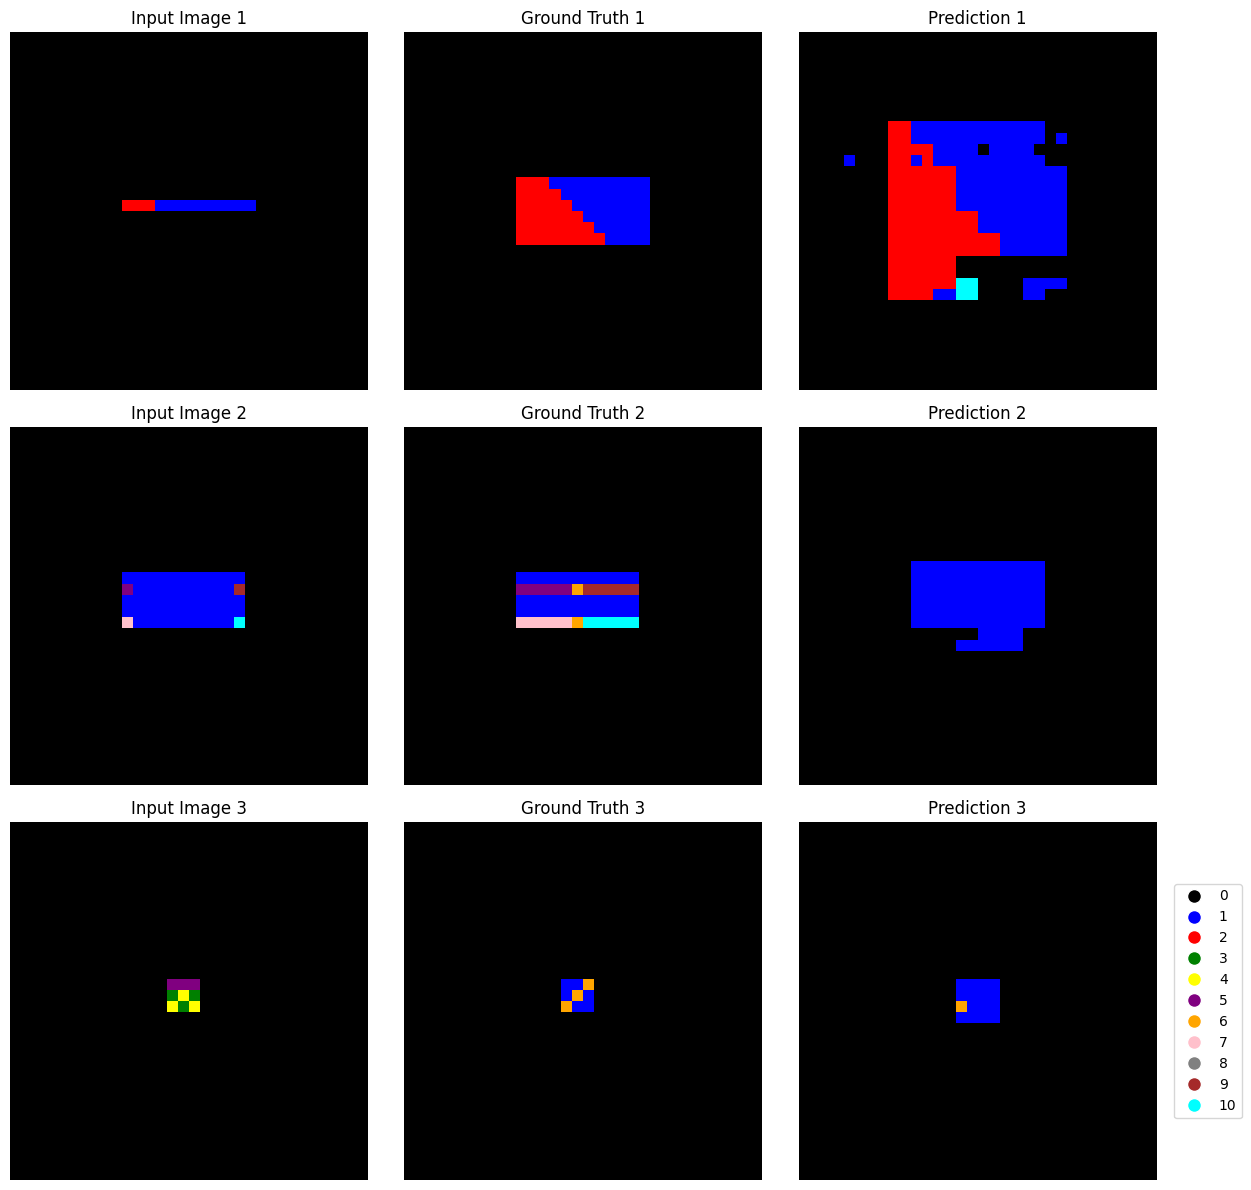

Test Average Loss: 2.041719 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.82%


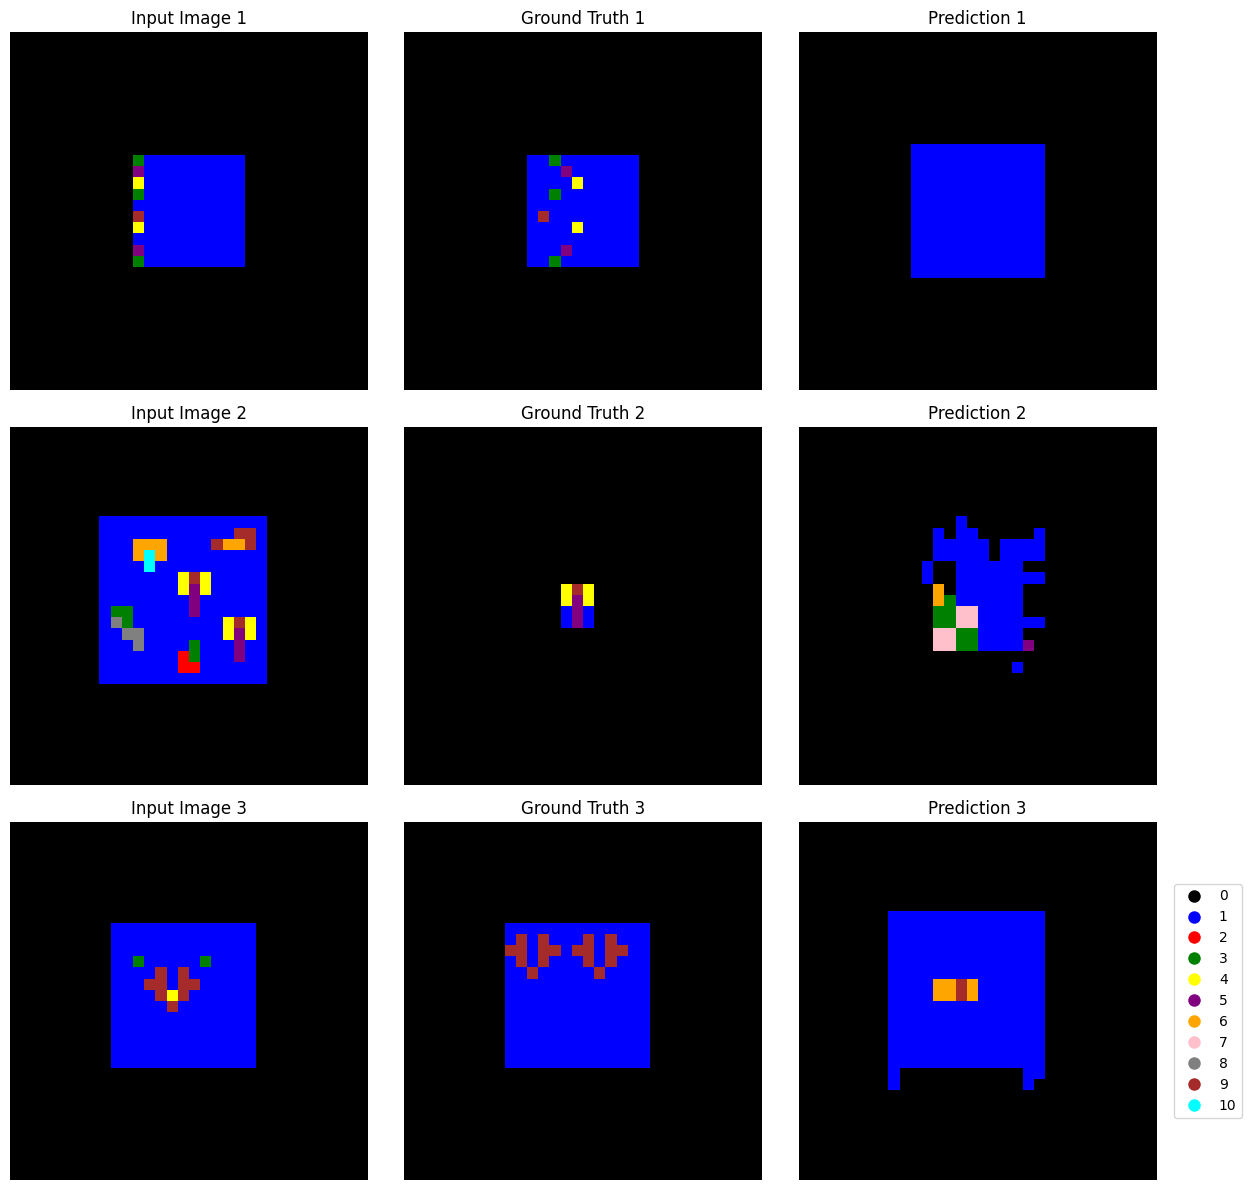

Epoch [51/1000] Complete | Average Loss: 0.522533 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.22%


Test Average Loss: 1.936399 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.53%


Epoch [52/1000] Complete | Average Loss: 0.523759 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.08%


Test Average Loss: 2.196475 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.72%


Epoch [53/1000] Complete | Average Loss: 0.507819 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 94.17%


Test Average Loss: 2.122803 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.14%


Epoch [54/1000] Complete | Average Loss: 0.497942 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.33%


Test Average Loss: 2.165817 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.51%


Epoch [55/1000] Complete | Average Loss: 0.498936 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.49%


Test Average Loss: 2.000960 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.73%


Epoch [56/1000] Complete | Average Loss: 0.503758 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.38%


Test Average Loss: 2.273605 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.26%


Epoch [57/1000] Complete | Average Loss: 0.491625 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.43%


Test Average Loss: 2.148978 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.33%


Epoch [58/1000] Complete | Average Loss: 0.468910 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.65%


Test Average Loss: 2.379780 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.54%


Epoch [59/1000] Complete | Average Loss: 0.482472 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.50%


Test Average Loss: 2.167085 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.44%


Epoch [60/1000] Complete | Average Loss: 0.479606 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.53%


Test Average Loss: 2.355392 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.71%


Epoch [61/1000] Complete | Average Loss: 0.463383 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 94.73%


Test Average Loss: 2.315363 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.55%


Epoch [62/1000] Complete | Average Loss: 0.456301 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.77%


Test Average Loss: 2.300946 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.32%


Epoch [63/1000] Complete | Average Loss: 0.442606 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.83%


Test Average Loss: 2.347376 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.70%


Epoch [64/1000] Complete | Average Loss: 0.429849 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 94.98%


Test Average Loss: 2.458249 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.35%


Epoch [65/1000] Complete | Average Loss: 0.414229 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.16%


Test Average Loss: 2.373833 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.32%


Epoch [66/1000] Complete | Average Loss: 0.432894 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.09%


Test Average Loss: 2.466833 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.47%


Epoch [67/1000] Complete | Average Loss: 0.437780 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 94.78%


Test Average Loss: 2.611167 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.87%


Epoch [68/1000] Complete | Average Loss: 0.420754 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.18%


Test Average Loss: 2.594286 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.54%


Epoch [69/1000] Complete | Average Loss: 0.411088 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.20%


Test Average Loss: 2.680232 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.61%


Epoch [70/1000] Complete | Average Loss: 0.402190 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.16%


Test Average Loss: 2.434329 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.14%


Epoch [71/1000] Complete | Average Loss: 0.403629 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.25%


Test Average Loss: 2.782347 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.90%


Epoch [72/1000] Complete | Average Loss: 0.401498 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.01%


Test Average Loss: 2.645926 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.23%


Epoch [73/1000] Complete | Average Loss: 0.398371 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 94.97%


Test Average Loss: 2.678429 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.77%


Epoch [74/1000] Complete | Average Loss: 0.398286 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.12%


Test Average Loss: 2.734609 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.79%


Epoch [75/1000] Complete | Average Loss: 0.388095 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.37%


Test Average Loss: 2.616111 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.56%


Epoch [76/1000] Complete | Average Loss: 0.379802 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.45%


Test Average Loss: 2.743632 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.57%


Epoch [77/1000] Complete | Average Loss: 0.391434 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.46%


Test Average Loss: 2.499736 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.56%


Epoch [78/1000] Complete | Average Loss: 0.375522 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 95.40%


Test Average Loss: 3.113554 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.81%


Epoch [79/1000] Complete | Average Loss: 0.378194 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.38%


Test Average Loss: 2.613691 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.79%


Epoch [80/1000] Complete | Average Loss: 0.375709 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.43%


Test Average Loss: 2.923590 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.85%


Epoch [81/1000] Complete | Average Loss: 0.360159 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.47%


Test Average Loss: 2.911466 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.90%


Epoch [82/1000] Complete | Average Loss: 0.354383 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.66%


Test Average Loss: 2.961352 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.96%


Epoch [83/1000] Complete | Average Loss: 0.349414 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.66%


Test Average Loss: 2.932761 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.64%


Epoch [84/1000] Complete | Average Loss: 0.341262 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.73%


Test Average Loss: 2.851350 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.58%


Epoch [85/1000] Complete | Average Loss: 0.338353 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.69%


Test Average Loss: 3.211611 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.87%


Epoch [86/1000] Complete | Average Loss: 0.328432 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.83%


Test Average Loss: 2.900220 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.89%


Epoch [87/1000] Complete | Average Loss: 0.316861 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.85%


Test Average Loss: 2.943327 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.00%


Epoch [88/1000] Complete | Average Loss: 0.316458 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.86%


Test Average Loss: 2.703037 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.82%


Epoch [89/1000] Complete | Average Loss: 0.319145 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.81%


Test Average Loss: 2.863610 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.50%


Epoch [90/1000] Complete | Average Loss: 0.326754 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.83%


Test Average Loss: 2.840214 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.40%


Epoch [91/1000] Complete | Average Loss: 0.330824 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 95.79%


Test Average Loss: 3.294307 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.20%


Epoch [92/1000] Complete | Average Loss: 0.310046 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.87%


Test Average Loss: 2.820564 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.07%


Epoch [93/1000] Complete | Average Loss: 0.311166 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.82%


Test Average Loss: 2.694822 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.63%


Epoch [94/1000] Complete | Average Loss: 0.309084 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 95.90%


Test Average Loss: 2.816163 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.56%


Epoch [95/1000] Complete | Average Loss: 0.301325 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 95.94%


Test Average Loss: 3.062380 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.87%


Epoch [96/1000] Complete | Average Loss: 0.286993 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.10%


Test Average Loss: 3.338714 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.23%


Epoch [97/1000] Complete | Average Loss: 0.285283 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.19%


Test Average Loss: 3.101283 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.40%


Epoch [98/1000] Complete | Average Loss: 0.283333 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.02%


Test Average Loss: 3.178675 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.90%


Epoch [99/1000] Complete | Average Loss: 0.302024 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.03%


Test Average Loss: 2.886068 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.58%


Epoch [100/1000] Complete | Average Loss: 0.293745 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.08%


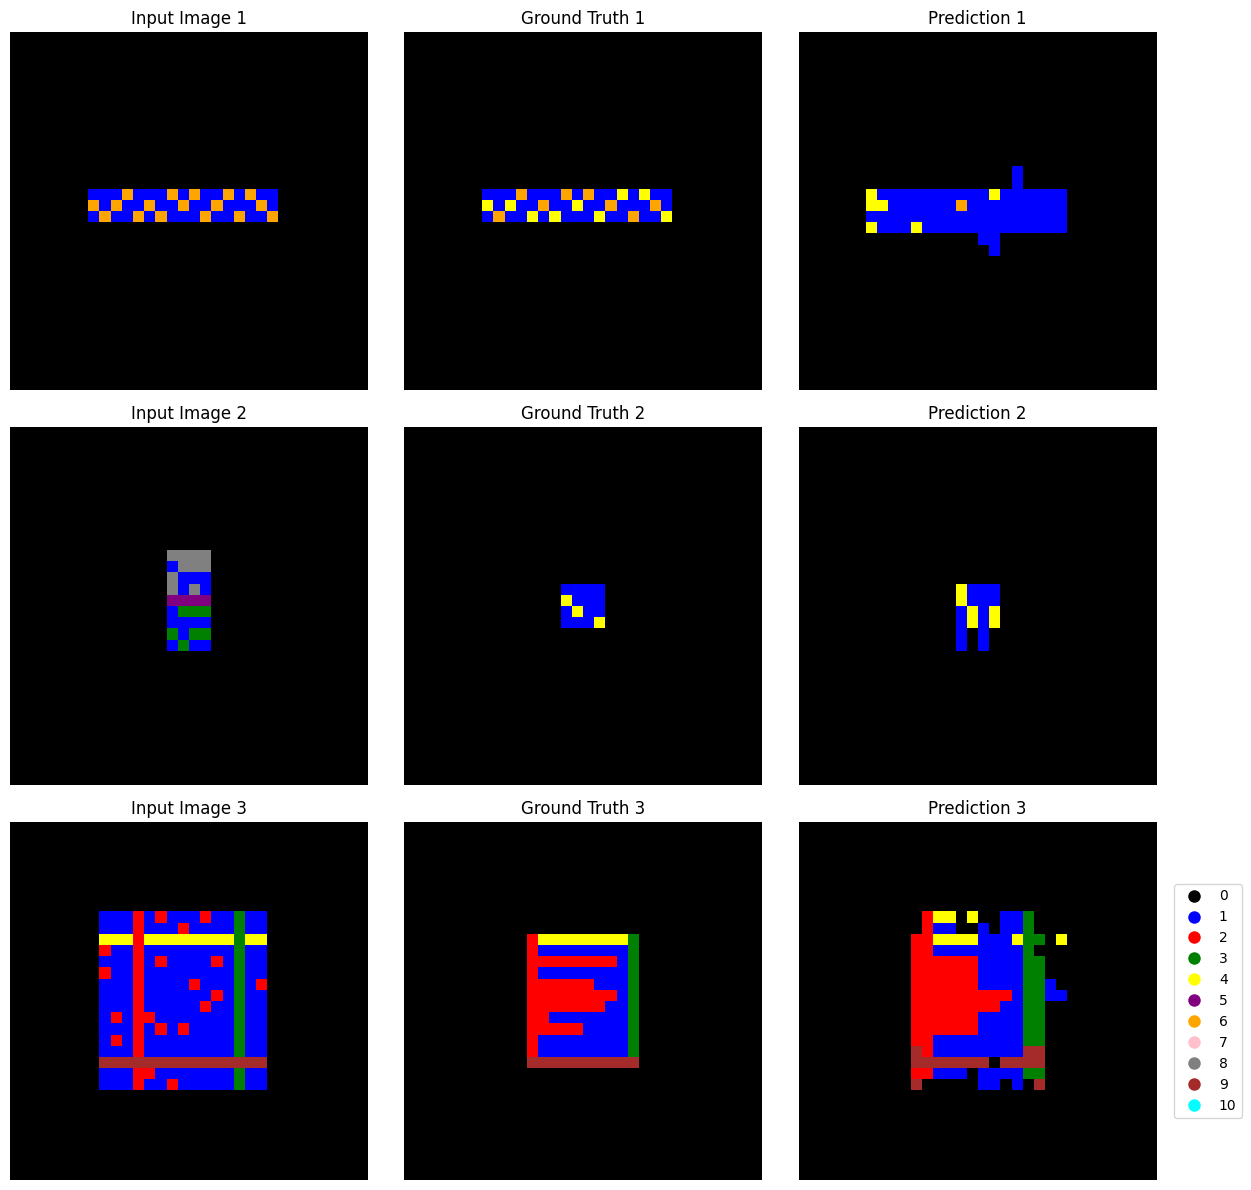

Test Average Loss: 3.050113 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.14%


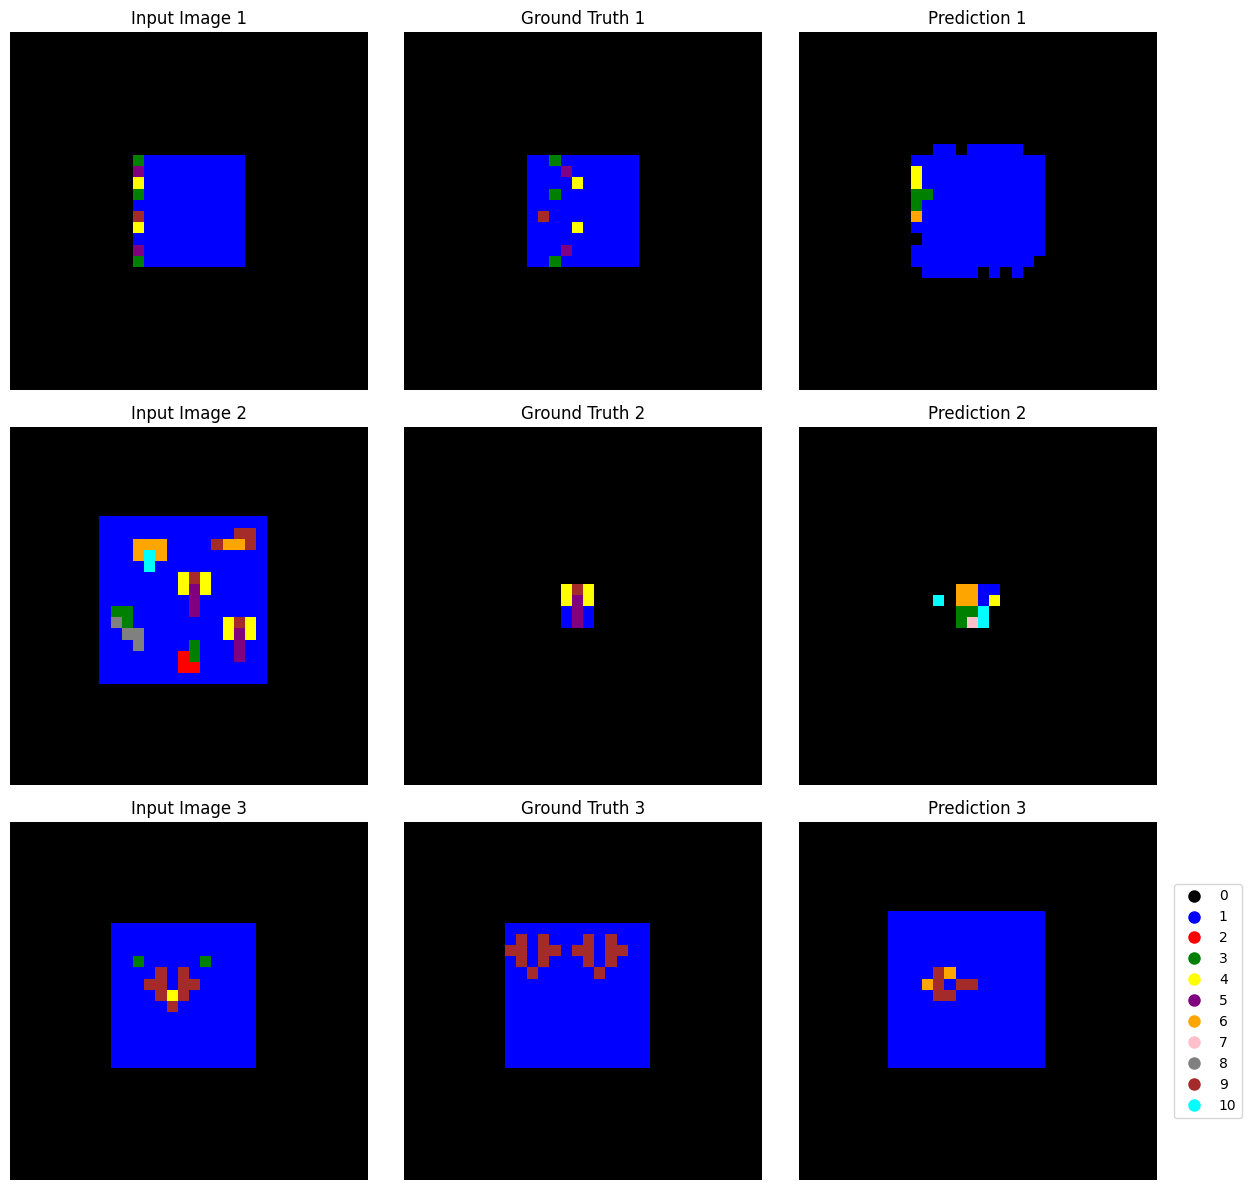

Epoch [101/1000] Complete | Average Loss: 0.275578 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.07%


Test Average Loss: 3.093057 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.90%


Epoch [102/1000] Complete | Average Loss: 0.270411 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.19%


Test Average Loss: 3.021830 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.65%


Epoch [103/1000] Complete | Average Loss: 0.263228 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.25%


Test Average Loss: 3.118122 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.90%


Epoch [104/1000] Complete | Average Loss: 0.265770 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.35%


Test Average Loss: 3.595643 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.99%


Epoch [105/1000] Complete | Average Loss: 0.260446 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.30%


Test Average Loss: 3.130254 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.86%


Epoch [106/1000] Complete | Average Loss: 0.244599 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.39%


Test Average Loss: 3.307173 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.81%


Epoch [107/1000] Complete | Average Loss: 0.239441 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.45%


Test Average Loss: 3.339902 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.28%


Epoch [108/1000] Complete | Average Loss: 0.233391 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.59%


Test Average Loss: 3.337018 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.11%


Epoch [109/1000] Complete | Average Loss: 0.232104 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 96.55%


Test Average Loss: 3.266536 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.72%


Epoch [110/1000] Complete | Average Loss: 0.236355 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.35%


Test Average Loss: 3.833188 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.32%


Epoch [111/1000] Complete | Average Loss: 0.224575 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.49%


Test Average Loss: 3.103890 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.72%


Epoch [112/1000] Complete | Average Loss: 0.225834 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.44%


Test Average Loss: 3.092907 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.51%


Epoch [113/1000] Complete | Average Loss: 0.224950 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.57%


Test Average Loss: 3.605214 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.03%


Epoch [114/1000] Complete | Average Loss: 0.218406 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.66%


Test Average Loss: 3.220035 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.88%


Epoch [115/1000] Complete | Average Loss: 0.212409 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.64%


Test Average Loss: 3.704362 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.36%


Epoch [116/1000] Complete | Average Loss: 0.207387 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.70%


Test Average Loss: 3.843233 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.22%


Epoch [117/1000] Complete | Average Loss: 0.213781 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.68%


Test Average Loss: 3.701223 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.20%


Epoch [118/1000] Complete | Average Loss: 0.205967 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.77%


Test Average Loss: 3.575059 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.91%


Epoch [119/1000] Complete | Average Loss: 0.209786 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.71%


Test Average Loss: 3.359252 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.01%


Epoch [120/1000] Complete | Average Loss: 0.210241 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 96.83%


Test Average Loss: 3.517176 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.94%


Epoch [121/1000] Complete | Average Loss: 0.202555 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.74%


Test Average Loss: 3.792855 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.95%


Epoch [122/1000] Complete | Average Loss: 0.197862 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.73%


Test Average Loss: 3.486040 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.96%


Epoch [123/1000] Complete | Average Loss: 0.192112 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.90%


Test Average Loss: 3.616446 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.85%


Epoch [124/1000] Complete | Average Loss: 0.195582 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.58%


Test Average Loss: 3.696550 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.31%


Epoch [125/1000] Complete | Average Loss: 0.199580 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.85%


Test Average Loss: 3.775236 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.07%


Epoch [126/1000] Complete | Average Loss: 0.193055 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.79%


Test Average Loss: 3.384032 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.92%


Epoch [127/1000] Complete | Average Loss: 0.191282 | Training Sample Accuracy: 0.2979% | Training Pixel Accuracy: 96.89%


Test Average Loss: 3.502523 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.82%


Epoch [128/1000] Complete | Average Loss: 0.190996 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 96.76%


Test Average Loss: 3.714907 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.37%


Epoch [129/1000] Complete | Average Loss: 0.185717 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.81%


Test Average Loss: 3.809539 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.00%


Epoch [130/1000] Complete | Average Loss: 0.179629 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 96.94%


Test Average Loss: 3.804874 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.05%


Epoch [131/1000] Complete | Average Loss: 0.170161 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.02%


Test Average Loss: 3.398023 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.59%


Epoch [132/1000] Complete | Average Loss: 0.171830 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 96.97%


Test Average Loss: 3.383852 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.11%


Epoch [133/1000] Complete | Average Loss: 0.169263 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.03%


Test Average Loss: 4.229568 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.19%


Epoch [134/1000] Complete | Average Loss: 0.168176 | Training Sample Accuracy: 0.5958% | Training Pixel Accuracy: 97.07%


Test Average Loss: 3.362826 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.64%


Epoch [135/1000] Complete | Average Loss: 0.162067 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.13%


Test Average Loss: 3.950533 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.20%


Epoch [136/1000] Complete | Average Loss: 0.161203 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.09%


Test Average Loss: 3.463400 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.94%


Epoch [137/1000] Complete | Average Loss: 0.168012 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.07%


Test Average Loss: 3.818387 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.03%


Epoch [138/1000] Complete | Average Loss: 0.164683 | Training Sample Accuracy: 0.2979% | Training Pixel Accuracy: 97.11%


Test Average Loss: 3.717512 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.04%


Epoch [139/1000] Complete | Average Loss: 0.162976 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.14%


Test Average Loss: 3.685847 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.84%


Epoch [140/1000] Complete | Average Loss: 0.167212 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 97.10%


Test Average Loss: 3.887777 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.05%


Epoch [141/1000] Complete | Average Loss: 0.159680 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.19%


Test Average Loss: 3.831339 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.96%


Epoch [142/1000] Complete | Average Loss: 0.150770 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.18%


Test Average Loss: 3.619693 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.95%


Epoch [143/1000] Complete | Average Loss: 0.146417 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.19%


Test Average Loss: 4.473754 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.25%


Epoch [144/1000] Complete | Average Loss: 0.142113 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.25%


Test Average Loss: 3.840017 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.08%


Epoch [145/1000] Complete | Average Loss: 0.136407 | Training Sample Accuracy: 0.3972% | Training Pixel Accuracy: 97.33%


Test Average Loss: 4.107183 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.34%


Epoch [146/1000] Complete | Average Loss: 0.139743 | Training Sample Accuracy: 0.5958% | Training Pixel Accuracy: 97.44%


Test Average Loss: 3.829154 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.02%


Epoch [147/1000] Complete | Average Loss: 0.144261 | Training Sample Accuracy: 0.0000% | Training Pixel Accuracy: 97.26%


Test Average Loss: 4.166326 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.28%


Epoch [148/1000] Complete | Average Loss: 0.136758 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.34%


Test Average Loss: 4.210208 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.34%


Epoch [149/1000] Complete | Average Loss: 0.131604 | Training Sample Accuracy: 0.2979% | Training Pixel Accuracy: 97.15%


Test Average Loss: 3.649682 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.65%


Epoch [150/1000] Complete | Average Loss: 0.133834 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.28%


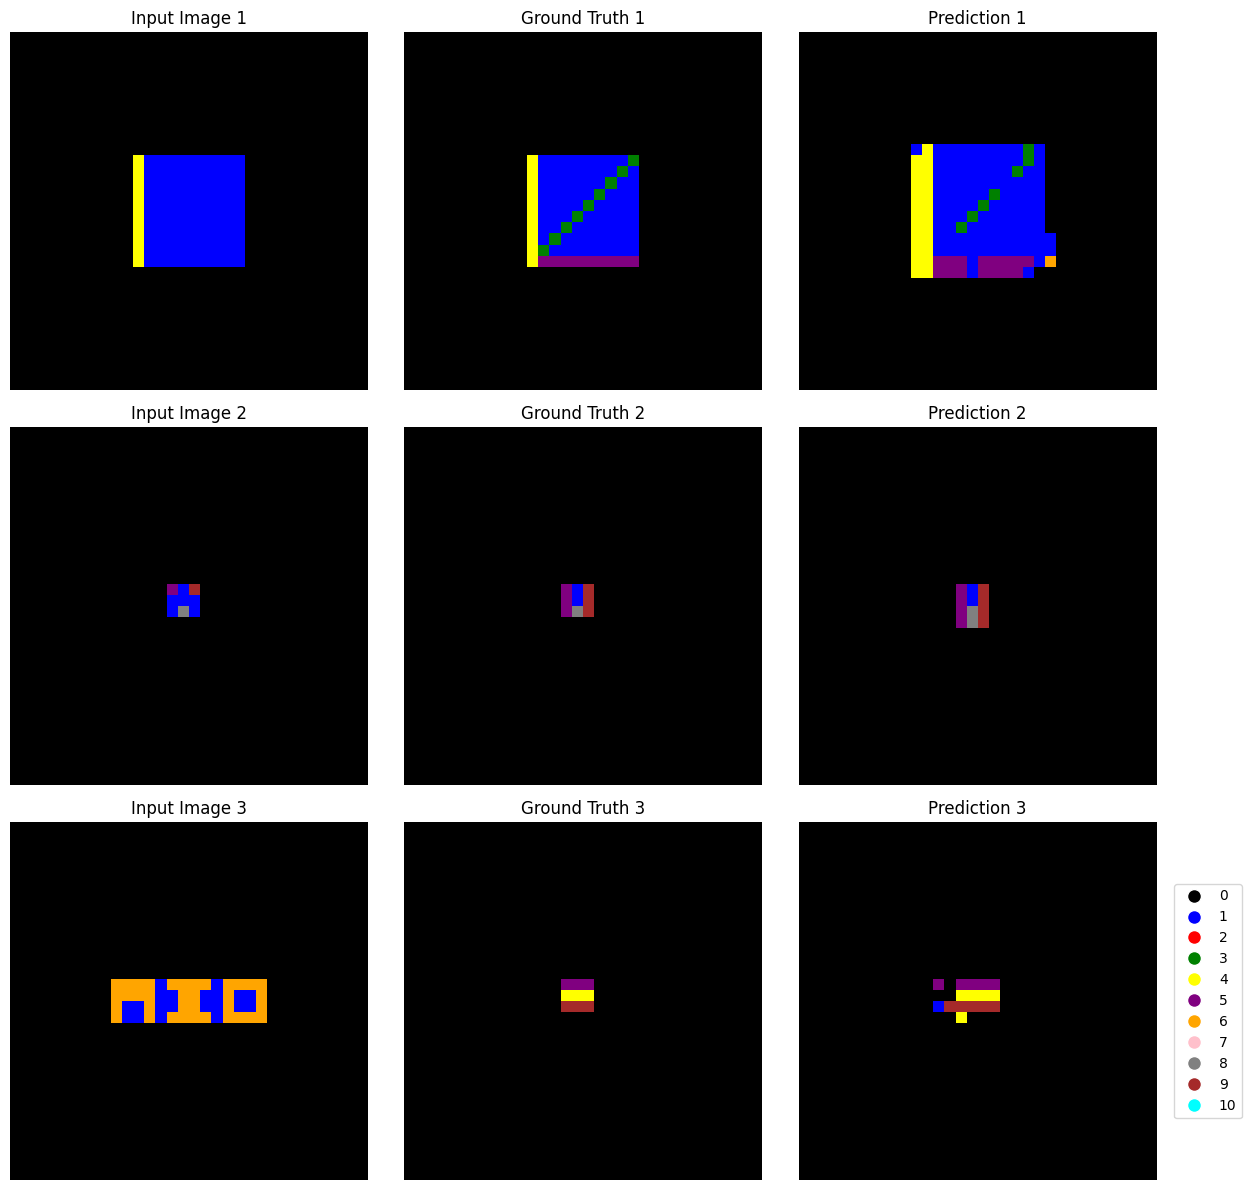

Test Average Loss: 4.352371 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.20%


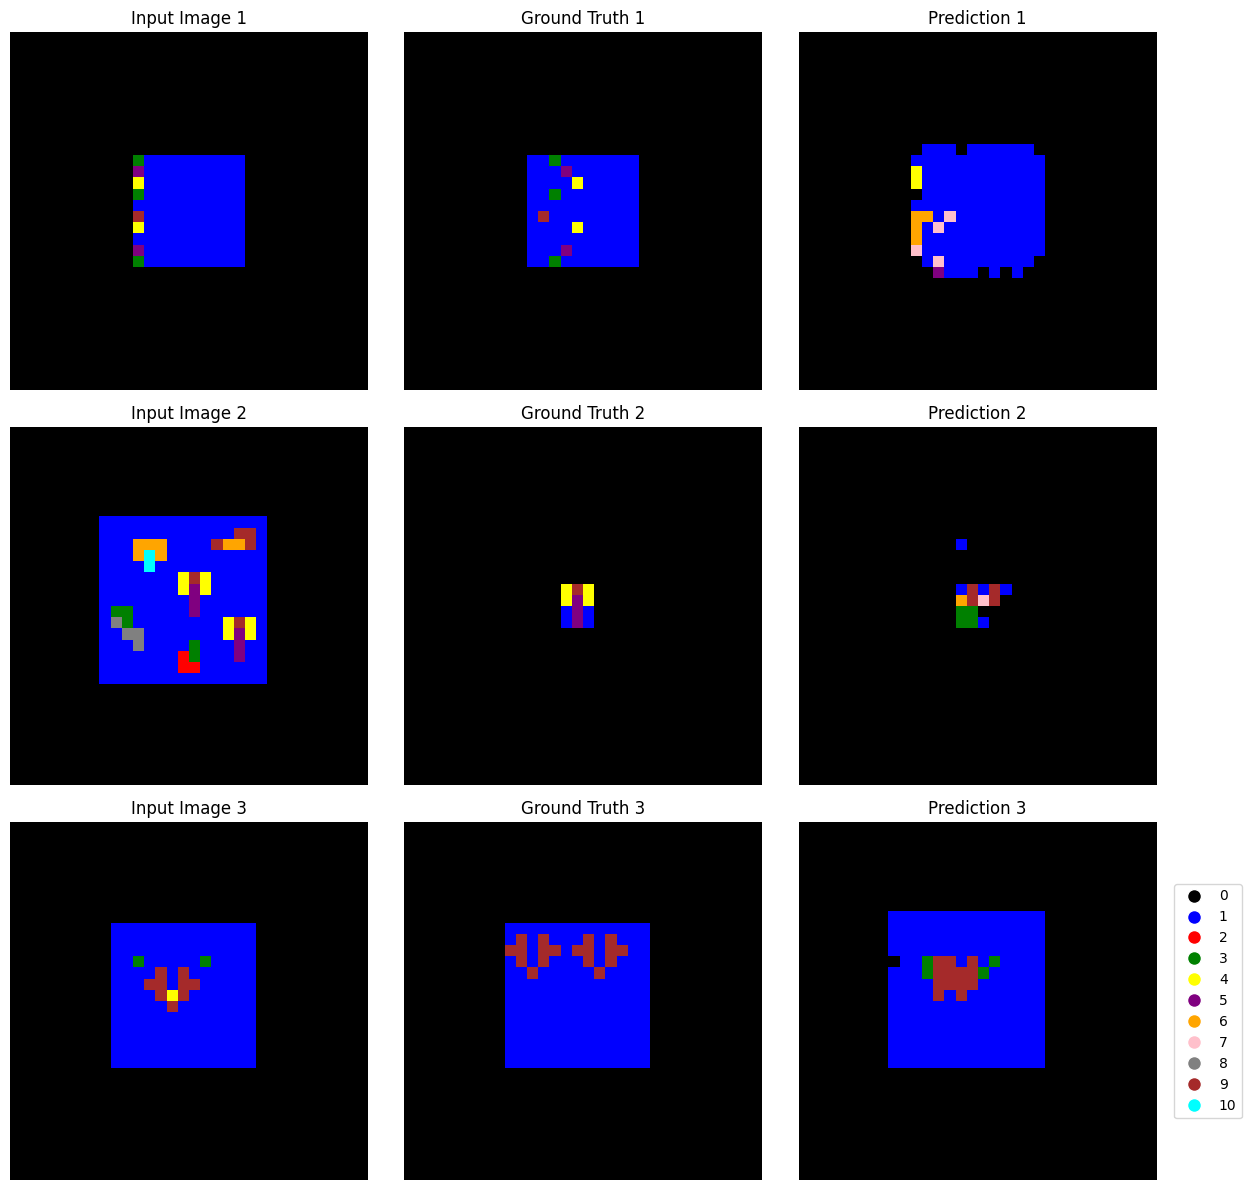

Epoch [151/1000] Complete | Average Loss: 0.133027 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.40%


Test Average Loss: 3.787793 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.76%


Epoch [152/1000] Complete | Average Loss: 0.143960 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.30%


Test Average Loss: 4.453019 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.14%


Epoch [153/1000] Complete | Average Loss: 0.138670 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.30%


Test Average Loss: 3.846051 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.26%


Epoch [154/1000] Complete | Average Loss: 0.144195 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.36%


Test Average Loss: 4.059017 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.11%


Epoch [155/1000] Complete | Average Loss: 0.131126 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.37%


Test Average Loss: 3.623699 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.72%


Epoch [156/1000] Complete | Average Loss: 0.126861 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.37%


Test Average Loss: 4.137107 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.30%


Epoch [157/1000] Complete | Average Loss: 0.119702 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.49%


Test Average Loss: 4.029269 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.14%


Epoch [158/1000] Complete | Average Loss: 0.118091 | Training Sample Accuracy: 0.9930% | Training Pixel Accuracy: 97.47%


Test Average Loss: 4.108308 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.20%


Epoch [159/1000] Complete | Average Loss: 0.122212 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.49%


Test Average Loss: 3.997289 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.80%


Epoch [160/1000] Complete | Average Loss: 0.121512 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.50%


Test Average Loss: 4.531990 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.32%


Epoch [161/1000] Complete | Average Loss: 0.113948 | Training Sample Accuracy: 0.5958% | Training Pixel Accuracy: 97.58%


Test Average Loss: 3.807485 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.53%


Epoch [162/1000] Complete | Average Loss: 0.115559 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.47%


Test Average Loss: 4.592164 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.38%


Epoch [163/1000] Complete | Average Loss: 0.107572 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.57%


Test Average Loss: 4.687878 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.19%


Epoch [164/1000] Complete | Average Loss: 0.105592 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.67%


Test Average Loss: 4.315263 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.31%


Epoch [165/1000] Complete | Average Loss: 0.103951 | Training Sample Accuracy: 0.7944% | Training Pixel Accuracy: 97.69%


Test Average Loss: 4.445021 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.24%


Epoch [166/1000] Complete | Average Loss: 0.100673 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.66%


Test Average Loss: 4.477989 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.17%


Epoch [167/1000] Complete | Average Loss: 0.094060 | Training Sample Accuracy: 0.3972% | Training Pixel Accuracy: 97.71%


Test Average Loss: 4.694165 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.51%


Epoch [168/1000] Complete | Average Loss: 0.098823 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 97.76%


Test Average Loss: 4.450233 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.29%


Epoch [169/1000] Complete | Average Loss: 0.111456 | Training Sample Accuracy: 0.8937% | Training Pixel Accuracy: 97.61%


Test Average Loss: 4.072559 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.56%


Epoch [170/1000] Complete | Average Loss: 0.115117 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.44%


Test Average Loss: 4.643928 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.26%


Epoch [171/1000] Complete | Average Loss: 0.116265 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.62%


Test Average Loss: 4.046452 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.58%


Epoch [172/1000] Complete | Average Loss: 0.114161 | Training Sample Accuracy: 0.5958% | Training Pixel Accuracy: 97.54%


Test Average Loss: 4.637580 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.33%


Epoch [173/1000] Complete | Average Loss: 0.111380 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.57%


Test Average Loss: 4.408979 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.14%


Epoch [174/1000] Complete | Average Loss: 0.106767 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 97.60%


Test Average Loss: 4.467621 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.25%


Epoch [175/1000] Complete | Average Loss: 0.101358 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.68%


Test Average Loss: 4.547323 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.48%


Epoch [176/1000] Complete | Average Loss: 0.096457 | Training Sample Accuracy: 0.2979% | Training Pixel Accuracy: 97.71%


Test Average Loss: 4.649548 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.43%
New best model found! Saving model with accuracy 0.0804%


Epoch [177/1000] Complete | Average Loss: 0.096092 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.70%


Test Average Loss: 4.553041 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.22%


Epoch [178/1000] Complete | Average Loss: 0.094347 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.72%


Test Average Loss: 4.484981 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.39%


Epoch [179/1000] Complete | Average Loss: 0.085236 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 97.83%


Test Average Loss: 4.803847 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.32%


Epoch [180/1000] Complete | Average Loss: 0.089433 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.78%


Test Average Loss: 4.654759 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.43%


Epoch [181/1000] Complete | Average Loss: 0.093652 | Training Sample Accuracy: 0.5958% | Training Pixel Accuracy: 97.76%


Test Average Loss: 4.386551 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.19%


Epoch [182/1000] Complete | Average Loss: 0.095125 | Training Sample Accuracy: 0.0993% | Training Pixel Accuracy: 97.73%


Test Average Loss: 4.435297 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.24%


Epoch [183/1000] Complete | Average Loss: 0.090037 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 97.83%


Test Average Loss: 4.236095 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.34%


Epoch [184/1000] Complete | Average Loss: 0.085834 | Training Sample Accuracy: 1.1917% | Training Pixel Accuracy: 97.84%


Test Average Loss: 4.502394 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.17%


Epoch [185/1000] Complete | Average Loss: 0.080918 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 97.87%


Test Average Loss: 4.497358 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.55%


Epoch [186/1000] Complete | Average Loss: 0.076367 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 97.94%


Test Average Loss: 4.138679 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.40%


Epoch [187/1000] Complete | Average Loss: 0.076828 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 97.92%


Test Average Loss: 4.062091 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.10%


Epoch [188/1000] Complete | Average Loss: 0.077411 | Training Sample Accuracy: 1.2910% | Training Pixel Accuracy: 97.94%


Test Average Loss: 4.364903 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.34%


Epoch [189/1000] Complete | Average Loss: 0.077582 | Training Sample Accuracy: 0.9930% | Training Pixel Accuracy: 97.80%


Test Average Loss: 4.415803 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.14%


Epoch [190/1000] Complete | Average Loss: 0.077733 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 97.78%


Test Average Loss: 4.715116 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.29%


Epoch [191/1000] Complete | Average Loss: 0.078614 | Training Sample Accuracy: 1.1917% | Training Pixel Accuracy: 97.98%


Test Average Loss: 4.638811 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.31%


Epoch [192/1000] Complete | Average Loss: 0.075042 | Training Sample Accuracy: 0.8937% | Training Pixel Accuracy: 97.98%


Test Average Loss: 4.573534 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.31%


Epoch [193/1000] Complete | Average Loss: 0.077700 | Training Sample Accuracy: 1.2910% | Training Pixel Accuracy: 97.89%


Test Average Loss: 3.899986 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.83%


Epoch [194/1000] Complete | Average Loss: 0.076670 | Training Sample Accuracy: 0.7944% | Training Pixel Accuracy: 97.91%


Test Average Loss: 4.420881 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.10%


Epoch [195/1000] Complete | Average Loss: 0.069072 | Training Sample Accuracy: 0.5958% | Training Pixel Accuracy: 98.03%


Test Average Loss: 4.875310 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.66%


Epoch [196/1000] Complete | Average Loss: 0.066771 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 98.05%


Test Average Loss: 4.239355 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.73%


Epoch [197/1000] Complete | Average Loss: 0.069202 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 97.95%


Test Average Loss: 4.675329 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.32%


Epoch [198/1000] Complete | Average Loss: 0.067579 | Training Sample Accuracy: 0.7944% | Training Pixel Accuracy: 98.01%


Test Average Loss: 4.788302 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.11%


Epoch [199/1000] Complete | Average Loss: 0.069645 | Training Sample Accuracy: 0.9930% | Training Pixel Accuracy: 97.99%


Test Average Loss: 4.606904 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.17%


Epoch [200/1000] Complete | Average Loss: 0.070512 | Training Sample Accuracy: 0.9930% | Training Pixel Accuracy: 97.91%


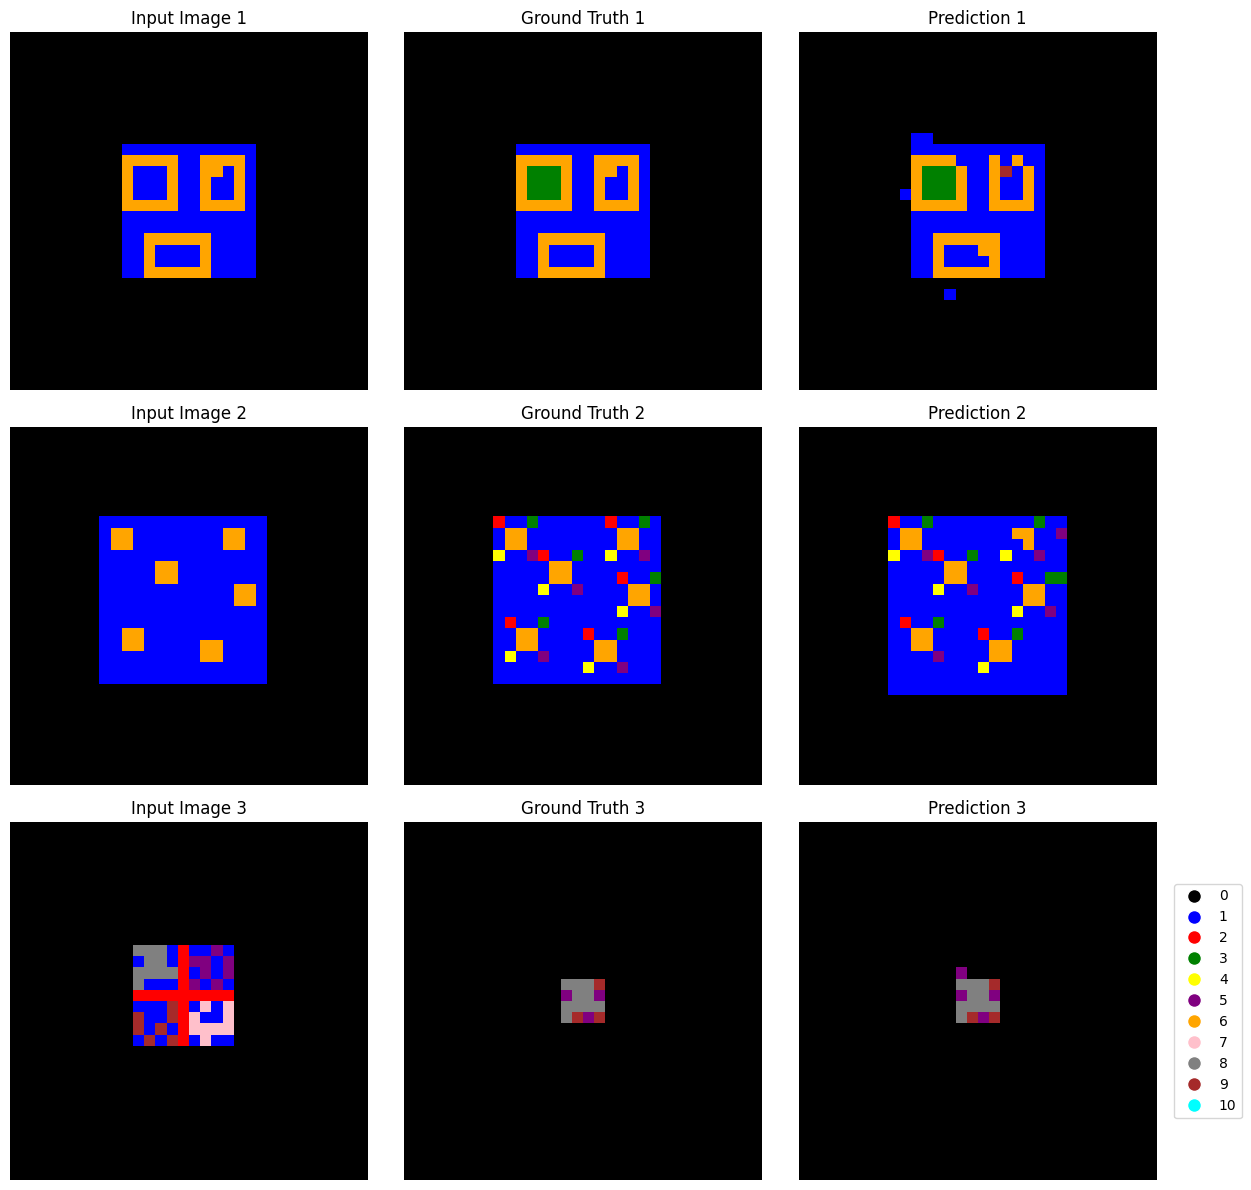

Test Average Loss: 4.686094 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.20%


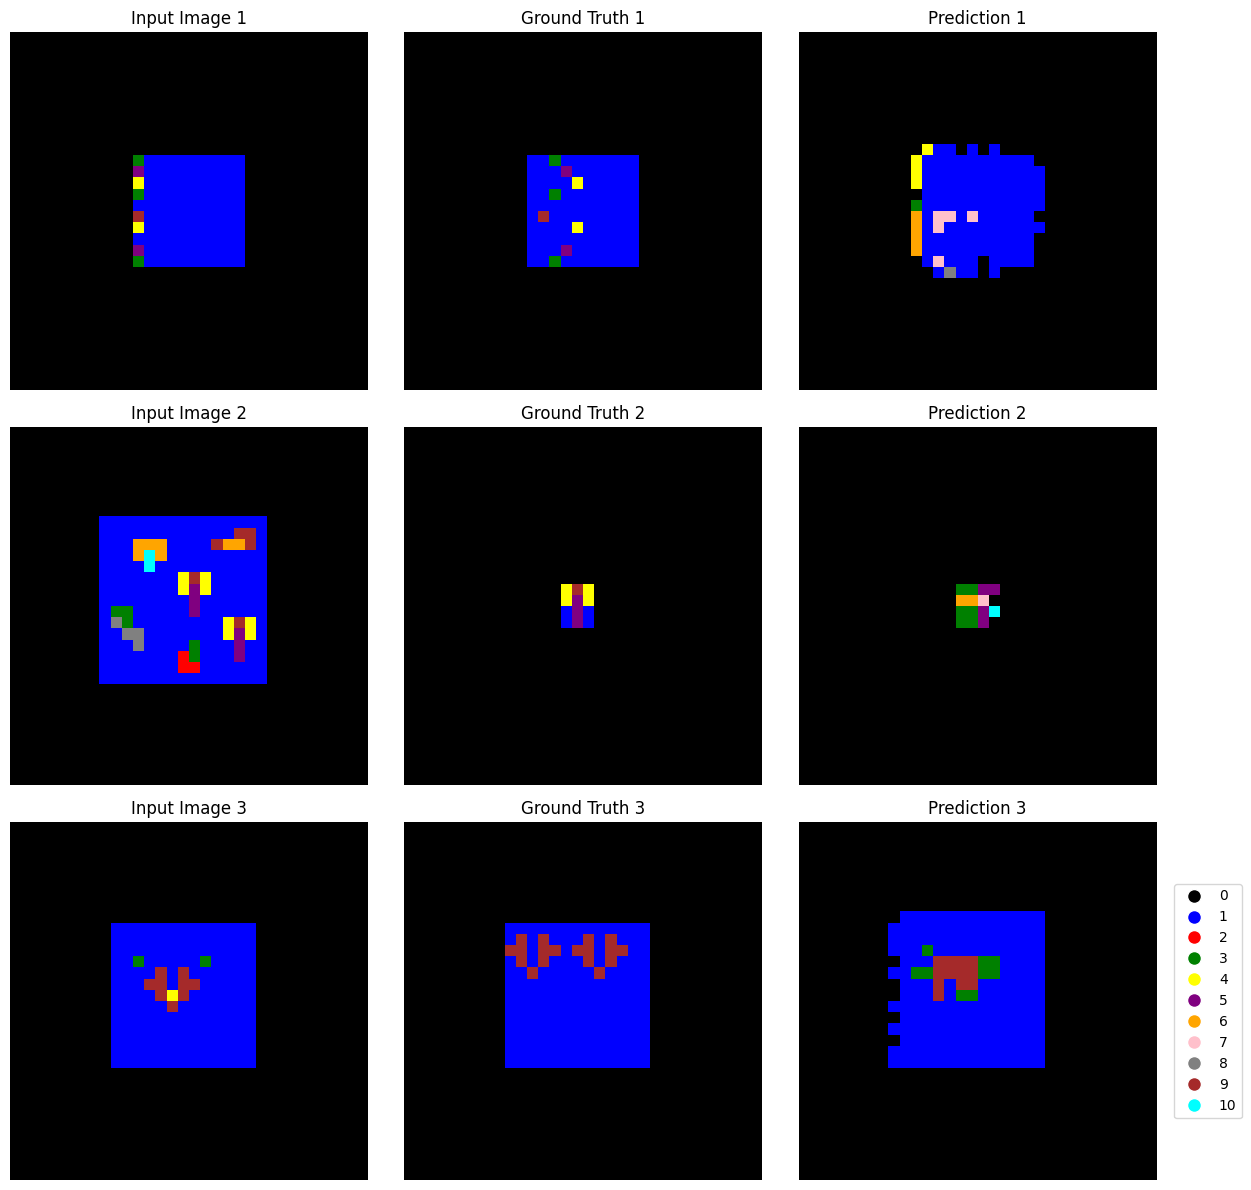

Epoch [201/1000] Complete | Average Loss: 0.077951 | Training Sample Accuracy: 0.8937% | Training Pixel Accuracy: 97.96%


Test Average Loss: 4.514902 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.07%


Epoch [202/1000] Complete | Average Loss: 0.078909 | Training Sample Accuracy: 1.0924% | Training Pixel Accuracy: 97.91%


Test Average Loss: 4.460862 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.93%


Epoch [203/1000] Complete | Average Loss: 0.086016 | Training Sample Accuracy: 0.7944% | Training Pixel Accuracy: 97.74%


Test Average Loss: 4.687686 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.40%


Epoch [204/1000] Complete | Average Loss: 0.083363 | Training Sample Accuracy: 1.2910% | Training Pixel Accuracy: 97.93%


Test Average Loss: 5.155353 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.09%


Epoch [205/1000] Complete | Average Loss: 0.075665 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 97.94%


Test Average Loss: 4.437695 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.20%


Epoch [206/1000] Complete | Average Loss: 0.072718 | Training Sample Accuracy: 1.0924% | Training Pixel Accuracy: 97.90%


Test Average Loss: 4.718297 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.33%


Epoch [207/1000] Complete | Average Loss: 0.066566 | Training Sample Accuracy: 1.1917% | Training Pixel Accuracy: 98.06%


Test Average Loss: 4.358708 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.10%


Epoch [208/1000] Complete | Average Loss: 0.061791 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 98.08%


Test Average Loss: 5.003461 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.22%


Epoch [209/1000] Complete | Average Loss: 0.059466 | Training Sample Accuracy: 1.8868% | Training Pixel Accuracy: 98.16%


Test Average Loss: 4.708588 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.21%


Epoch [210/1000] Complete | Average Loss: 0.063992 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 98.06%


Test Average Loss: 5.102650 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.48%


Epoch [211/1000] Complete | Average Loss: 0.063280 | Training Sample Accuracy: 1.2910% | Training Pixel Accuracy: 98.12%


Test Average Loss: 5.380898 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.49%


Epoch [212/1000] Complete | Average Loss: 0.061660 | Training Sample Accuracy: 2.4826% | Training Pixel Accuracy: 98.16%


Test Average Loss: 4.959937 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.42%


Epoch [213/1000] Complete | Average Loss: 0.060413 | Training Sample Accuracy: 1.4896% | Training Pixel Accuracy: 98.07%


Test Average Loss: 4.831630 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.50%


Epoch [214/1000] Complete | Average Loss: 0.061878 | Training Sample Accuracy: 1.1917% | Training Pixel Accuracy: 98.11%


Test Average Loss: 4.767890 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.52%


Epoch [215/1000] Complete | Average Loss: 0.059195 | Training Sample Accuracy: 1.8868% | Training Pixel Accuracy: 98.18%


Test Average Loss: 4.670090 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.21%


Epoch [216/1000] Complete | Average Loss: 0.060894 | Training Sample Accuracy: 0.8937% | Training Pixel Accuracy: 98.09%


Test Average Loss: 5.068391 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.57%


Epoch [217/1000] Complete | Average Loss: 0.058882 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 98.20%


Test Average Loss: 4.716592 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.57%


Epoch [218/1000] Complete | Average Loss: 0.056242 | Training Sample Accuracy: 1.9861% | Training Pixel Accuracy: 98.24%


Test Average Loss: 5.496682 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.63%


Epoch [219/1000] Complete | Average Loss: 0.057019 | Training Sample Accuracy: 1.4896% | Training Pixel Accuracy: 98.24%


Test Average Loss: 5.015334 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.25%


Epoch [220/1000] Complete | Average Loss: 0.056538 | Training Sample Accuracy: 2.2840% | Training Pixel Accuracy: 98.18%


Test Average Loss: 5.048131 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.35%


Epoch [221/1000] Complete | Average Loss: 0.055503 | Training Sample Accuracy: 1.2910% | Training Pixel Accuracy: 98.15%


Test Average Loss: 5.369728 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.52%


Epoch [222/1000] Complete | Average Loss: 0.052571 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 98.15%


Test Average Loss: 5.178541 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.46%


Epoch [223/1000] Complete | Average Loss: 0.050384 | Training Sample Accuracy: 1.9861% | Training Pixel Accuracy: 98.24%


Test Average Loss: 4.997627 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.35%


Epoch [224/1000] Complete | Average Loss: 0.051698 | Training Sample Accuracy: 3.2771% | Training Pixel Accuracy: 98.23%


Test Average Loss: 4.974474 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.58%


Epoch [225/1000] Complete | Average Loss: 0.047057 | Training Sample Accuracy: 1.9861% | Training Pixel Accuracy: 98.29%


Test Average Loss: 5.690004 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.45%


Epoch [226/1000] Complete | Average Loss: 0.050814 | Training Sample Accuracy: 3.2771% | Training Pixel Accuracy: 98.24%


Test Average Loss: 5.415537 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.59%


Epoch [227/1000] Complete | Average Loss: 0.050733 | Training Sample Accuracy: 3.0785% | Training Pixel Accuracy: 98.30%


Test Average Loss: 5.351094 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.22%


Epoch [228/1000] Complete | Average Loss: 0.054015 | Training Sample Accuracy: 2.5819% | Training Pixel Accuracy: 98.27%


Test Average Loss: 5.242392 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.70%


Epoch [229/1000] Complete | Average Loss: 0.051069 | Training Sample Accuracy: 1.8868% | Training Pixel Accuracy: 98.23%


Test Average Loss: 5.115213 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.49%


Epoch [230/1000] Complete | Average Loss: 0.047094 | Training Sample Accuracy: 1.6882% | Training Pixel Accuracy: 98.30%


Test Average Loss: 5.133144 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.59%


Epoch [231/1000] Complete | Average Loss: 0.047582 | Training Sample Accuracy: 2.4826% | Training Pixel Accuracy: 98.35%


Test Average Loss: 5.337367 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.47%


Epoch [232/1000] Complete | Average Loss: 0.049770 | Training Sample Accuracy: 1.9861% | Training Pixel Accuracy: 98.29%


Test Average Loss: 4.892832 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.37%


Epoch [233/1000] Complete | Average Loss: 0.054329 | Training Sample Accuracy: 1.4896% | Training Pixel Accuracy: 98.24%


Test Average Loss: 4.931455 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.28%


Epoch [234/1000] Complete | Average Loss: 0.053670 | Training Sample Accuracy: 1.1917% | Training Pixel Accuracy: 98.21%


Test Average Loss: 4.867890 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.97%


Epoch [235/1000] Complete | Average Loss: 0.054981 | Training Sample Accuracy: 1.5889% | Training Pixel Accuracy: 98.23%


Test Average Loss: 4.430995 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.18%


Epoch [236/1000] Complete | Average Loss: 0.052031 | Training Sample Accuracy: 1.6882% | Training Pixel Accuracy: 98.19%


Test Average Loss: 5.434684 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.58%


Epoch [237/1000] Complete | Average Loss: 0.055184 | Training Sample Accuracy: 1.0924% | Training Pixel Accuracy: 98.21%


Test Average Loss: 4.853923 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.32%


Epoch [238/1000] Complete | Average Loss: 0.056249 | Training Sample Accuracy: 1.8868% | Training Pixel Accuracy: 98.23%


Test Average Loss: 4.942870 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.34%


Epoch [239/1000] Complete | Average Loss: 0.062598 | Training Sample Accuracy: 1.7875% | Training Pixel Accuracy: 98.11%


Test Average Loss: 4.404118 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.89%


Epoch [240/1000] Complete | Average Loss: 0.062272 | Training Sample Accuracy: 1.9861% | Training Pixel Accuracy: 98.16%


Test Average Loss: 4.807014 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.11%


Epoch [241/1000] Complete | Average Loss: 0.062872 | Training Sample Accuracy: 2.1847% | Training Pixel Accuracy: 98.13%


Test Average Loss: 5.016754 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.49%


Epoch [242/1000] Complete | Average Loss: 0.064933 | Training Sample Accuracy: 2.6812% | Training Pixel Accuracy: 98.22%


Test Average Loss: 4.951816 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.32%


Epoch [243/1000] Complete | Average Loss: 0.061032 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 98.15%


Test Average Loss: 5.101756 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.45%


Epoch [244/1000] Complete | Average Loss: 0.054049 | Training Sample Accuracy: 1.9861% | Training Pixel Accuracy: 98.24%


Test Average Loss: 5.208575 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.34%


Epoch [245/1000] Complete | Average Loss: 0.052686 | Training Sample Accuracy: 2.0854% | Training Pixel Accuracy: 98.19%


Test Average Loss: 5.113633 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.53%


Epoch [246/1000] Complete | Average Loss: 0.053367 | Training Sample Accuracy: 2.5819% | Training Pixel Accuracy: 98.25%


Test Average Loss: 5.730943 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.42%


Epoch [247/1000] Complete | Average Loss: 0.062339 | Training Sample Accuracy: 1.8868% | Training Pixel Accuracy: 98.23%


Test Average Loss: 6.008323 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.77%


Epoch [248/1000] Complete | Average Loss: 0.070089 | Training Sample Accuracy: 1.9861% | Training Pixel Accuracy: 98.11%


Test Average Loss: 5.437949 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.23%


Epoch [249/1000] Complete | Average Loss: 0.075035 | Training Sample Accuracy: 1.1917% | Training Pixel Accuracy: 97.92%


Test Average Loss: 5.288740 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.12%


Epoch [250/1000] Complete | Average Loss: 0.069337 | Training Sample Accuracy: 1.7875% | Training Pixel Accuracy: 98.01%


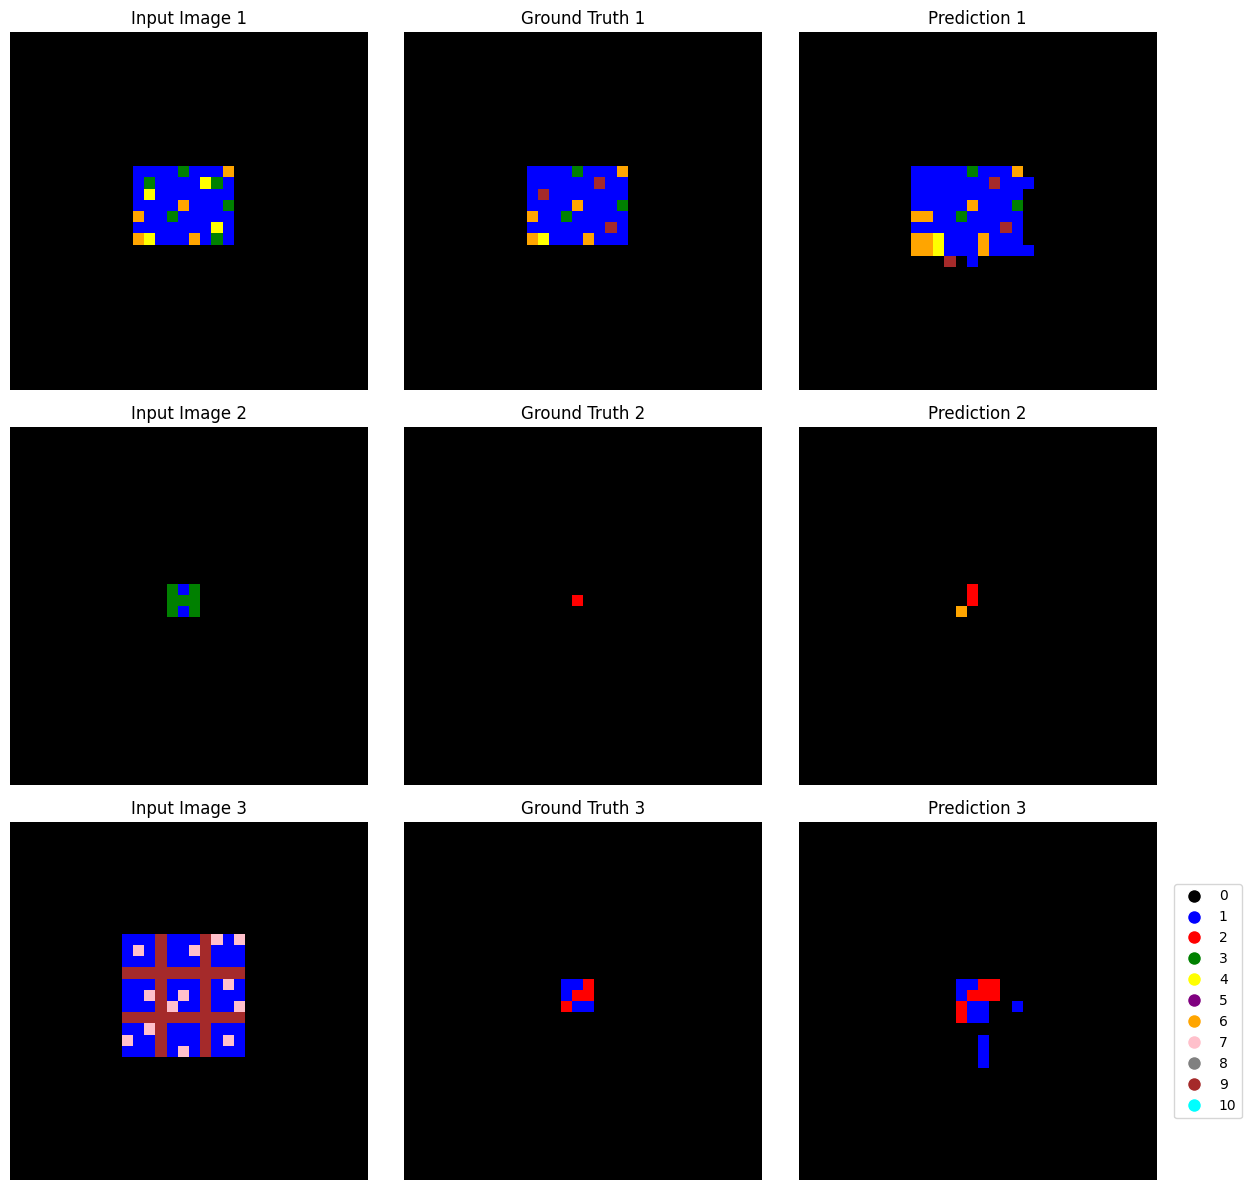

Test Average Loss: 4.253909 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 88.77%


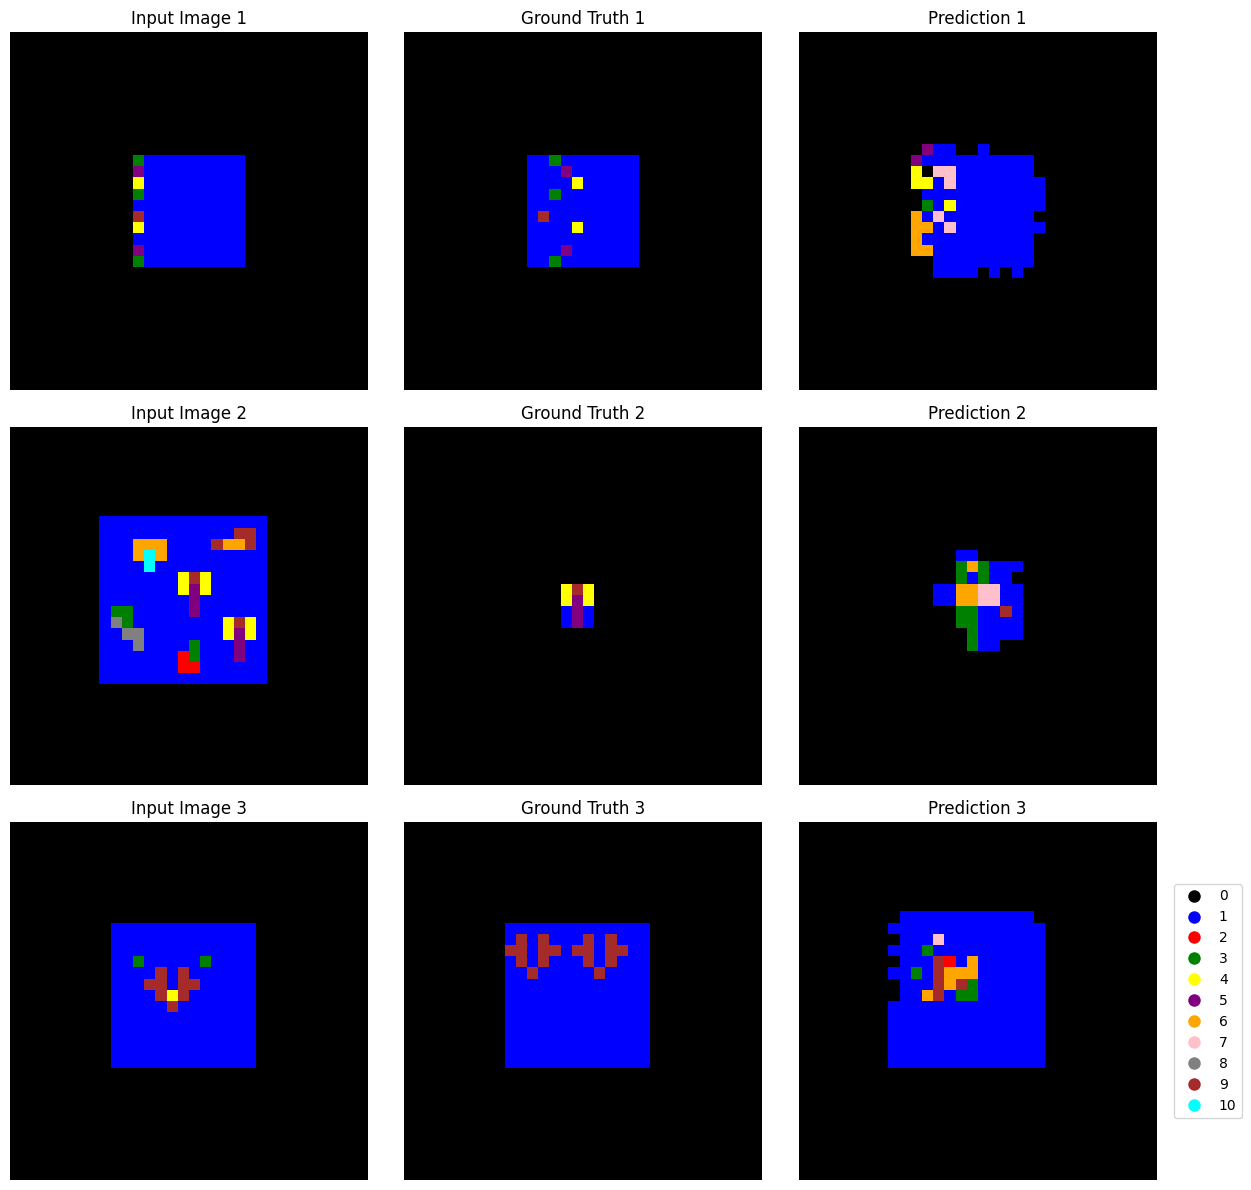

Epoch [251/1000] Complete | Average Loss: 0.066573 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 98.02%


Test Average Loss: 4.626919 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.20%


Epoch [252/1000] Complete | Average Loss: 0.060668 | Training Sample Accuracy: 2.7805% | Training Pixel Accuracy: 98.18%


Test Average Loss: 4.328300 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 88.87%


Epoch [253/1000] Complete | Average Loss: 0.062996 | Training Sample Accuracy: 2.0854% | Training Pixel Accuracy: 98.02%


Test Average Loss: 5.022460 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.46%


Epoch [254/1000] Complete | Average Loss: 0.059825 | Training Sample Accuracy: 2.2840% | Training Pixel Accuracy: 98.10%


Test Average Loss: 5.060659 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.92%


Epoch [255/1000] Complete | Average Loss: 0.056810 | Training Sample Accuracy: 1.9861% | Training Pixel Accuracy: 98.17%


Test Average Loss: 5.123104 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.38%


Epoch [256/1000] Complete | Average Loss: 0.050399 | Training Sample Accuracy: 2.9791% | Training Pixel Accuracy: 98.30%


Test Average Loss: 4.827243 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.48%


Epoch [257/1000] Complete | Average Loss: 0.048870 | Training Sample Accuracy: 2.1847% | Training Pixel Accuracy: 98.35%


Test Average Loss: 5.037348 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.19%


Epoch [258/1000] Complete | Average Loss: 0.048363 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 98.21%


Test Average Loss: 5.244737 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.59%


Epoch [259/1000] Complete | Average Loss: 0.044821 | Training Sample Accuracy: 2.9791% | Training Pixel Accuracy: 98.29%


Test Average Loss: 5.313896 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.47%


Epoch [260/1000] Complete | Average Loss: 0.040651 | Training Sample Accuracy: 2.5819% | Training Pixel Accuracy: 98.38%


Test Average Loss: 5.351781 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.57%


Epoch [261/1000] Complete | Average Loss: 0.039630 | Training Sample Accuracy: 4.0715% | Training Pixel Accuracy: 98.45%


Test Average Loss: 5.334823 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.44%


Epoch [262/1000] Complete | Average Loss: 0.037574 | Training Sample Accuracy: 3.2771% | Training Pixel Accuracy: 98.49%


Test Average Loss: 5.589282 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.57%


Epoch [263/1000] Complete | Average Loss: 0.036394 | Training Sample Accuracy: 2.7805% | Training Pixel Accuracy: 98.41%


Test Average Loss: 5.601700 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.64%


Epoch [264/1000] Complete | Average Loss: 0.034375 | Training Sample Accuracy: 4.5680% | Training Pixel Accuracy: 98.50%


Test Average Loss: 5.782699 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.76%


Epoch [265/1000] Complete | Average Loss: 0.032029 | Training Sample Accuracy: 3.9722% | Training Pixel Accuracy: 98.58%


Test Average Loss: 5.620768 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.56%


Epoch [266/1000] Complete | Average Loss: 0.029852 | Training Sample Accuracy: 3.6743% | Training Pixel Accuracy: 98.61%


Test Average Loss: 5.479507 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.69%


Epoch [267/1000] Complete | Average Loss: 0.031141 | Training Sample Accuracy: 5.0645% | Training Pixel Accuracy: 98.59%


Test Average Loss: 5.433674 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.64%


Epoch [268/1000] Complete | Average Loss: 0.031885 | Training Sample Accuracy: 3.9722% | Training Pixel Accuracy: 98.59%


Test Average Loss: 5.786738 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.86%


Epoch [269/1000] Complete | Average Loss: 0.029989 | Training Sample Accuracy: 3.3764% | Training Pixel Accuracy: 98.60%


Test Average Loss: 5.210512 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.47%


Epoch [270/1000] Complete | Average Loss: 0.027782 | Training Sample Accuracy: 5.0645% | Training Pixel Accuracy: 98.63%


Test Average Loss: 5.738392 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.69%


Epoch [271/1000] Complete | Average Loss: 0.031370 | Training Sample Accuracy: 4.3694% | Training Pixel Accuracy: 98.65%


Test Average Loss: 5.841666 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.70%


Epoch [272/1000] Complete | Average Loss: 0.030374 | Training Sample Accuracy: 4.9652% | Training Pixel Accuracy: 98.67%


Test Average Loss: 5.265852 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.43%


Epoch [273/1000] Complete | Average Loss: 0.028287 | Training Sample Accuracy: 4.6673% | Training Pixel Accuracy: 98.66%


Test Average Loss: 6.091417 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.72%


Epoch [274/1000] Complete | Average Loss: 0.031999 | Training Sample Accuracy: 4.2701% | Training Pixel Accuracy: 98.66%


Test Average Loss: 5.417910 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.44%


Epoch [275/1000] Complete | Average Loss: 0.033664 | Training Sample Accuracy: 4.1708% | Training Pixel Accuracy: 98.58%


Test Average Loss: 6.134481 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.69%


Epoch [276/1000] Complete | Average Loss: 0.033350 | Training Sample Accuracy: 5.4618% | Training Pixel Accuracy: 98.60%


Test Average Loss: 6.031748 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.53%


Epoch [277/1000] Complete | Average Loss: 0.031086 | Training Sample Accuracy: 3.2771% | Training Pixel Accuracy: 98.63%


Test Average Loss: 5.530386 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.68%


Epoch [278/1000] Complete | Average Loss: 0.029770 | Training Sample Accuracy: 4.7666% | Training Pixel Accuracy: 98.69%


Test Average Loss: 5.019329 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.25%


Epoch [279/1000] Complete | Average Loss: 0.032833 | Training Sample Accuracy: 2.0854% | Training Pixel Accuracy: 98.42%


Test Average Loss: 5.053049 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.41%


Epoch [280/1000] Complete | Average Loss: 0.034710 | Training Sample Accuracy: 2.5819% | Training Pixel Accuracy: 98.50%


Test Average Loss: 4.864273 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.33%


Epoch [281/1000] Complete | Average Loss: 0.034944 | Training Sample Accuracy: 4.6673% | Training Pixel Accuracy: 98.62%


Test Average Loss: 5.131933 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.46%


Epoch [282/1000] Complete | Average Loss: 0.034667 | Training Sample Accuracy: 3.7736% | Training Pixel Accuracy: 98.45%


Test Average Loss: 5.199935 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.33%


Epoch [283/1000] Complete | Average Loss: 0.035480 | Training Sample Accuracy: 3.5750% | Training Pixel Accuracy: 98.57%


Test Average Loss: 5.378918 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.58%


Epoch [284/1000] Complete | Average Loss: 0.036060 | Training Sample Accuracy: 3.5750% | Training Pixel Accuracy: 98.58%


Test Average Loss: 4.590760 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.38%


Epoch [285/1000] Complete | Average Loss: 0.037430 | Training Sample Accuracy: 2.2840% | Training Pixel Accuracy: 98.14%


Test Average Loss: 5.810653 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.65%


Epoch [286/1000] Complete | Average Loss: 0.037756 | Training Sample Accuracy: 3.3764% | Training Pixel Accuracy: 98.47%


Test Average Loss: 4.838853 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.16%


Epoch [287/1000] Complete | Average Loss: 0.039691 | Training Sample Accuracy: 2.3833% | Training Pixel Accuracy: 98.41%


Test Average Loss: 4.926882 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.34%


Epoch [288/1000] Complete | Average Loss: 0.041859 | Training Sample Accuracy: 2.5819% | Training Pixel Accuracy: 98.43%


Test Average Loss: 5.527306 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.67%


Epoch [289/1000] Complete | Average Loss: 0.048620 | Training Sample Accuracy: 3.1778% | Training Pixel Accuracy: 98.44%


Test Average Loss: 4.860283 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.01%


Epoch [290/1000] Complete | Average Loss: 0.046419 | Training Sample Accuracy: 1.8868% | Training Pixel Accuracy: 98.35%


Test Average Loss: 4.982937 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.12%


Epoch [291/1000] Complete | Average Loss: 0.059054 | Training Sample Accuracy: 2.1847% | Training Pixel Accuracy: 98.34%


Test Average Loss: 5.307518 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.96%


Epoch [292/1000] Complete | Average Loss: 0.088318 | Training Sample Accuracy: 0.8937% | Training Pixel Accuracy: 97.81%


Test Average Loss: 5.718017 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.06%


Epoch [293/1000] Complete | Average Loss: 0.093920 | Training Sample Accuracy: 1.0924% | Training Pixel Accuracy: 97.47%


Test Average Loss: 5.484474 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.48%


Epoch [294/1000] Complete | Average Loss: 0.073270 | Training Sample Accuracy: 1.4896% | Training Pixel Accuracy: 98.04%


Test Average Loss: 4.794973 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.83%


Epoch [295/1000] Complete | Average Loss: 0.070375 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 97.98%


Test Average Loss: 4.463244 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.69%


Epoch [296/1000] Complete | Average Loss: 0.064411 | Training Sample Accuracy: 2.6812% | Training Pixel Accuracy: 98.16%


Test Average Loss: 5.606992 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.45%


Epoch [297/1000] Complete | Average Loss: 0.057045 | Training Sample Accuracy: 1.7875% | Training Pixel Accuracy: 98.23%


Test Average Loss: 4.798724 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.42%


Epoch [298/1000] Complete | Average Loss: 0.046370 | Training Sample Accuracy: 1.8868% | Training Pixel Accuracy: 98.43%


Test Average Loss: 4.851679 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.25%


Epoch [299/1000] Complete | Average Loss: 0.039637 | Training Sample Accuracy: 2.1847% | Training Pixel Accuracy: 98.44%


Test Average Loss: 4.793296 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.46%


Epoch [300/1000] Complete | Average Loss: 0.036241 | Training Sample Accuracy: 4.6673% | Training Pixel Accuracy: 98.56%


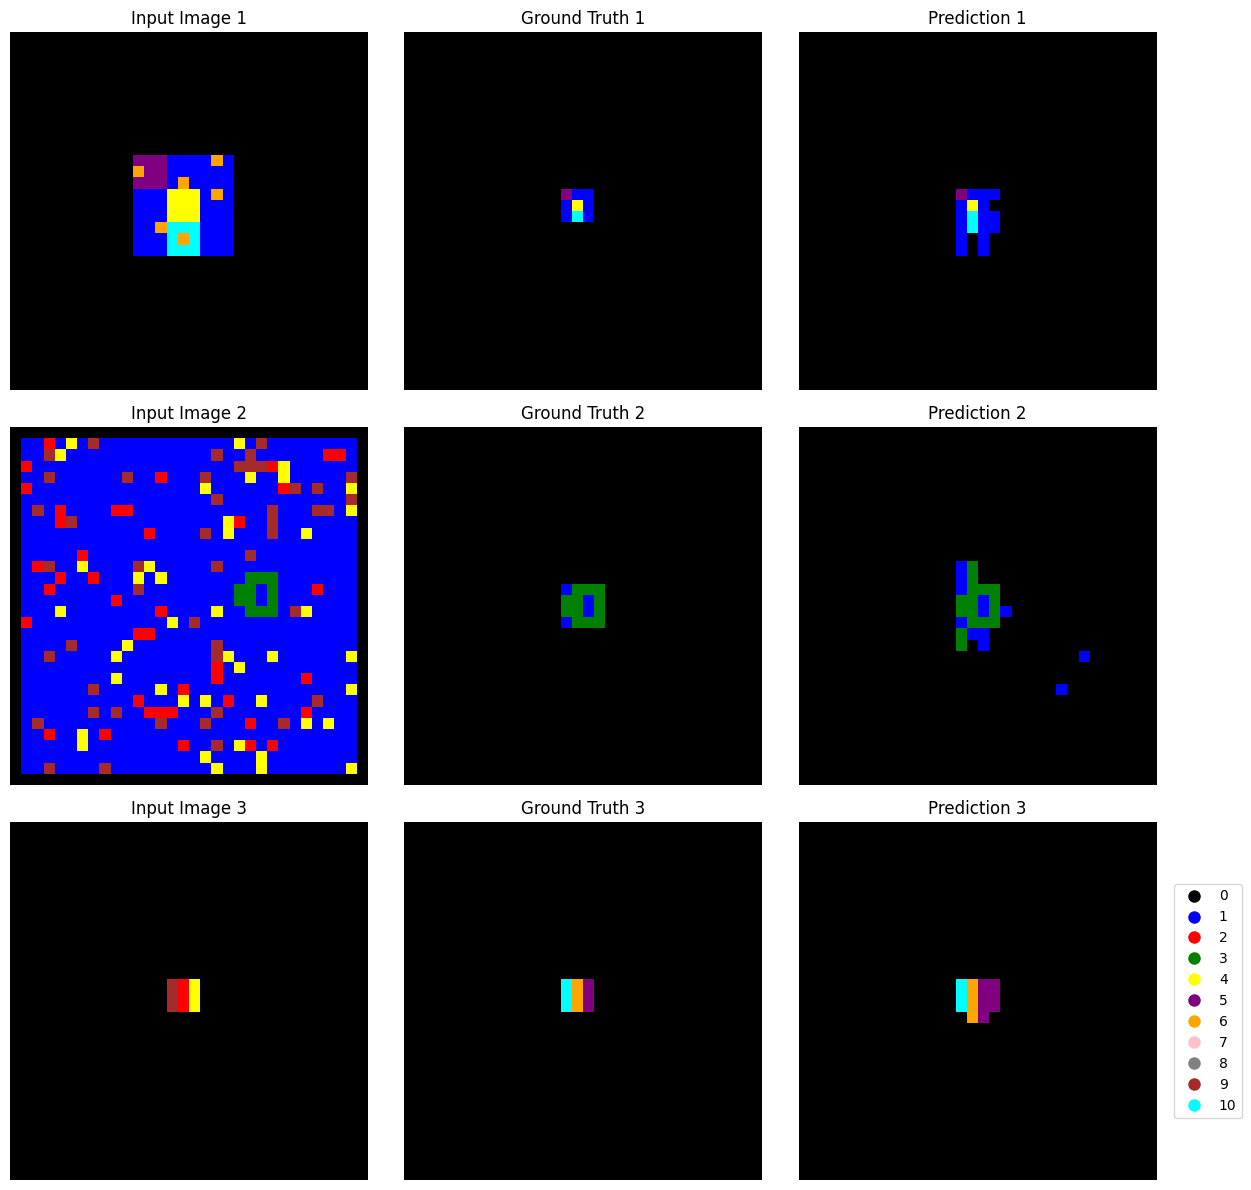

Test Average Loss: 5.416943 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.62%


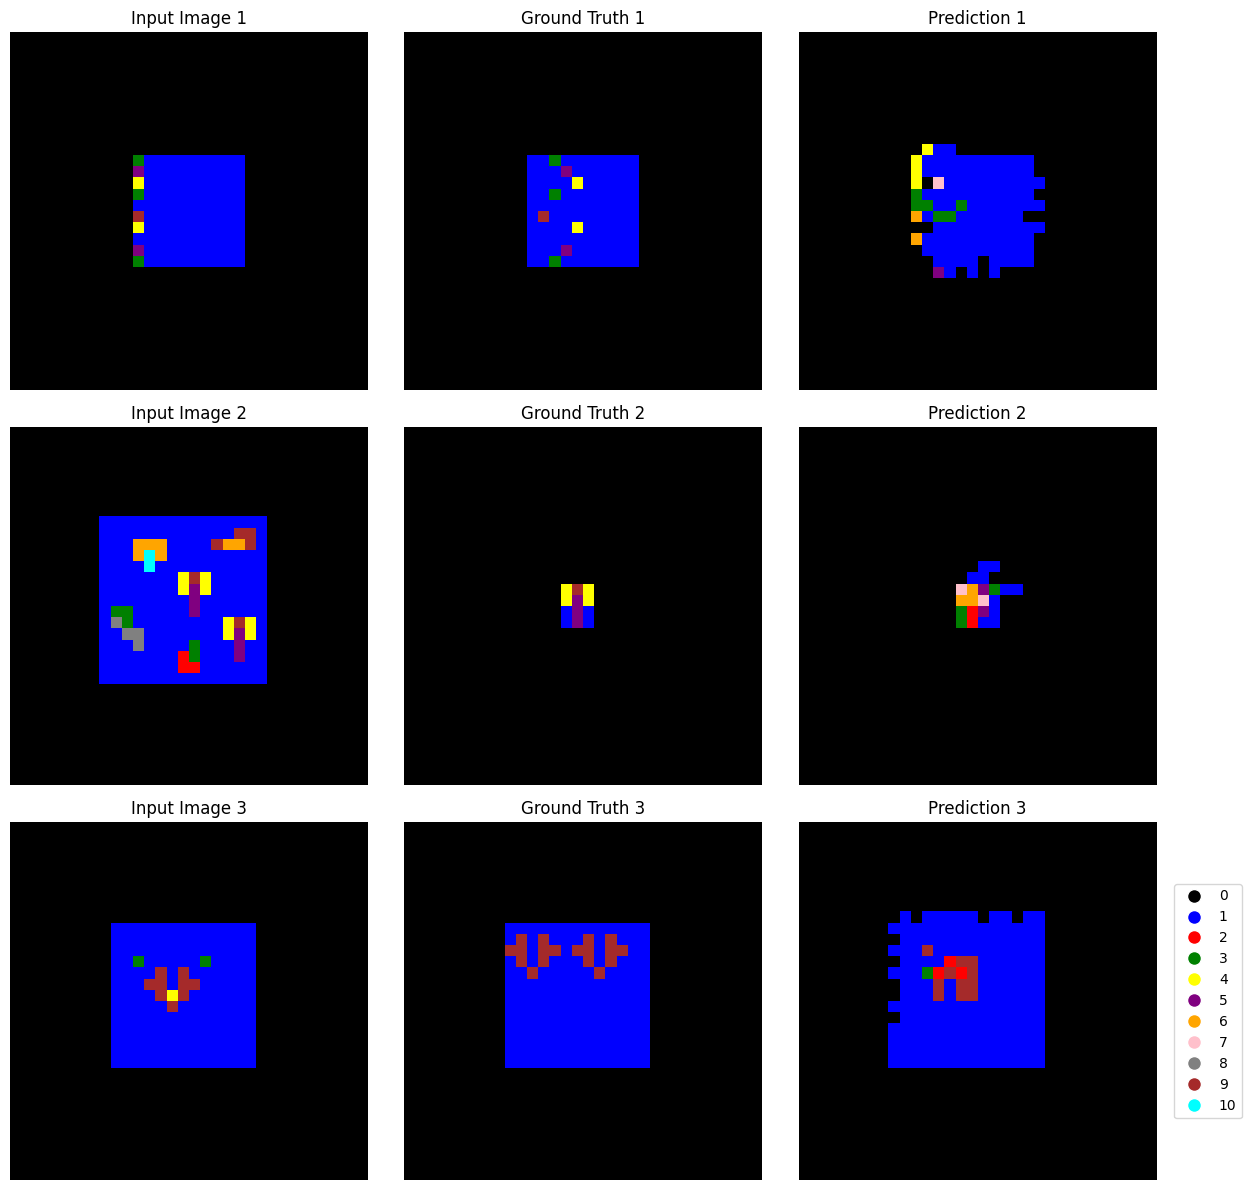

Epoch [301/1000] Complete | Average Loss: 0.032212 | Training Sample Accuracy: 2.1847% | Training Pixel Accuracy: 98.55%


Test Average Loss: 4.770911 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.67%


Epoch [302/1000] Complete | Average Loss: 0.033954 | Training Sample Accuracy: 3.1778% | Training Pixel Accuracy: 98.26%


Test Average Loss: 5.524877 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.43%


Epoch [303/1000] Complete | Average Loss: 0.032054 | Training Sample Accuracy: 4.2701% | Training Pixel Accuracy: 98.56%


Test Average Loss: 4.742998 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.11%


Epoch [304/1000] Complete | Average Loss: 0.029790 | Training Sample Accuracy: 3.1778% | Training Pixel Accuracy: 98.38%


Test Average Loss: 5.472831 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.69%


Epoch [305/1000] Complete | Average Loss: 0.029880 | Training Sample Accuracy: 5.7597% | Training Pixel Accuracy: 98.64%


Test Average Loss: 5.689252 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.78%


Epoch [306/1000] Complete | Average Loss: 0.030534 | Training Sample Accuracy: 4.2701% | Training Pixel Accuracy: 98.66%


Test Average Loss: 5.745787 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.78%


Epoch [307/1000] Complete | Average Loss: 0.028187 | Training Sample Accuracy: 5.0645% | Training Pixel Accuracy: 98.63%


Test Average Loss: 5.714330 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.80%


Epoch [308/1000] Complete | Average Loss: 0.027344 | Training Sample Accuracy: 7.2493% | Training Pixel Accuracy: 98.69%


Test Average Loss: 5.461013 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.74%


Epoch [309/1000] Complete | Average Loss: 0.024581 | Training Sample Accuracy: 4.9652% | Training Pixel Accuracy: 98.71%


Test Average Loss: 5.854176 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.81%


Epoch [310/1000] Complete | Average Loss: 0.023058 | Training Sample Accuracy: 7.5472% | Training Pixel Accuracy: 98.80%


Test Average Loss: 5.519893 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.79%


Epoch [311/1000] Complete | Average Loss: 0.023459 | Training Sample Accuracy: 6.4548% | Training Pixel Accuracy: 98.79%


Test Average Loss: 5.586267 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.95%


Epoch [312/1000] Complete | Average Loss: 0.021714 | Training Sample Accuracy: 5.7597% | Training Pixel Accuracy: 98.80%


Test Average Loss: 5.702324 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.88%


Epoch [313/1000] Complete | Average Loss: 0.020639 | Training Sample Accuracy: 6.8520% | Training Pixel Accuracy: 98.81%


Test Average Loss: 5.788087 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.94%


Epoch [314/1000] Complete | Average Loss: 0.020007 | Training Sample Accuracy: 8.0437% | Training Pixel Accuracy: 98.88%


Test Average Loss: 5.905537 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.84%


Epoch [315/1000] Complete | Average Loss: 0.020742 | Training Sample Accuracy: 5.9583% | Training Pixel Accuracy: 98.83%


Test Average Loss: 5.619250 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.75%


Epoch [316/1000] Complete | Average Loss: 0.022017 | Training Sample Accuracy: 5.3625% | Training Pixel Accuracy: 98.80%


Test Average Loss: 5.803588 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.85%


Epoch [317/1000] Complete | Average Loss: 0.022762 | Training Sample Accuracy: 6.5541% | Training Pixel Accuracy: 98.79%


Test Average Loss: 5.189949 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.63%


Epoch [318/1000] Complete | Average Loss: 0.026009 | Training Sample Accuracy: 5.1639% | Training Pixel Accuracy: 98.77%


Test Average Loss: 5.098311 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.45%


Epoch [319/1000] Complete | Average Loss: 0.026772 | Training Sample Accuracy: 5.0645% | Training Pixel Accuracy: 98.73%


Test Average Loss: 5.846251 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.94%


Epoch [320/1000] Complete | Average Loss: 0.027358 | Training Sample Accuracy: 5.1639% | Training Pixel Accuracy: 98.76%


Test Average Loss: 6.022759 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.80%


Epoch [321/1000] Complete | Average Loss: 0.024956 | Training Sample Accuracy: 6.1569% | Training Pixel Accuracy: 98.78%


Test Average Loss: 6.384093 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.80%


Epoch [322/1000] Complete | Average Loss: 0.024273 | Training Sample Accuracy: 5.0645% | Training Pixel Accuracy: 98.77%


Test Average Loss: 5.779305 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.69%


Epoch [323/1000] Complete | Average Loss: 0.027918 | Training Sample Accuracy: 3.8729% | Training Pixel Accuracy: 98.74%


Test Average Loss: 6.073254 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.97%


Epoch [324/1000] Complete | Average Loss: 0.033780 | Training Sample Accuracy: 3.3764% | Training Pixel Accuracy: 98.40%


Test Average Loss: 5.372090 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.29%


Epoch [325/1000] Complete | Average Loss: 0.035677 | Training Sample Accuracy: 3.4757% | Training Pixel Accuracy: 98.48%


Test Average Loss: 5.683575 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.53%


Epoch [326/1000] Complete | Average Loss: 0.036040 | Training Sample Accuracy: 3.1778% | Training Pixel Accuracy: 98.58%


Test Average Loss: 5.281595 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.09%


Epoch [327/1000] Complete | Average Loss: 0.039266 | Training Sample Accuracy: 4.7666% | Training Pixel Accuracy: 98.60%


Test Average Loss: 5.222524 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.09%


Epoch [328/1000] Complete | Average Loss: 0.045726 | Training Sample Accuracy: 3.6743% | Training Pixel Accuracy: 98.58%


Test Average Loss: 5.952278 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.44%


Epoch [329/1000] Complete | Average Loss: 0.044011 | Training Sample Accuracy: 5.0645% | Training Pixel Accuracy: 98.57%


Test Average Loss: 5.283146 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.48%


Epoch [330/1000] Complete | Average Loss: 0.044920 | Training Sample Accuracy: 3.3764% | Training Pixel Accuracy: 98.45%


Test Average Loss: 4.892791 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.32%


Epoch [331/1000] Complete | Average Loss: 0.043283 | Training Sample Accuracy: 4.3694% | Training Pixel Accuracy: 98.62%


Test Average Loss: 4.918152 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.48%


Epoch [332/1000] Complete | Average Loss: 0.048142 | Training Sample Accuracy: 2.9791% | Training Pixel Accuracy: 98.52%


Test Average Loss: 4.876941 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.21%


Epoch [333/1000] Complete | Average Loss: 0.039843 | Training Sample Accuracy: 3.2771% | Training Pixel Accuracy: 98.59%


Test Average Loss: 4.977816 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.15%


Epoch [334/1000] Complete | Average Loss: 0.033236 | Training Sample Accuracy: 3.1778% | Training Pixel Accuracy: 98.63%


Test Average Loss: 5.187859 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.56%


Epoch [335/1000] Complete | Average Loss: 0.032770 | Training Sample Accuracy: 5.6604% | Training Pixel Accuracy: 98.67%


Test Average Loss: 5.664374 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.91%


Epoch [336/1000] Complete | Average Loss: 0.031585 | Training Sample Accuracy: 3.8729% | Training Pixel Accuracy: 98.70%


Test Average Loss: 5.186794 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.41%


Epoch [337/1000] Complete | Average Loss: 0.031728 | Training Sample Accuracy: 3.6743% | Training Pixel Accuracy: 98.66%


Test Average Loss: 5.631888 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.51%


Epoch [338/1000] Complete | Average Loss: 0.029365 | Training Sample Accuracy: 3.2771% | Training Pixel Accuracy: 98.65%


Test Average Loss: 5.712719 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.84%


Epoch [339/1000] Complete | Average Loss: 0.024646 | Training Sample Accuracy: 4.4687% | Training Pixel Accuracy: 98.77%


Test Average Loss: 5.559350 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.68%


Epoch [340/1000] Complete | Average Loss: 0.021623 | Training Sample Accuracy: 5.3625% | Training Pixel Accuracy: 98.79%


Test Average Loss: 6.305595 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.78%


Epoch [341/1000] Complete | Average Loss: 0.020068 | Training Sample Accuracy: 6.7527% | Training Pixel Accuracy: 98.85%


Test Average Loss: 5.527196 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.71%


Epoch [342/1000] Complete | Average Loss: 0.020521 | Training Sample Accuracy: 6.5541% | Training Pixel Accuracy: 98.83%


Test Average Loss: 5.502999 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.63%


Epoch [343/1000] Complete | Average Loss: 0.018209 | Training Sample Accuracy: 6.9513% | Training Pixel Accuracy: 98.86%


Test Average Loss: 6.043103 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.87%


Epoch [344/1000] Complete | Average Loss: 0.017785 | Training Sample Accuracy: 7.9444% | Training Pixel Accuracy: 98.91%


Test Average Loss: 5.995367 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.91%


Epoch [345/1000] Complete | Average Loss: 0.018297 | Training Sample Accuracy: 8.6395% | Training Pixel Accuracy: 98.93%


Test Average Loss: 5.855570 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.81%


Epoch [346/1000] Complete | Average Loss: 0.018271 | Training Sample Accuracy: 8.0437% | Training Pixel Accuracy: 98.93%


Test Average Loss: 6.167653 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.07%


Epoch [347/1000] Complete | Average Loss: 0.020206 | Training Sample Accuracy: 6.9513% | Training Pixel Accuracy: 98.92%


Test Average Loss: 5.871440 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.76%


Epoch [348/1000] Complete | Average Loss: 0.018594 | Training Sample Accuracy: 7.3486% | Training Pixel Accuracy: 98.92%


Test Average Loss: 5.873548 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.89%


Epoch [349/1000] Complete | Average Loss: 0.017033 | Training Sample Accuracy: 8.0437% | Training Pixel Accuracy: 98.90%


Test Average Loss: 6.344602 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.10%


Epoch [350/1000] Complete | Average Loss: 0.016859 | Training Sample Accuracy: 9.4340% | Training Pixel Accuracy: 98.92%


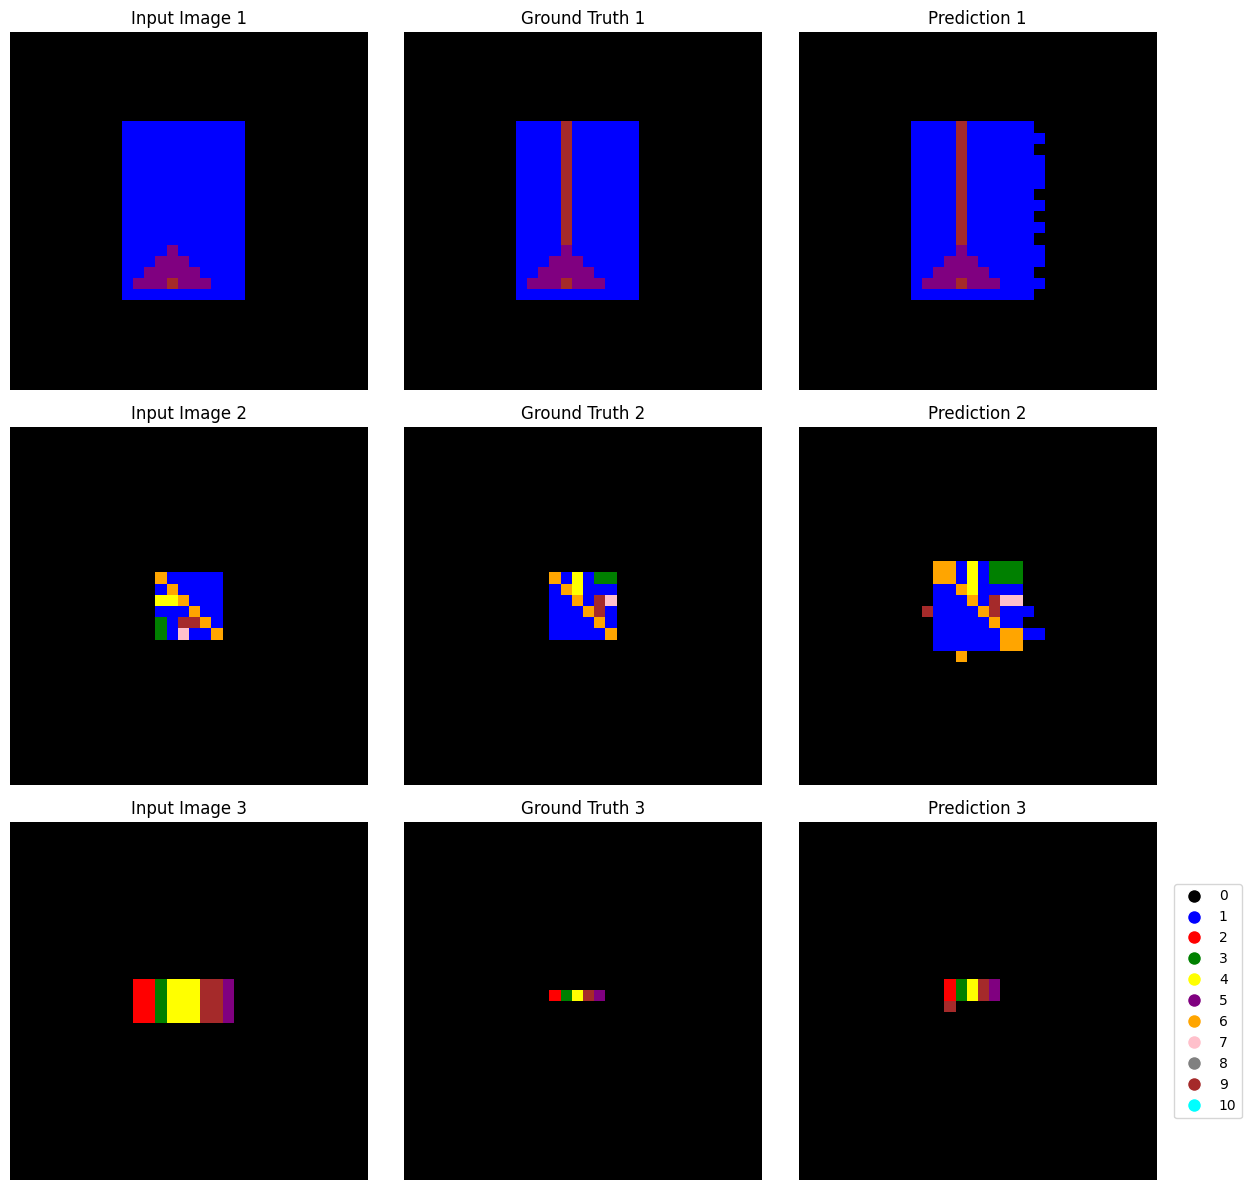

Test Average Loss: 5.522025 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.71%


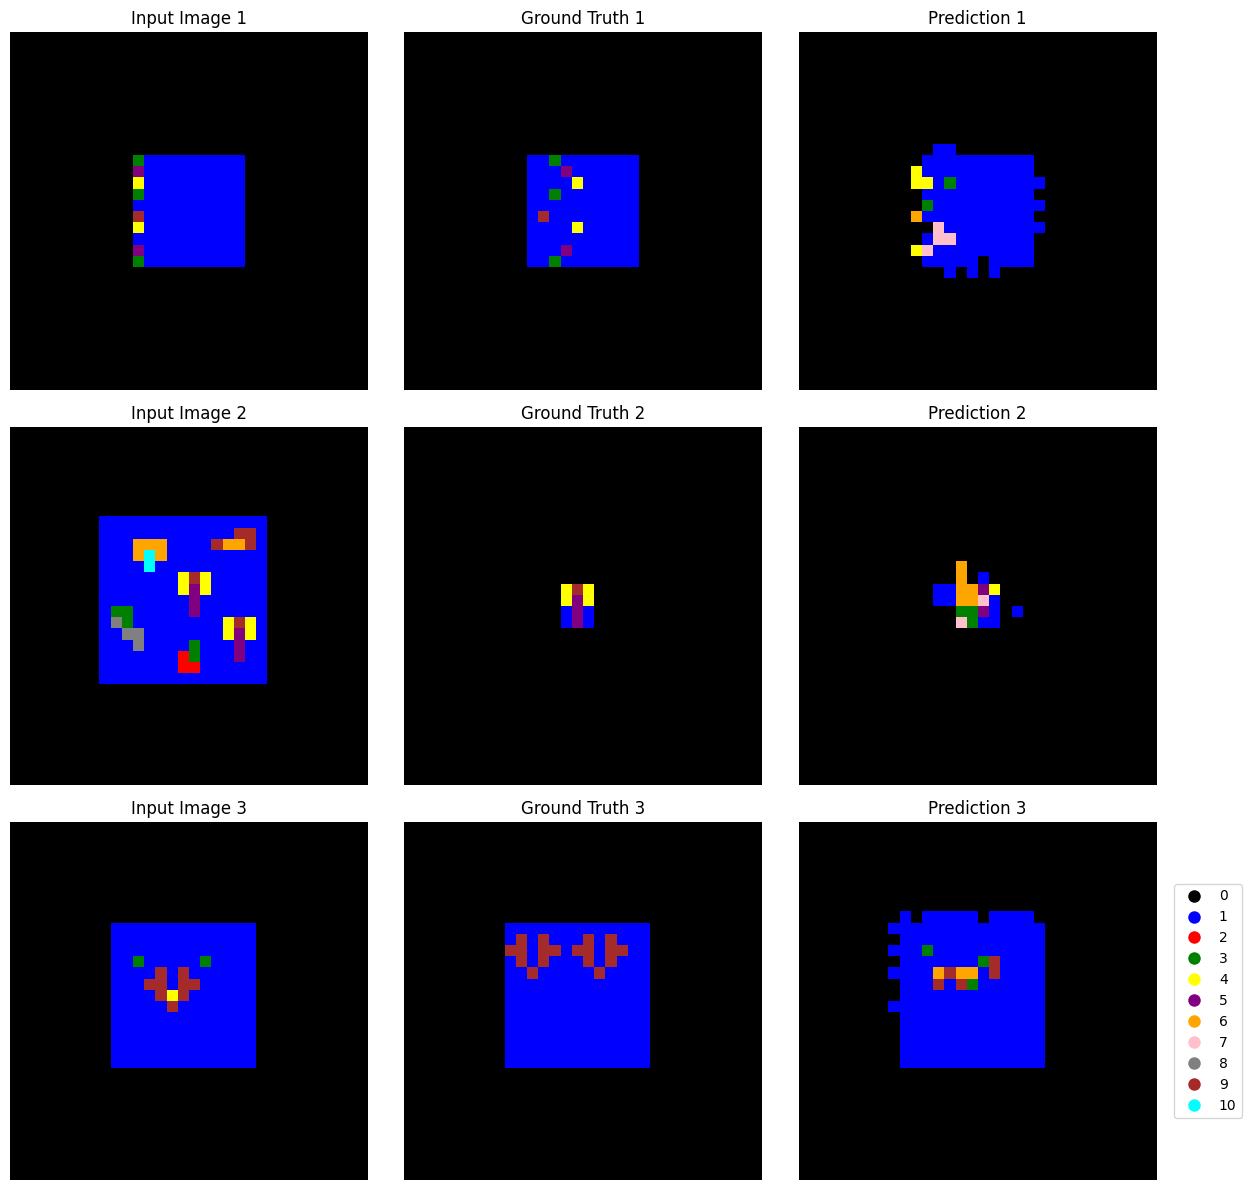

Epoch [351/1000] Complete | Average Loss: 0.015984 | Training Sample Accuracy: 8.3416% | Training Pixel Accuracy: 98.92%


Test Average Loss: 5.949163 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.90%


Epoch [352/1000] Complete | Average Loss: 0.018100 | Training Sample Accuracy: 8.3416% | Training Pixel Accuracy: 98.92%


Test Average Loss: 5.778088 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.67%


Epoch [353/1000] Complete | Average Loss: 0.019121 | Training Sample Accuracy: 7.9444% | Training Pixel Accuracy: 98.88%


Test Average Loss: 5.752078 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.71%


Epoch [354/1000] Complete | Average Loss: 0.019404 | Training Sample Accuracy: 7.0506% | Training Pixel Accuracy: 98.88%


Test Average Loss: 5.994629 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.00%


Epoch [355/1000] Complete | Average Loss: 0.019144 | Training Sample Accuracy: 6.6534% | Training Pixel Accuracy: 98.90%


Test Average Loss: 5.981588 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [356/1000] Complete | Average Loss: 0.021288 | Training Sample Accuracy: 7.2493% | Training Pixel Accuracy: 98.93%


Test Average Loss: 6.404102 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.92%


Epoch [357/1000] Complete | Average Loss: 0.026881 | Training Sample Accuracy: 7.1500% | Training Pixel Accuracy: 98.91%


Test Average Loss: 5.549127 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.28%


Epoch [358/1000] Complete | Average Loss: 0.038359 | Training Sample Accuracy: 5.1639% | Training Pixel Accuracy: 98.69%


Test Average Loss: 4.703537 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.80%


Epoch [359/1000] Complete | Average Loss: 0.077837 | Training Sample Accuracy: 1.4896% | Training Pixel Accuracy: 96.71%


Test Average Loss: 5.199860 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.81%


Epoch [360/1000] Complete | Average Loss: 0.115028 | Training Sample Accuracy: 0.8937% | Training Pixel Accuracy: 97.14%


Test Average Loss: 4.215408 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.82%


Epoch [361/1000] Complete | Average Loss: 0.113102 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 97.57%


Test Average Loss: 4.382892 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.09%


Epoch [362/1000] Complete | Average Loss: 0.105726 | Training Sample Accuracy: 0.8937% | Training Pixel Accuracy: 97.73%


Test Average Loss: 3.959678 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.69%


Epoch [363/1000] Complete | Average Loss: 0.097742 | Training Sample Accuracy: 0.7944% | Training Pixel Accuracy: 97.73%


Test Average Loss: 4.211760 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.83%


Epoch [364/1000] Complete | Average Loss: 0.078191 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 97.92%


Test Average Loss: 4.199613 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.12%


Epoch [365/1000] Complete | Average Loss: 0.056654 | Training Sample Accuracy: 0.9930% | Training Pixel Accuracy: 98.23%


Test Average Loss: 4.396307 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.24%


Epoch [366/1000] Complete | Average Loss: 0.044702 | Training Sample Accuracy: 2.0854% | Training Pixel Accuracy: 98.46%


Test Average Loss: 4.889484 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.33%


Epoch [367/1000] Complete | Average Loss: 0.038132 | Training Sample Accuracy: 1.2910% | Training Pixel Accuracy: 98.44%


Test Average Loss: 4.731138 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.54%


Epoch [368/1000] Complete | Average Loss: 0.030746 | Training Sample Accuracy: 3.5750% | Training Pixel Accuracy: 98.60%


Test Average Loss: 5.160359 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.88%


Epoch [369/1000] Complete | Average Loss: 0.024913 | Training Sample Accuracy: 5.2632% | Training Pixel Accuracy: 98.72%


Test Average Loss: 5.612712 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [370/1000] Complete | Average Loss: 0.020908 | Training Sample Accuracy: 7.3486% | Training Pixel Accuracy: 98.81%


Test Average Loss: 5.251915 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.93%


Epoch [371/1000] Complete | Average Loss: 0.017317 | Training Sample Accuracy: 6.2562% | Training Pixel Accuracy: 98.88%


Test Average Loss: 5.366587 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.88%


Epoch [372/1000] Complete | Average Loss: 0.016600 | Training Sample Accuracy: 5.4618% | Training Pixel Accuracy: 98.90%


Test Average Loss: 5.861371 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.05%


Epoch [373/1000] Complete | Average Loss: 0.015276 | Training Sample Accuracy: 6.5541% | Training Pixel Accuracy: 98.94%


Test Average Loss: 5.626696 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.90%


Epoch [374/1000] Complete | Average Loss: 0.016097 | Training Sample Accuracy: 8.3416% | Training Pixel Accuracy: 98.97%


Test Average Loss: 5.938644 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.92%


Epoch [375/1000] Complete | Average Loss: 0.015785 | Training Sample Accuracy: 6.5541% | Training Pixel Accuracy: 98.95%


Test Average Loss: 5.779638 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.97%


Epoch [376/1000] Complete | Average Loss: 0.017217 | Training Sample Accuracy: 7.9444% | Training Pixel Accuracy: 98.98%


Test Average Loss: 5.372660 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.65%


Epoch [377/1000] Complete | Average Loss: 0.016794 | Training Sample Accuracy: 7.7458% | Training Pixel Accuracy: 98.92%


Test Average Loss: 5.747423 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.82%


Epoch [378/1000] Complete | Average Loss: 0.018610 | Training Sample Accuracy: 8.8381% | Training Pixel Accuracy: 98.94%


Test Average Loss: 5.836756 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.90%


Epoch [379/1000] Complete | Average Loss: 0.018250 | Training Sample Accuracy: 8.1430% | Training Pixel Accuracy: 98.98%


Test Average Loss: 6.394163 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.91%


Epoch [380/1000] Complete | Average Loss: 0.019344 | Training Sample Accuracy: 8.4409% | Training Pixel Accuracy: 99.00%


Test Average Loss: 5.842309 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.82%


Epoch [381/1000] Complete | Average Loss: 0.019850 | Training Sample Accuracy: 9.1360% | Training Pixel Accuracy: 98.97%


Test Average Loss: 6.023261 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.09%


Epoch [382/1000] Complete | Average Loss: 0.025774 | Training Sample Accuracy: 7.6465% | Training Pixel Accuracy: 98.91%


Test Average Loss: 5.685622 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.72%


Epoch [383/1000] Complete | Average Loss: 0.025334 | Training Sample Accuracy: 7.2493% | Training Pixel Accuracy: 98.92%


Test Average Loss: 5.574318 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.87%


Epoch [384/1000] Complete | Average Loss: 0.028194 | Training Sample Accuracy: 4.6673% | Training Pixel Accuracy: 98.83%


Test Average Loss: 5.563808 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.74%


Epoch [385/1000] Complete | Average Loss: 0.033605 | Training Sample Accuracy: 5.7597% | Training Pixel Accuracy: 98.75%


Test Average Loss: 5.472597 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.74%


Epoch [386/1000] Complete | Average Loss: 0.033322 | Training Sample Accuracy: 5.9583% | Training Pixel Accuracy: 98.74%


Test Average Loss: 5.922867 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.85%


Epoch [387/1000] Complete | Average Loss: 0.028406 | Training Sample Accuracy: 3.6743% | Training Pixel Accuracy: 98.78%


Test Average Loss: 5.234206 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.49%


Epoch [388/1000] Complete | Average Loss: 0.032736 | Training Sample Accuracy: 3.3764% | Training Pixel Accuracy: 98.68%


Test Average Loss: 5.458472 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.70%


Epoch [389/1000] Complete | Average Loss: 0.029846 | Training Sample Accuracy: 3.9722% | Training Pixel Accuracy: 98.70%


Test Average Loss: 5.848409 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.77%


Epoch [390/1000] Complete | Average Loss: 0.028145 | Training Sample Accuracy: 5.7597% | Training Pixel Accuracy: 98.76%


Test Average Loss: 5.605387 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.73%


Epoch [391/1000] Complete | Average Loss: 0.025619 | Training Sample Accuracy: 5.3625% | Training Pixel Accuracy: 98.79%


Test Average Loss: 5.564742 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.81%


Epoch [392/1000] Complete | Average Loss: 0.020737 | Training Sample Accuracy: 5.5611% | Training Pixel Accuracy: 98.89%


Test Average Loss: 5.616410 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.97%


Epoch [393/1000] Complete | Average Loss: 0.019018 | Training Sample Accuracy: 6.0576% | Training Pixel Accuracy: 98.96%


Test Average Loss: 5.843862 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.92%


Epoch [394/1000] Complete | Average Loss: 0.017329 | Training Sample Accuracy: 7.2493% | Training Pixel Accuracy: 98.94%


Test Average Loss: 5.489629 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.79%


Epoch [395/1000] Complete | Average Loss: 0.015509 | Training Sample Accuracy: 6.6534% | Training Pixel Accuracy: 98.96%


Test Average Loss: 5.846615 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.72%


Epoch [396/1000] Complete | Average Loss: 0.014316 | Training Sample Accuracy: 6.7527% | Training Pixel Accuracy: 98.99%


Test Average Loss: 6.438808 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.02%


Epoch [397/1000] Complete | Average Loss: 0.014632 | Training Sample Accuracy: 8.3416% | Training Pixel Accuracy: 99.01%


Test Average Loss: 6.177416 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.85%


Epoch [398/1000] Complete | Average Loss: 0.015674 | Training Sample Accuracy: 9.4340% | Training Pixel Accuracy: 98.98%


Test Average Loss: 5.826461 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.49%


Epoch [399/1000] Complete | Average Loss: 0.019014 | Training Sample Accuracy: 7.6465% | Training Pixel Accuracy: 98.93%


Test Average Loss: 6.098335 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.94%


Epoch [400/1000] Complete | Average Loss: 0.017762 | Training Sample Accuracy: 6.3555% | Training Pixel Accuracy: 98.95%


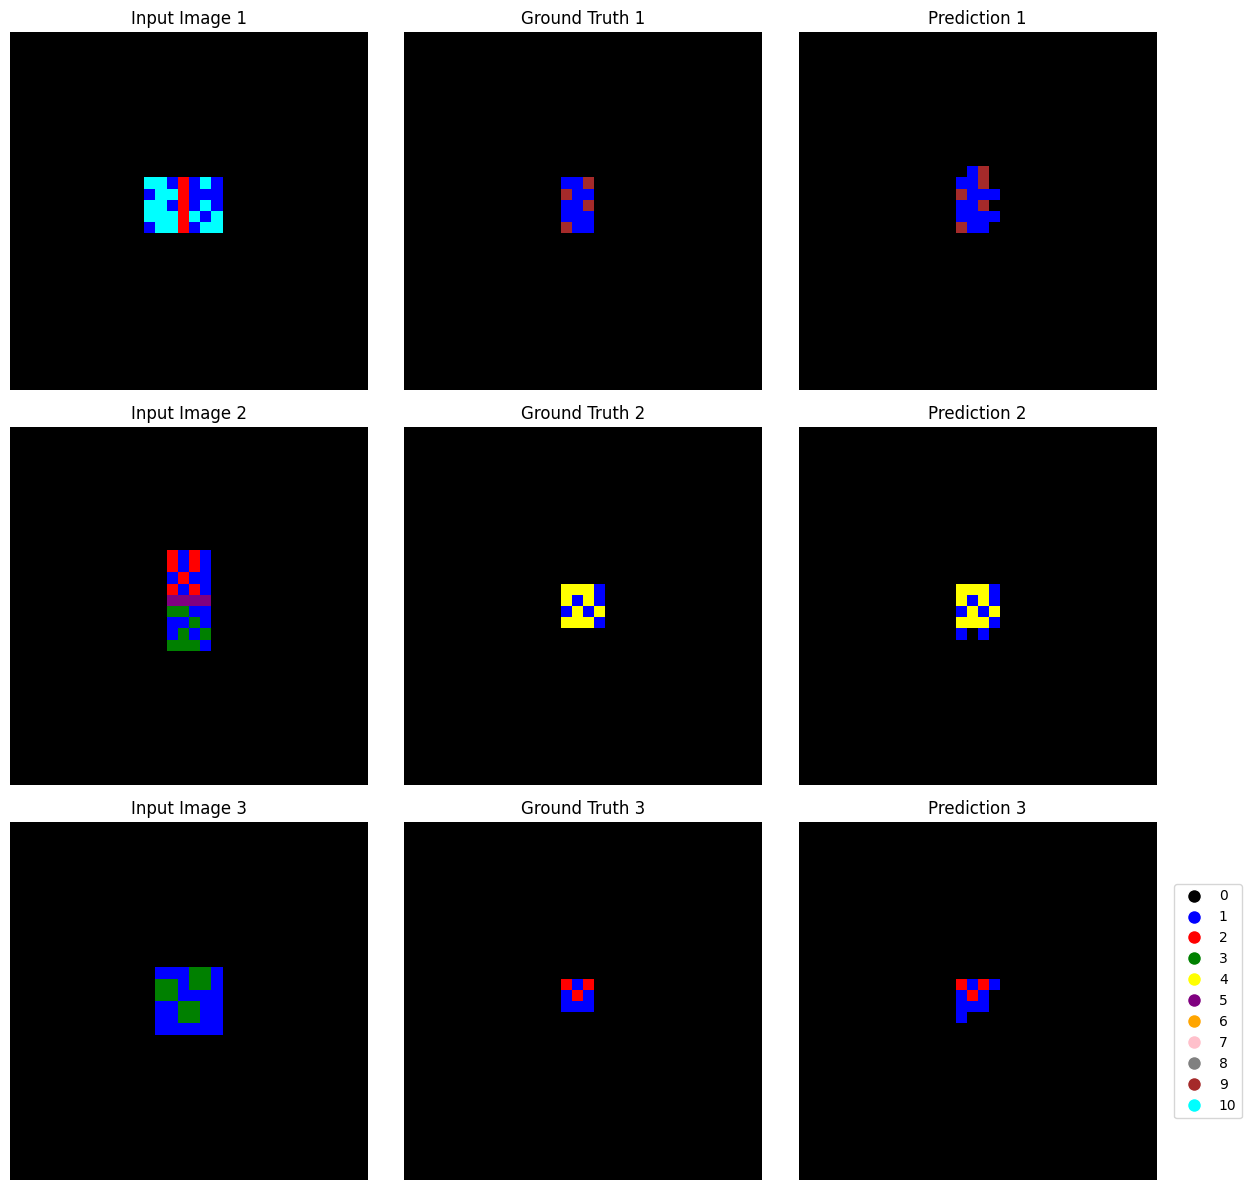

Test Average Loss: 5.315713 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.68%


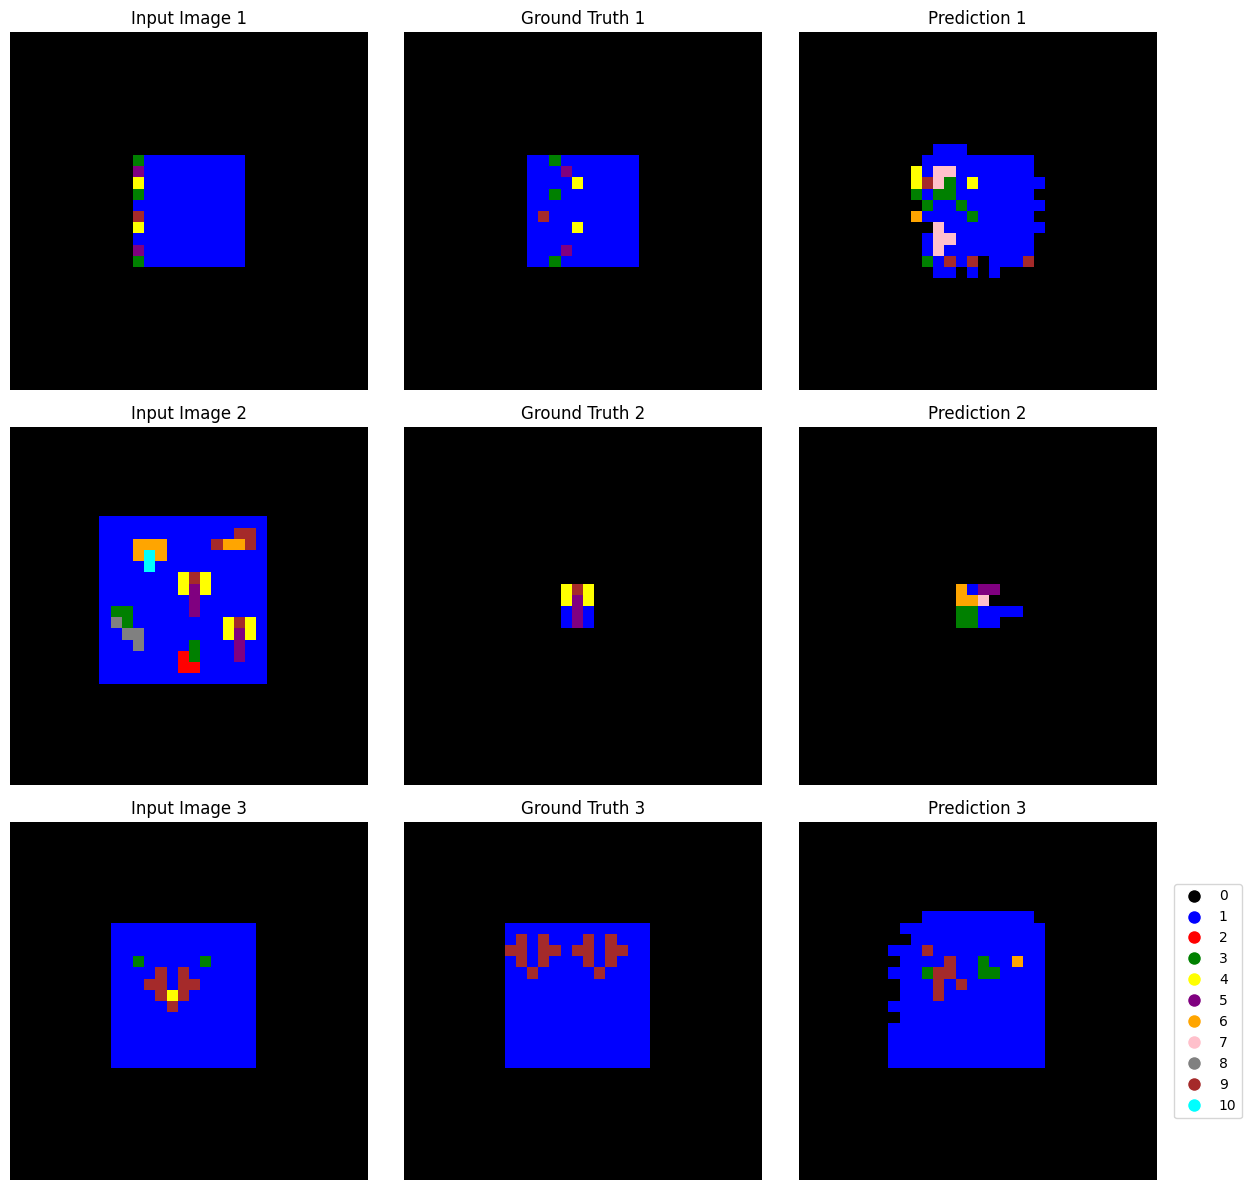

Epoch [401/1000] Complete | Average Loss: 0.016869 | Training Sample Accuracy: 7.1500% | Training Pixel Accuracy: 98.95%


Test Average Loss: 6.064205 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.93%


Epoch [402/1000] Complete | Average Loss: 0.018468 | Training Sample Accuracy: 10.3277% | Training Pixel Accuracy: 99.00%


Test Average Loss: 5.900434 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.64%


Epoch [403/1000] Complete | Average Loss: 0.017448 | Training Sample Accuracy: 9.3347% | Training Pixel Accuracy: 98.99%


Test Average Loss: 6.407313 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.09%


Epoch [404/1000] Complete | Average Loss: 0.017429 | Training Sample Accuracy: 7.8451% | Training Pixel Accuracy: 98.98%


Test Average Loss: 6.495327 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.85%


Epoch [405/1000] Complete | Average Loss: 0.017789 | Training Sample Accuracy: 8.9374% | Training Pixel Accuracy: 99.00%


Test Average Loss: 6.011850 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.94%


Epoch [406/1000] Complete | Average Loss: 0.018546 | Training Sample Accuracy: 8.2423% | Training Pixel Accuracy: 98.97%


Test Average Loss: 5.966390 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.79%


Epoch [407/1000] Complete | Average Loss: 0.025151 | Training Sample Accuracy: 7.1500% | Training Pixel Accuracy: 98.86%


Test Average Loss: 5.374792 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.52%


Epoch [408/1000] Complete | Average Loss: 0.024376 | Training Sample Accuracy: 6.1569% | Training Pixel Accuracy: 98.89%


Test Average Loss: 5.321997 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.60%


Epoch [409/1000] Complete | Average Loss: 0.022392 | Training Sample Accuracy: 5.2632% | Training Pixel Accuracy: 98.85%


Test Average Loss: 5.919440 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.89%


Epoch [410/1000] Complete | Average Loss: 0.018536 | Training Sample Accuracy: 6.8520% | Training Pixel Accuracy: 98.98%


Test Average Loss: 5.451936 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.77%


Epoch [411/1000] Complete | Average Loss: 0.019527 | Training Sample Accuracy: 5.9583% | Training Pixel Accuracy: 98.90%


Test Average Loss: 6.042070 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.90%


Epoch [412/1000] Complete | Average Loss: 0.020085 | Training Sample Accuracy: 8.3416% | Training Pixel Accuracy: 98.96%


Test Average Loss: 5.747433 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.74%


Epoch [413/1000] Complete | Average Loss: 0.020256 | Training Sample Accuracy: 6.8520% | Training Pixel Accuracy: 98.94%


Test Average Loss: 5.550942 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.75%


Epoch [414/1000] Complete | Average Loss: 0.019364 | Training Sample Accuracy: 8.2423% | Training Pixel Accuracy: 99.03%


Test Average Loss: 5.573421 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.80%


Epoch [415/1000] Complete | Average Loss: 0.021558 | Training Sample Accuracy: 9.4340% | Training Pixel Accuracy: 98.97%


Test Average Loss: 5.631479 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.88%


Epoch [416/1000] Complete | Average Loss: 0.021579 | Training Sample Accuracy: 6.4548% | Training Pixel Accuracy: 98.95%


Test Average Loss: 5.861985 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.75%


Epoch [417/1000] Complete | Average Loss: 0.022801 | Training Sample Accuracy: 6.6534% | Training Pixel Accuracy: 98.95%


Test Average Loss: 5.720797 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.81%


Epoch [418/1000] Complete | Average Loss: 0.023653 | Training Sample Accuracy: 8.0437% | Training Pixel Accuracy: 98.94%


Test Average Loss: 6.133582 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.76%


Epoch [419/1000] Complete | Average Loss: 0.022795 | Training Sample Accuracy: 8.1430% | Training Pixel Accuracy: 98.98%


Test Average Loss: 5.565567 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.71%


Epoch [420/1000] Complete | Average Loss: 0.024660 | Training Sample Accuracy: 7.9444% | Training Pixel Accuracy: 98.94%


Test Average Loss: 5.872184 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.86%


Epoch [421/1000] Complete | Average Loss: 0.035786 | Training Sample Accuracy: 6.2562% | Training Pixel Accuracy: 98.87%


Test Average Loss: 5.899052 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.54%


Epoch [422/1000] Complete | Average Loss: 0.046355 | Training Sample Accuracy: 4.0715% | Training Pixel Accuracy: 98.63%


Test Average Loss: 5.348852 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.31%


Epoch [423/1000] Complete | Average Loss: 0.086917 | Training Sample Accuracy: 2.5819% | Training Pixel Accuracy: 98.29%


Test Average Loss: 4.561636 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 88.31%


Epoch [424/1000] Complete | Average Loss: 0.091202 | Training Sample Accuracy: 1.2910% | Training Pixel Accuracy: 97.96%


Test Average Loss: 6.074847 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.46%


Epoch [425/1000] Complete | Average Loss: 0.104414 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 98.01%


Test Average Loss: 4.750983 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.02%


Epoch [426/1000] Complete | Average Loss: 0.129876 | Training Sample Accuracy: 0.3972% | Training Pixel Accuracy: 97.95%


Test Average Loss: 4.149808 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.56%


Epoch [427/1000] Complete | Average Loss: 0.212062 | Training Sample Accuracy: 0.3972% | Training Pixel Accuracy: 97.14%


Test Average Loss: 3.523059 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.09%


Epoch [428/1000] Complete | Average Loss: 0.368707 | Training Sample Accuracy: 0.6951% | Training Pixel Accuracy: 95.43%


Test Average Loss: 4.820510 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.13%


Epoch [429/1000] Complete | Average Loss: 0.248454 | Training Sample Accuracy: 0.1986% | Training Pixel Accuracy: 96.44%


Test Average Loss: 3.168912 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.34%


Epoch [430/1000] Complete | Average Loss: 0.139907 | Training Sample Accuracy: 0.4965% | Training Pixel Accuracy: 97.09%


Test Average Loss: 3.912651 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.44%


Epoch [431/1000] Complete | Average Loss: 0.084397 | Training Sample Accuracy: 1.3903% | Training Pixel Accuracy: 98.00%


Test Average Loss: 3.678225 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.02%


Epoch [432/1000] Complete | Average Loss: 0.060556 | Training Sample Accuracy: 1.1917% | Training Pixel Accuracy: 97.90%


Test Average Loss: 3.756203 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.83%


Epoch [433/1000] Complete | Average Loss: 0.045336 | Training Sample Accuracy: 2.1847% | Training Pixel Accuracy: 98.26%


Test Average Loss: 4.624364 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.73%


Epoch [434/1000] Complete | Average Loss: 0.031506 | Training Sample Accuracy: 3.3764% | Training Pixel Accuracy: 98.59%


Test Average Loss: 4.453097 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.66%


Epoch [435/1000] Complete | Average Loss: 0.026315 | Training Sample Accuracy: 2.9791% | Training Pixel Accuracy: 98.64%


Test Average Loss: 4.681919 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.93%


Epoch [436/1000] Complete | Average Loss: 0.021046 | Training Sample Accuracy: 6.0576% | Training Pixel Accuracy: 98.80%


Test Average Loss: 5.418370 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.27%


Epoch [437/1000] Complete | Average Loss: 0.017976 | Training Sample Accuracy: 6.3555% | Training Pixel Accuracy: 98.88%


Test Average Loss: 5.235914 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.17%


Epoch [438/1000] Complete | Average Loss: 0.017300 | Training Sample Accuracy: 7.6465% | Training Pixel Accuracy: 98.89%


Test Average Loss: 5.328603 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [439/1000] Complete | Average Loss: 0.015520 | Training Sample Accuracy: 6.6534% | Training Pixel Accuracy: 98.95%


Test Average Loss: 5.753486 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.38%


Epoch [440/1000] Complete | Average Loss: 0.014789 | Training Sample Accuracy: 7.4479% | Training Pixel Accuracy: 98.98%


Test Average Loss: 5.656713 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [441/1000] Complete | Average Loss: 0.013302 | Training Sample Accuracy: 8.7388% | Training Pixel Accuracy: 99.01%


Test Average Loss: 5.744986 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.35%


Epoch [442/1000] Complete | Average Loss: 0.013702 | Training Sample Accuracy: 7.3486% | Training Pixel Accuracy: 99.02%


Test Average Loss: 5.742206 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.20%


Epoch [443/1000] Complete | Average Loss: 0.012971 | Training Sample Accuracy: 7.5472% | Training Pixel Accuracy: 98.99%


Test Average Loss: 5.481021 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [444/1000] Complete | Average Loss: 0.012486 | Training Sample Accuracy: 8.6395% | Training Pixel Accuracy: 99.06%


Test Average Loss: 5.867308 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [445/1000] Complete | Average Loss: 0.012095 | Training Sample Accuracy: 8.2423% | Training Pixel Accuracy: 99.07%


Test Average Loss: 5.988596 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.41%


Epoch [446/1000] Complete | Average Loss: 0.012559 | Training Sample Accuracy: 8.5402% | Training Pixel Accuracy: 99.10%


Test Average Loss: 6.111387 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.39%


Epoch [447/1000] Complete | Average Loss: 0.011597 | Training Sample Accuracy: 8.2423% | Training Pixel Accuracy: 99.08%


Test Average Loss: 5.738113 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.26%


Epoch [448/1000] Complete | Average Loss: 0.012270 | Training Sample Accuracy: 7.8451% | Training Pixel Accuracy: 99.07%


Test Average Loss: 5.757993 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.35%


Epoch [449/1000] Complete | Average Loss: 0.012892 | Training Sample Accuracy: 11.6187% | Training Pixel Accuracy: 99.10%


Test Average Loss: 5.903477 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.48%


Epoch [450/1000] Complete | Average Loss: 0.012295 | Training Sample Accuracy: 10.9235% | Training Pixel Accuracy: 99.08%


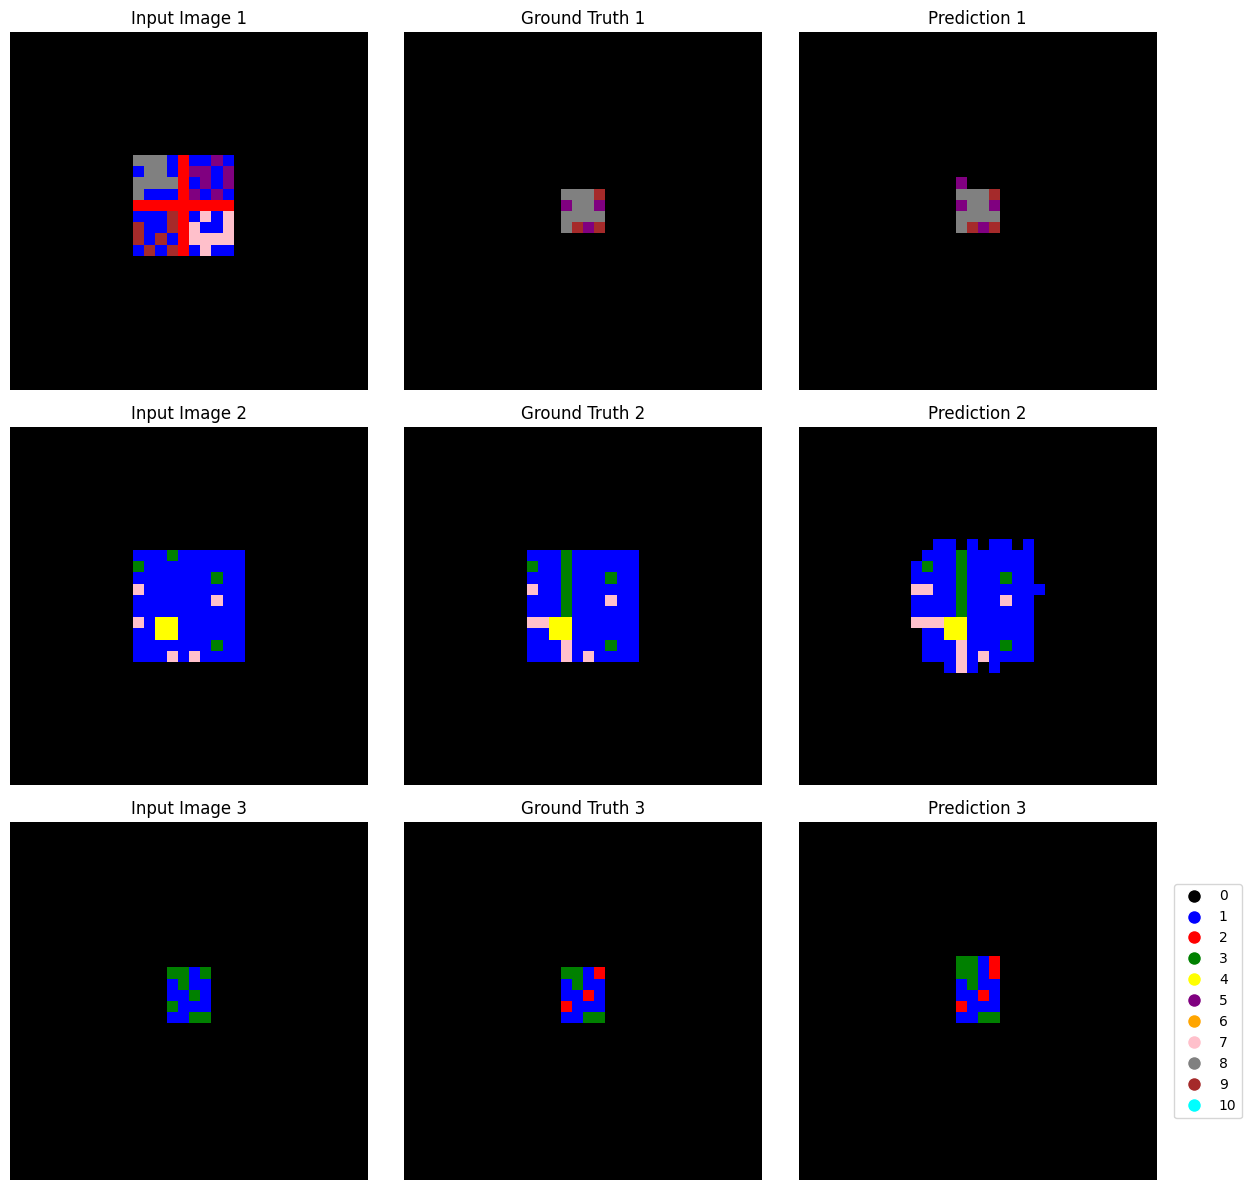

Test Average Loss: 5.751823 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.22%


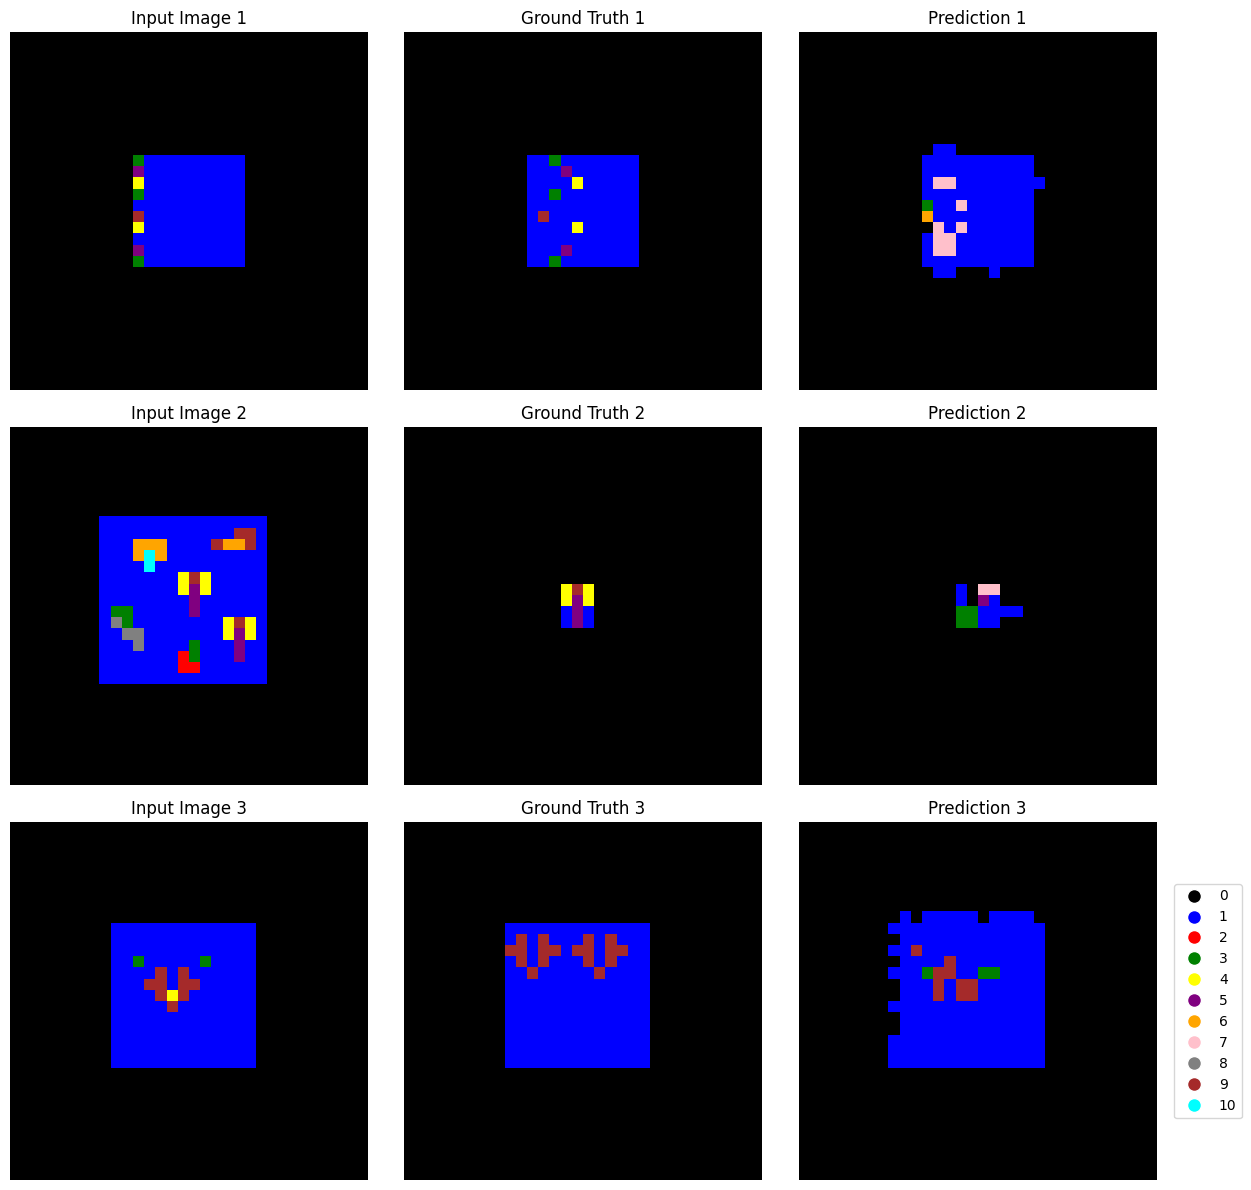

Epoch [451/1000] Complete | Average Loss: 0.011578 | Training Sample Accuracy: 11.6187% | Training Pixel Accuracy: 99.14%


Test Average Loss: 6.165144 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.40%


Epoch [452/1000] Complete | Average Loss: 0.011130 | Training Sample Accuracy: 11.4201% | Training Pixel Accuracy: 99.14%


Test Average Loss: 6.006068 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.46%


Epoch [453/1000] Complete | Average Loss: 0.010901 | Training Sample Accuracy: 11.7180% | Training Pixel Accuracy: 99.15%


Test Average Loss: 6.293772 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.34%


Epoch [454/1000] Complete | Average Loss: 0.010039 | Training Sample Accuracy: 13.7041% | Training Pixel Accuracy: 99.18%


Test Average Loss: 6.009515 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [455/1000] Complete | Average Loss: 0.010061 | Training Sample Accuracy: 10.6256% | Training Pixel Accuracy: 99.15%


Test Average Loss: 6.081857 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.20%


Epoch [456/1000] Complete | Average Loss: 0.009893 | Training Sample Accuracy: 12.7110% | Training Pixel Accuracy: 99.18%


Test Average Loss: 6.275592 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [457/1000] Complete | Average Loss: 0.010036 | Training Sample Accuracy: 12.9096% | Training Pixel Accuracy: 99.24%


Test Average Loss: 6.411126 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.44%


Epoch [458/1000] Complete | Average Loss: 0.010757 | Training Sample Accuracy: 13.1082% | Training Pixel Accuracy: 99.20%


Test Average Loss: 6.273813 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.35%


Epoch [459/1000] Complete | Average Loss: 0.010188 | Training Sample Accuracy: 12.5124% | Training Pixel Accuracy: 99.22%


Test Average Loss: 6.280274 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.40%


Epoch [460/1000] Complete | Average Loss: 0.009963 | Training Sample Accuracy: 11.0228% | Training Pixel Accuracy: 99.22%


Test Average Loss: 6.427746 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.38%


Epoch [461/1000] Complete | Average Loss: 0.010349 | Training Sample Accuracy: 11.8173% | Training Pixel Accuracy: 99.19%


Test Average Loss: 6.477985 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.40%


Epoch [462/1000] Complete | Average Loss: 0.010646 | Training Sample Accuracy: 12.3138% | Training Pixel Accuracy: 99.15%


Test Average Loss: 5.858210 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.41%


Epoch [463/1000] Complete | Average Loss: 0.011063 | Training Sample Accuracy: 15.0943% | Training Pixel Accuracy: 99.20%


Test Average Loss: 6.285132 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.35%


Epoch [464/1000] Complete | Average Loss: 0.010942 | Training Sample Accuracy: 13.6048% | Training Pixel Accuracy: 99.17%


Test Average Loss: 6.236562 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.31%


Epoch [465/1000] Complete | Average Loss: 0.010708 | Training Sample Accuracy: 11.1221% | Training Pixel Accuracy: 99.20%


Test Average Loss: 6.101968 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.16%


Epoch [466/1000] Complete | Average Loss: 0.009936 | Training Sample Accuracy: 14.6971% | Training Pixel Accuracy: 99.24%


Test Average Loss: 6.741726 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.42%


Epoch [467/1000] Complete | Average Loss: 0.010419 | Training Sample Accuracy: 13.6048% | Training Pixel Accuracy: 99.22%


Test Average Loss: 6.002381 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.41%


Epoch [468/1000] Complete | Average Loss: 0.011491 | Training Sample Accuracy: 11.5194% | Training Pixel Accuracy: 99.20%


Test Average Loss: 6.476874 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [469/1000] Complete | Average Loss: 0.011152 | Training Sample Accuracy: 12.5124% | Training Pixel Accuracy: 99.21%


Test Average Loss: 6.279680 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [470/1000] Complete | Average Loss: 0.011955 | Training Sample Accuracy: 12.1152% | Training Pixel Accuracy: 99.20%


Test Average Loss: 5.914121 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.19%


Epoch [471/1000] Complete | Average Loss: 0.011885 | Training Sample Accuracy: 12.1152% | Training Pixel Accuracy: 99.15%


Test Average Loss: 6.203774 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.19%


Epoch [472/1000] Complete | Average Loss: 0.014638 | Training Sample Accuracy: 9.1360% | Training Pixel Accuracy: 99.09%


Test Average Loss: 5.759808 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.03%


Epoch [473/1000] Complete | Average Loss: 0.014422 | Training Sample Accuracy: 12.2145% | Training Pixel Accuracy: 99.15%


Test Average Loss: 5.874715 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.11%


Epoch [474/1000] Complete | Average Loss: 0.014216 | Training Sample Accuracy: 10.2284% | Training Pixel Accuracy: 99.12%


Test Average Loss: 5.793213 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.08%


Epoch [475/1000] Complete | Average Loss: 0.014180 | Training Sample Accuracy: 10.8242% | Training Pixel Accuracy: 99.15%


Test Average Loss: 6.201023 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.24%


Epoch [476/1000] Complete | Average Loss: 0.013415 | Training Sample Accuracy: 10.1291% | Training Pixel Accuracy: 99.18%


Test Average Loss: 6.133037 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.10%


Epoch [477/1000] Complete | Average Loss: 0.014304 | Training Sample Accuracy: 11.5194% | Training Pixel Accuracy: 99.15%


Test Average Loss: 6.578060 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.29%


Epoch [478/1000] Complete | Average Loss: 0.015511 | Training Sample Accuracy: 9.4340% | Training Pixel Accuracy: 99.11%


Test Average Loss: 6.451401 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [479/1000] Complete | Average Loss: 0.014662 | Training Sample Accuracy: 10.2284% | Training Pixel Accuracy: 99.11%


Test Average Loss: 6.515525 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.30%


Epoch [480/1000] Complete | Average Loss: 0.014740 | Training Sample Accuracy: 9.7319% | Training Pixel Accuracy: 99.14%


Test Average Loss: 6.098149 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.15%


Epoch [481/1000] Complete | Average Loss: 0.013425 | Training Sample Accuracy: 10.1291% | Training Pixel Accuracy: 99.18%


Test Average Loss: 5.639880 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.11%


Epoch [482/1000] Complete | Average Loss: 0.012524 | Training Sample Accuracy: 11.6187% | Training Pixel Accuracy: 99.21%


Test Average Loss: 6.034422 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.25%


Epoch [483/1000] Complete | Average Loss: 0.011316 | Training Sample Accuracy: 12.4131% | Training Pixel Accuracy: 99.20%


Test Average Loss: 5.869039 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.14%


Epoch [484/1000] Complete | Average Loss: 0.011651 | Training Sample Accuracy: 12.9096% | Training Pixel Accuracy: 99.24%


Test Average Loss: 6.102581 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [485/1000] Complete | Average Loss: 0.011574 | Training Sample Accuracy: 11.4201% | Training Pixel Accuracy: 99.21%


Test Average Loss: 6.929877 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.41%


Epoch [486/1000] Complete | Average Loss: 0.013013 | Training Sample Accuracy: 10.4270% | Training Pixel Accuracy: 99.19%


Test Average Loss: 6.597005 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.33%


Epoch [487/1000] Complete | Average Loss: 0.011850 | Training Sample Accuracy: 11.2214% | Training Pixel Accuracy: 99.24%


Test Average Loss: 6.088083 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [488/1000] Complete | Average Loss: 0.011354 | Training Sample Accuracy: 11.3208% | Training Pixel Accuracy: 99.24%


Test Average Loss: 6.497074 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [489/1000] Complete | Average Loss: 0.011315 | Training Sample Accuracy: 10.6256% | Training Pixel Accuracy: 99.20%


Test Average Loss: 6.126779 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.12%


Epoch [490/1000] Complete | Average Loss: 0.010692 | Training Sample Accuracy: 13.8034% | Training Pixel Accuracy: 99.23%


Test Average Loss: 6.419843 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.21%


Epoch [491/1000] Complete | Average Loss: 0.010599 | Training Sample Accuracy: 14.9950% | Training Pixel Accuracy: 99.27%


Test Average Loss: 6.519822 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.33%


Epoch [492/1000] Complete | Average Loss: 0.016688 | Training Sample Accuracy: 10.6256% | Training Pixel Accuracy: 99.16%


Test Average Loss: 6.101167 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.19%


Epoch [493/1000] Complete | Average Loss: 0.017867 | Training Sample Accuracy: 9.4340% | Training Pixel Accuracy: 99.11%


Test Average Loss: 6.059494 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.96%


Epoch [494/1000] Complete | Average Loss: 0.017293 | Training Sample Accuracy: 6.3555% | Training Pixel Accuracy: 99.06%


Test Average Loss: 6.611481 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.27%


Epoch [495/1000] Complete | Average Loss: 0.015126 | Training Sample Accuracy: 8.0437% | Training Pixel Accuracy: 99.13%


Test Average Loss: 5.710947 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.04%


Epoch [496/1000] Complete | Average Loss: 0.015063 | Training Sample Accuracy: 10.9235% | Training Pixel Accuracy: 99.17%


Test Average Loss: 6.677391 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.26%


Epoch [497/1000] Complete | Average Loss: 0.018799 | Training Sample Accuracy: 8.4409% | Training Pixel Accuracy: 99.13%


Test Average Loss: 6.542079 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.03%


Epoch [498/1000] Complete | Average Loss: 0.022385 | Training Sample Accuracy: 10.7249% | Training Pixel Accuracy: 99.08%


Test Average Loss: 5.706502 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.14%


Epoch [499/1000] Complete | Average Loss: 0.031165 | Training Sample Accuracy: 9.0367% | Training Pixel Accuracy: 99.00%


Test Average Loss: 5.166195 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.09%


Epoch [500/1000] Complete | Average Loss: 0.045262 | Training Sample Accuracy: 3.4757% | Training Pixel Accuracy: 98.60%


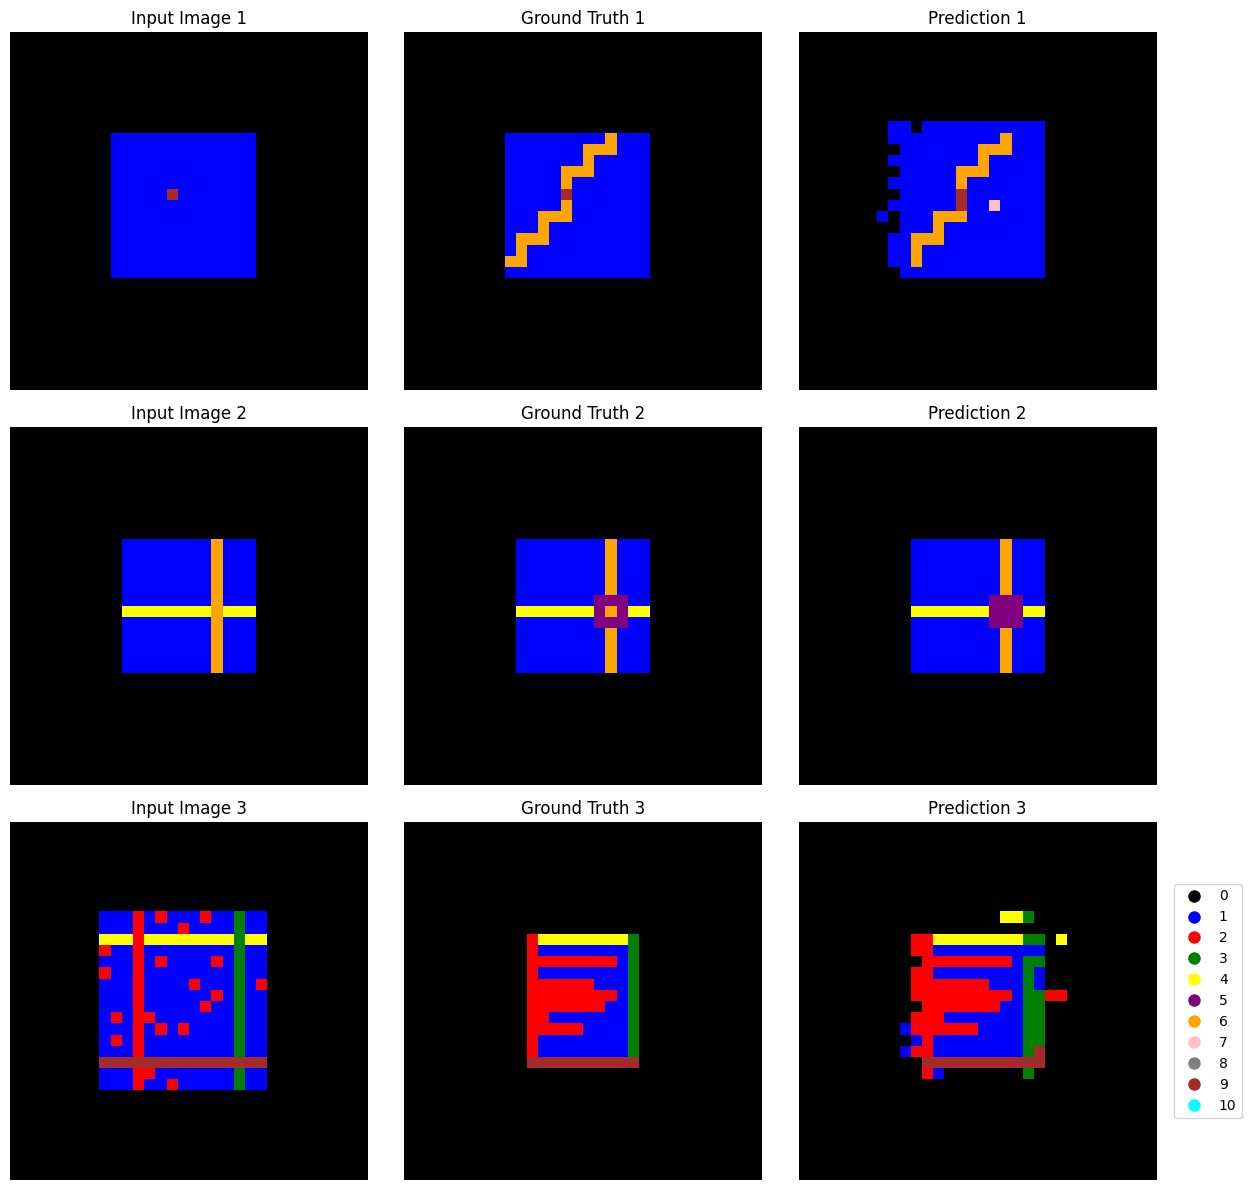

Test Average Loss: 5.325015 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.83%


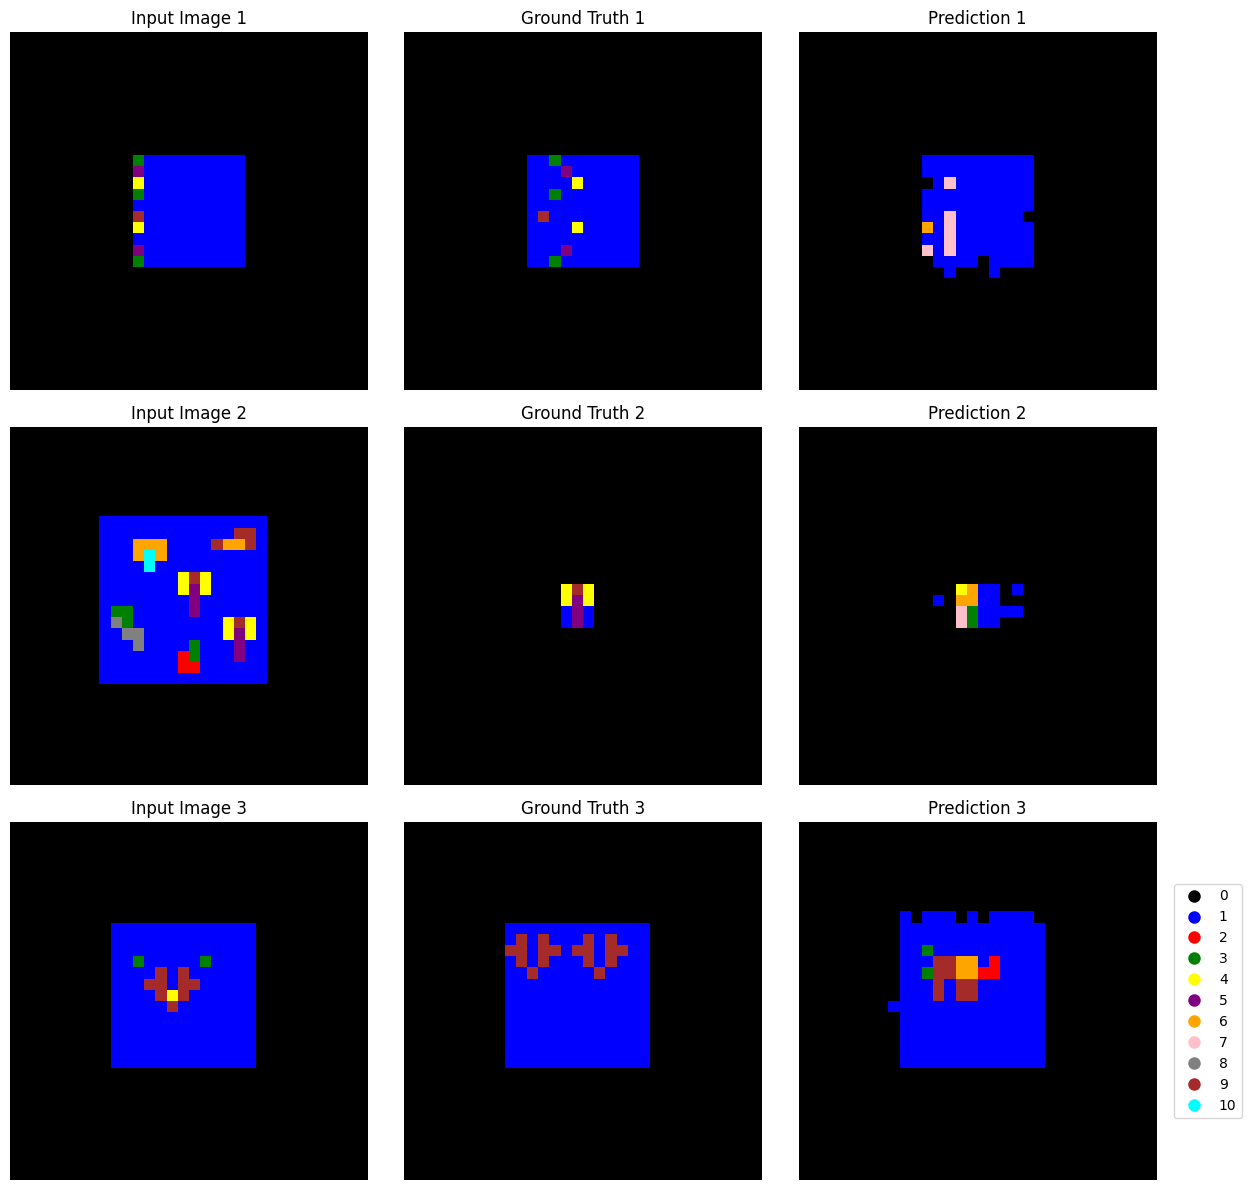

Epoch [501/1000] Complete | Average Loss: 0.039403 | Training Sample Accuracy: 4.0715% | Training Pixel Accuracy: 98.75%


Test Average Loss: 6.130952 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.58%


Epoch [502/1000] Complete | Average Loss: 0.035172 | Training Sample Accuracy: 6.0576% | Training Pixel Accuracy: 98.86%


Test Average Loss: 5.049785 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.75%


Epoch [503/1000] Complete | Average Loss: 0.034922 | Training Sample Accuracy: 5.1639% | Training Pixel Accuracy: 98.88%


Test Average Loss: 5.268670 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.76%


Epoch [504/1000] Complete | Average Loss: 0.033889 | Training Sample Accuracy: 5.7597% | Training Pixel Accuracy: 98.83%


Test Average Loss: 5.332514 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.75%


Epoch [505/1000] Complete | Average Loss: 0.035225 | Training Sample Accuracy: 5.5611% | Training Pixel Accuracy: 98.85%


Test Average Loss: 5.225070 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.66%


Epoch [506/1000] Complete | Average Loss: 0.029639 | Training Sample Accuracy: 3.1778% | Training Pixel Accuracy: 98.75%


Test Average Loss: 5.310122 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.77%


Epoch [507/1000] Complete | Average Loss: 0.024920 | Training Sample Accuracy: 5.9583% | Training Pixel Accuracy: 98.86%


Test Average Loss: 5.608032 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.58%


Epoch [508/1000] Complete | Average Loss: 0.020560 | Training Sample Accuracy: 6.7527% | Training Pixel Accuracy: 98.91%


Test Average Loss: 5.625152 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.73%


Epoch [509/1000] Complete | Average Loss: 0.019625 | Training Sample Accuracy: 7.7458% | Training Pixel Accuracy: 99.02%


Test Average Loss: 5.374892 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.82%


Epoch [510/1000] Complete | Average Loss: 0.016155 | Training Sample Accuracy: 6.9513% | Training Pixel Accuracy: 99.04%


Test Average Loss: 5.988374 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.92%


Epoch [511/1000] Complete | Average Loss: 0.014799 | Training Sample Accuracy: 11.4201% | Training Pixel Accuracy: 99.13%


Test Average Loss: 6.378166 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.13%


Epoch [512/1000] Complete | Average Loss: 0.014284 | Training Sample Accuracy: 10.8242% | Training Pixel Accuracy: 99.14%


Test Average Loss: 5.915616 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.01%


Epoch [513/1000] Complete | Average Loss: 0.013228 | Training Sample Accuracy: 10.3277% | Training Pixel Accuracy: 99.16%


Test Average Loss: 5.957844 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.98%


Epoch [514/1000] Complete | Average Loss: 0.012551 | Training Sample Accuracy: 12.6117% | Training Pixel Accuracy: 99.20%


Test Average Loss: 6.312701 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.09%


Epoch [515/1000] Complete | Average Loss: 0.010727 | Training Sample Accuracy: 11.2214% | Training Pixel Accuracy: 99.17%


Test Average Loss: 5.828905 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.20%


Epoch [516/1000] Complete | Average Loss: 0.010506 | Training Sample Accuracy: 12.0159% | Training Pixel Accuracy: 99.21%


Test Average Loss: 5.846205 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [517/1000] Complete | Average Loss: 0.010269 | Training Sample Accuracy: 13.8034% | Training Pixel Accuracy: 99.23%


Test Average Loss: 6.030498 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.13%


Epoch [518/1000] Complete | Average Loss: 0.011551 | Training Sample Accuracy: 13.2075% | Training Pixel Accuracy: 99.25%


Test Average Loss: 6.594049 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.14%


Epoch [519/1000] Complete | Average Loss: 0.011600 | Training Sample Accuracy: 14.4985% | Training Pixel Accuracy: 99.25%


Test Average Loss: 6.079914 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.00%


Epoch [520/1000] Complete | Average Loss: 0.013732 | Training Sample Accuracy: 13.1082% | Training Pixel Accuracy: 99.25%


Test Average Loss: 6.435522 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.07%


Epoch [521/1000] Complete | Average Loss: 0.014144 | Training Sample Accuracy: 12.7110% | Training Pixel Accuracy: 99.20%


Test Average Loss: 6.439442 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [522/1000] Complete | Average Loss: 0.036948 | Training Sample Accuracy: 12.8103% | Training Pixel Accuracy: 99.21%


Test Average Loss: 5.379362 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.75%


Epoch [523/1000] Complete | Average Loss: 0.117371 | Training Sample Accuracy: 3.3764% | Training Pixel Accuracy: 98.26%


Test Average Loss: 4.563931 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.54%


Epoch [524/1000] Complete | Average Loss: 0.140548 | Training Sample Accuracy: 1.1917% | Training Pixel Accuracy: 97.64%


Test Average Loss: 4.129257 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.45%


Epoch [525/1000] Complete | Average Loss: 0.108042 | Training Sample Accuracy: 0.9930% | Training Pixel Accuracy: 98.01%


Test Average Loss: 4.877150 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.45%


Epoch [526/1000] Complete | Average Loss: 0.085558 | Training Sample Accuracy: 1.7875% | Training Pixel Accuracy: 98.02%


Test Average Loss: 4.054547 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.06%


Epoch [527/1000] Complete | Average Loss: 0.059694 | Training Sample Accuracy: 3.1778% | Training Pixel Accuracy: 98.27%


Test Average Loss: 4.664144 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.31%


Epoch [528/1000] Complete | Average Loss: 0.044847 | Training Sample Accuracy: 3.3764% | Training Pixel Accuracy: 98.54%


Test Average Loss: 4.472243 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.25%


Epoch [529/1000] Complete | Average Loss: 0.033463 | Training Sample Accuracy: 3.5750% | Training Pixel Accuracy: 98.67%


Test Average Loss: 4.873900 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.64%


Epoch [530/1000] Complete | Average Loss: 0.025066 | Training Sample Accuracy: 5.9583% | Training Pixel Accuracy: 98.89%


Test Average Loss: 5.053615 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.73%


Epoch [531/1000] Complete | Average Loss: 0.018996 | Training Sample Accuracy: 9.2354% | Training Pixel Accuracy: 99.00%


Test Average Loss: 5.232663 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.80%


Epoch [532/1000] Complete | Average Loss: 0.018126 | Training Sample Accuracy: 6.7527% | Training Pixel Accuracy: 99.00%


Test Average Loss: 5.372181 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.92%


Epoch [533/1000] Complete | Average Loss: 0.015570 | Training Sample Accuracy: 10.3277% | Training Pixel Accuracy: 99.05%


Test Average Loss: 5.181028 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.96%


Epoch [534/1000] Complete | Average Loss: 0.012151 | Training Sample Accuracy: 10.8242% | Training Pixel Accuracy: 99.10%


Test Average Loss: 5.668490 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.14%


Epoch [535/1000] Complete | Average Loss: 0.010436 | Training Sample Accuracy: 13.1082% | Training Pixel Accuracy: 99.19%


Test Average Loss: 5.261485 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.02%


Epoch [536/1000] Complete | Average Loss: 0.010030 | Training Sample Accuracy: 11.4201% | Training Pixel Accuracy: 99.19%


Test Average Loss: 6.032760 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.19%


Epoch [537/1000] Complete | Average Loss: 0.010218 | Training Sample Accuracy: 14.2999% | Training Pixel Accuracy: 99.23%


Test Average Loss: 5.952978 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.16%


Epoch [538/1000] Complete | Average Loss: 0.009218 | Training Sample Accuracy: 14.3992% | Training Pixel Accuracy: 99.22%


Test Average Loss: 6.056214 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [539/1000] Complete | Average Loss: 0.008760 | Training Sample Accuracy: 13.6048% | Training Pixel Accuracy: 99.24%


Test Average Loss: 5.914956 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.16%


Epoch [540/1000] Complete | Average Loss: 0.008935 | Training Sample Accuracy: 14.4985% | Training Pixel Accuracy: 99.28%


Test Average Loss: 6.422733 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.25%


Epoch [541/1000] Complete | Average Loss: 0.008121 | Training Sample Accuracy: 13.9027% | Training Pixel Accuracy: 99.28%


Test Average Loss: 6.098588 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.15%


Epoch [542/1000] Complete | Average Loss: 0.008675 | Training Sample Accuracy: 14.4985% | Training Pixel Accuracy: 99.30%


Test Average Loss: 6.000808 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.07%


Epoch [543/1000] Complete | Average Loss: 0.008517 | Training Sample Accuracy: 16.3853% | Training Pixel Accuracy: 99.29%


Test Average Loss: 6.529163 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [544/1000] Complete | Average Loss: 0.008899 | Training Sample Accuracy: 15.3923% | Training Pixel Accuracy: 99.27%


Test Average Loss: 6.180813 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.17%


Epoch [545/1000] Complete | Average Loss: 0.008767 | Training Sample Accuracy: 15.1936% | Training Pixel Accuracy: 99.31%


Test Average Loss: 6.448073 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [546/1000] Complete | Average Loss: 0.007806 | Training Sample Accuracy: 14.5978% | Training Pixel Accuracy: 99.30%


Test Average Loss: 6.300437 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.28%


Epoch [547/1000] Complete | Average Loss: 0.008371 | Training Sample Accuracy: 14.8957% | Training Pixel Accuracy: 99.31%


Test Average Loss: 6.352927 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.35%


Epoch [548/1000] Complete | Average Loss: 0.008620 | Training Sample Accuracy: 14.9950% | Training Pixel Accuracy: 99.34%


Test Average Loss: 6.218210 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.09%


Epoch [549/1000] Complete | Average Loss: 0.008403 | Training Sample Accuracy: 14.3992% | Training Pixel Accuracy: 99.31%


Test Average Loss: 6.129848 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.17%


Epoch [550/1000] Complete | Average Loss: 0.008505 | Training Sample Accuracy: 13.3069% | Training Pixel Accuracy: 99.32%


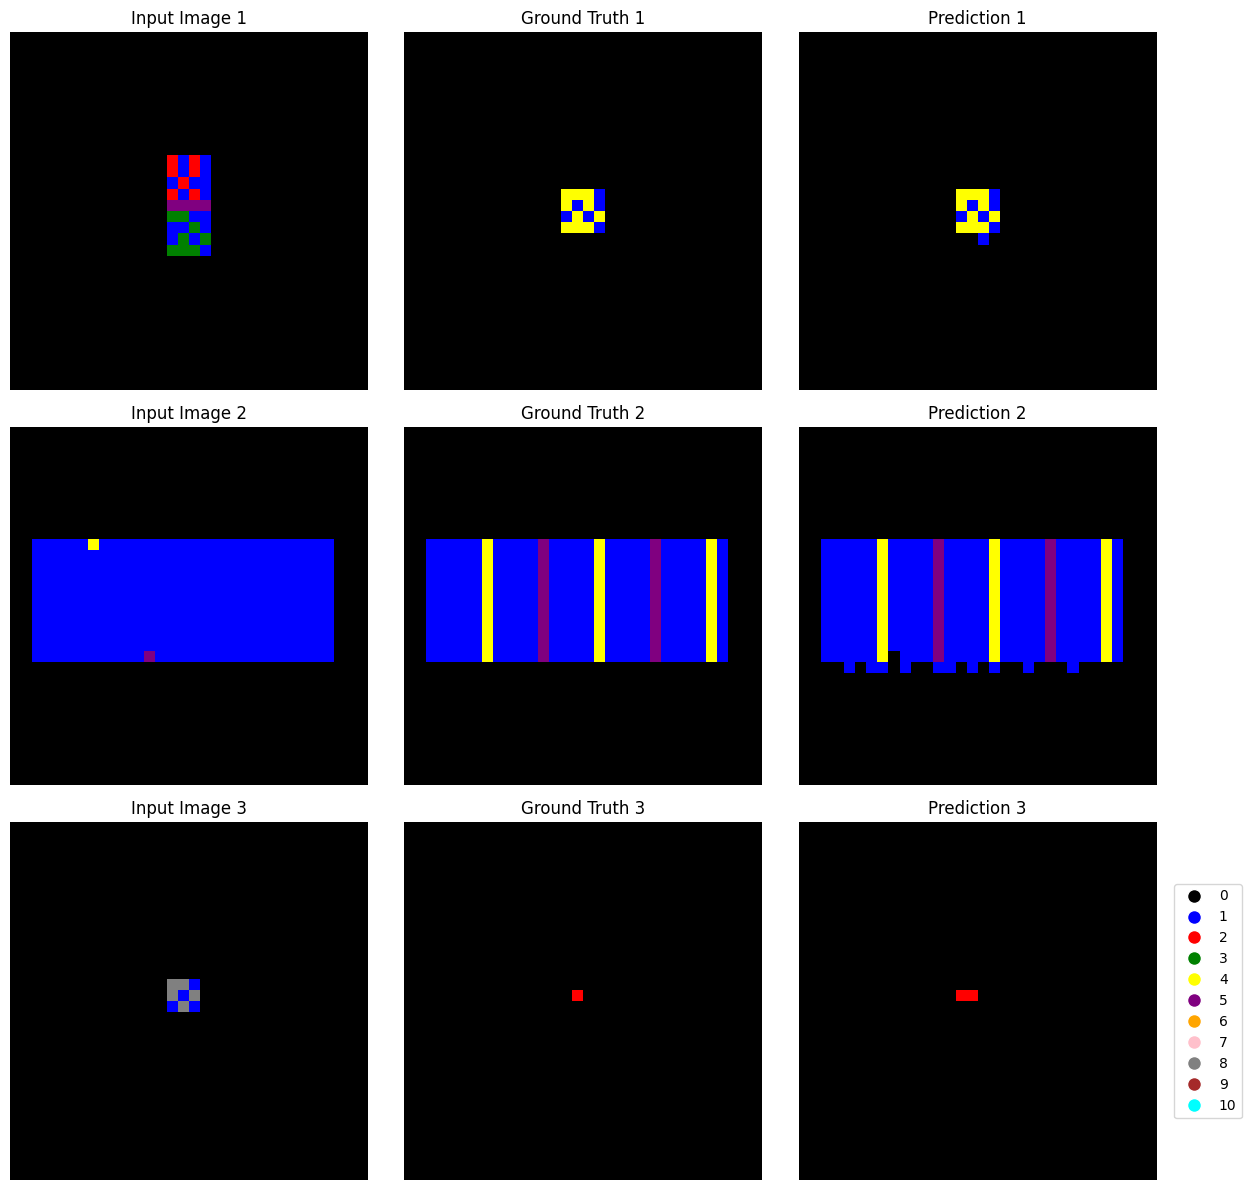

Test Average Loss: 5.946187 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.13%


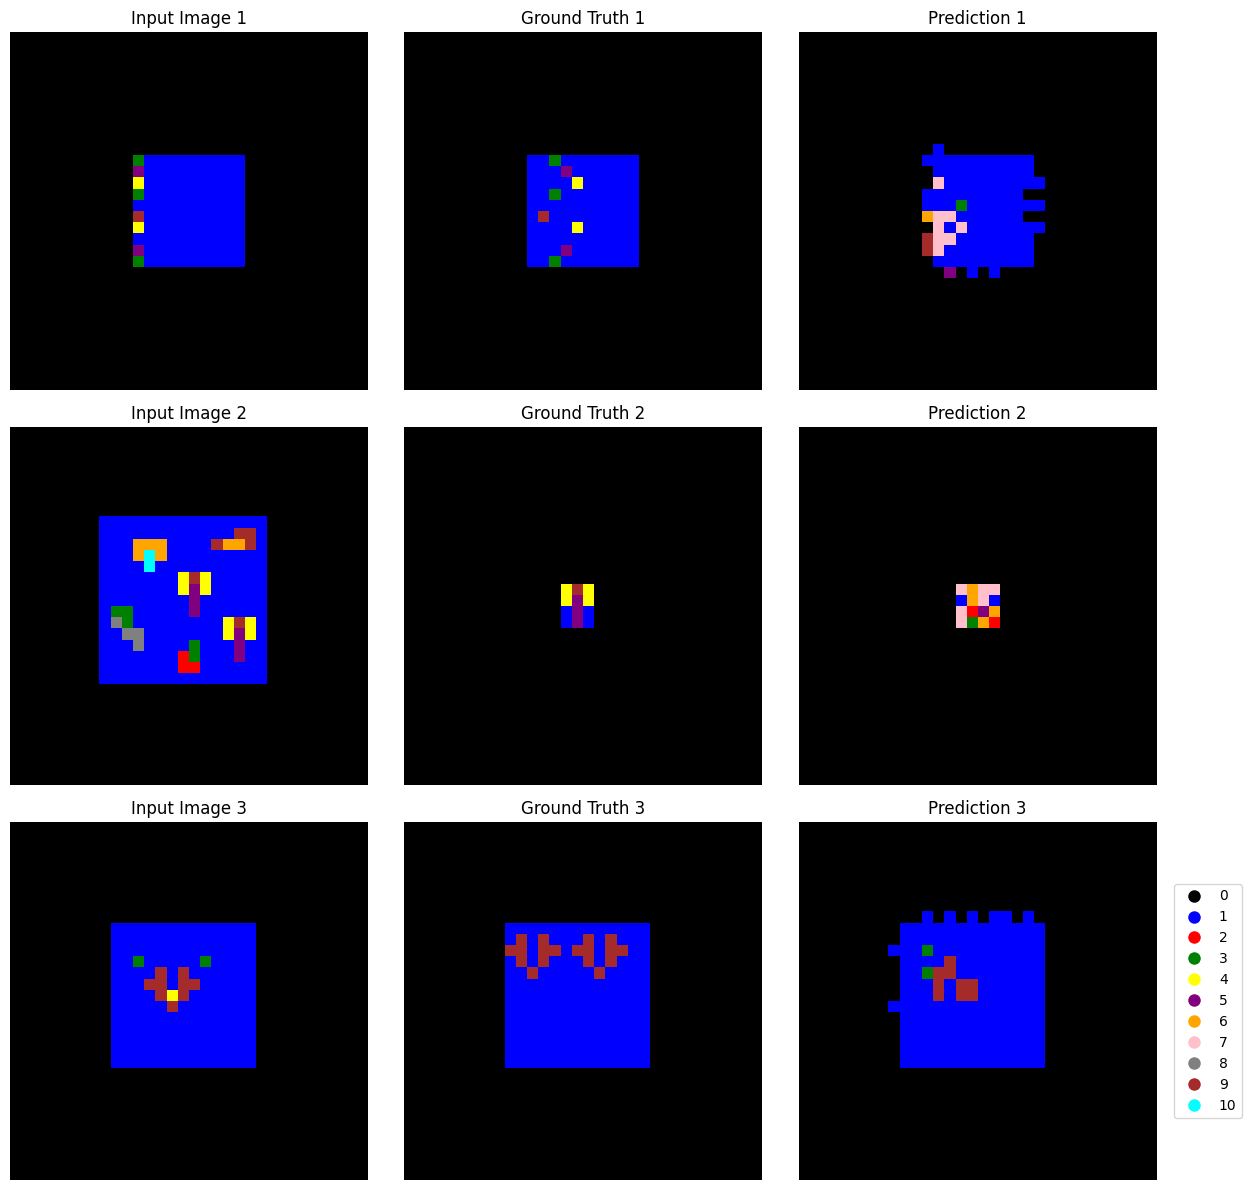

Epoch [551/1000] Complete | Average Loss: 0.007688 | Training Sample Accuracy: 17.3784% | Training Pixel Accuracy: 99.33%


Test Average Loss: 6.293739 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.13%


Epoch [552/1000] Complete | Average Loss: 0.007672 | Training Sample Accuracy: 15.7895% | Training Pixel Accuracy: 99.36%


Test Average Loss: 6.467755 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.35%


Epoch [553/1000] Complete | Average Loss: 0.010138 | Training Sample Accuracy: 15.2929% | Training Pixel Accuracy: 99.35%


Test Average Loss: 6.357322 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [554/1000] Complete | Average Loss: 0.009839 | Training Sample Accuracy: 16.8818% | Training Pixel Accuracy: 99.32%


Test Average Loss: 6.286630 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.22%


Epoch [555/1000] Complete | Average Loss: 0.009932 | Training Sample Accuracy: 13.9027% | Training Pixel Accuracy: 99.32%


Test Average Loss: 6.044073 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.10%


Epoch [556/1000] Complete | Average Loss: 0.009891 | Training Sample Accuracy: 15.8888% | Training Pixel Accuracy: 99.30%


Test Average Loss: 6.519423 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.18%


Epoch [557/1000] Complete | Average Loss: 0.009376 | Training Sample Accuracy: 15.1936% | Training Pixel Accuracy: 99.30%


Test Average Loss: 5.975441 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.22%


Epoch [558/1000] Complete | Average Loss: 0.009960 | Training Sample Accuracy: 14.4985% | Training Pixel Accuracy: 99.30%


Test Average Loss: 6.803445 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.21%


Epoch [559/1000] Complete | Average Loss: 0.009320 | Training Sample Accuracy: 15.0943% | Training Pixel Accuracy: 99.33%


Test Average Loss: 6.676818 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.33%


Epoch [560/1000] Complete | Average Loss: 0.009687 | Training Sample Accuracy: 16.5839% | Training Pixel Accuracy: 99.34%


Test Average Loss: 5.846159 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.10%


Epoch [561/1000] Complete | Average Loss: 0.010108 | Training Sample Accuracy: 13.5055% | Training Pixel Accuracy: 99.29%


Test Average Loss: 6.222955 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.18%


Epoch [562/1000] Complete | Average Loss: 0.010341 | Training Sample Accuracy: 14.3992% | Training Pixel Accuracy: 99.30%


Test Average Loss: 6.505739 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.09%


Epoch [563/1000] Complete | Average Loss: 0.013425 | Training Sample Accuracy: 12.2145% | Training Pixel Accuracy: 99.28%


Test Average Loss: 6.925944 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.34%


Epoch [564/1000] Complete | Average Loss: 0.020348 | Training Sample Accuracy: 11.5194% | Training Pixel Accuracy: 99.14%


Test Average Loss: 6.265824 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.30%


Epoch [565/1000] Complete | Average Loss: 0.019774 | Training Sample Accuracy: 12.8103% | Training Pixel Accuracy: 99.16%


Test Average Loss: 6.514909 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [566/1000] Complete | Average Loss: 0.021402 | Training Sample Accuracy: 7.7458% | Training Pixel Accuracy: 99.11%


Test Average Loss: 5.695357 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.45%


Epoch [567/1000] Complete | Average Loss: 0.022548 | Training Sample Accuracy: 12.1152% | Training Pixel Accuracy: 99.11%


Test Average Loss: 5.322858 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.92%


Epoch [568/1000] Complete | Average Loss: 0.023856 | Training Sample Accuracy: 9.2354% | Training Pixel Accuracy: 99.08%


Test Average Loss: 5.905600 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.83%


Epoch [569/1000] Complete | Average Loss: 0.020352 | Training Sample Accuracy: 9.9305% | Training Pixel Accuracy: 99.10%


Test Average Loss: 5.871843 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.88%


Epoch [570/1000] Complete | Average Loss: 0.017592 | Training Sample Accuracy: 11.7180% | Training Pixel Accuracy: 99.14%


Test Average Loss: 5.391813 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.92%


Epoch [571/1000] Complete | Average Loss: 0.015410 | Training Sample Accuracy: 10.1291% | Training Pixel Accuracy: 99.16%


Test Average Loss: 6.452475 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.03%


Epoch [572/1000] Complete | Average Loss: 0.015636 | Training Sample Accuracy: 11.2214% | Training Pixel Accuracy: 99.24%


Test Average Loss: 6.237990 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.05%


Epoch [573/1000] Complete | Average Loss: 0.015189 | Training Sample Accuracy: 9.1360% | Training Pixel Accuracy: 99.15%


Test Average Loss: 6.024950 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.02%


Epoch [574/1000] Complete | Average Loss: 0.014078 | Training Sample Accuracy: 9.8312% | Training Pixel Accuracy: 99.19%


Test Average Loss: 5.067582 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.86%


Epoch [575/1000] Complete | Average Loss: 0.015342 | Training Sample Accuracy: 8.2423% | Training Pixel Accuracy: 99.11%


Test Average Loss: 6.334515 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.11%


Epoch [576/1000] Complete | Average Loss: 0.019409 | Training Sample Accuracy: 8.6395% | Training Pixel Accuracy: 99.16%


Test Average Loss: 6.292026 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.27%


Epoch [577/1000] Complete | Average Loss: 0.025605 | Training Sample Accuracy: 8.5402% | Training Pixel Accuracy: 99.07%


Test Average Loss: 6.388945 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.66%


Epoch [578/1000] Complete | Average Loss: 0.036430 | Training Sample Accuracy: 4.8659% | Training Pixel Accuracy: 98.84%


Test Average Loss: 5.604246 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.52%


Epoch [579/1000] Complete | Average Loss: 0.033396 | Training Sample Accuracy: 5.0645% | Training Pixel Accuracy: 98.85%


Test Average Loss: 5.692353 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.69%


Epoch [580/1000] Complete | Average Loss: 0.027652 | Training Sample Accuracy: 5.9583% | Training Pixel Accuracy: 98.88%


Test Average Loss: 5.364289 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.09%


Epoch [581/1000] Complete | Average Loss: 0.025773 | Training Sample Accuracy: 5.3625% | Training Pixel Accuracy: 98.95%


Test Average Loss: 5.258278 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.48%


Epoch [582/1000] Complete | Average Loss: 0.025128 | Training Sample Accuracy: 9.1360% | Training Pixel Accuracy: 99.01%


Test Average Loss: 5.494275 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.86%


Epoch [583/1000] Complete | Average Loss: 0.026649 | Training Sample Accuracy: 7.1500% | Training Pixel Accuracy: 99.01%


Test Average Loss: 5.642696 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.77%


Epoch [584/1000] Complete | Average Loss: 0.029853 | Training Sample Accuracy: 8.2423% | Training Pixel Accuracy: 99.00%


Test Average Loss: 5.809597 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.79%


Epoch [585/1000] Complete | Average Loss: 0.023417 | Training Sample Accuracy: 6.5541% | Training Pixel Accuracy: 99.01%


Test Average Loss: 5.640308 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.77%


Epoch [586/1000] Complete | Average Loss: 0.022074 | Training Sample Accuracy: 9.0367% | Training Pixel Accuracy: 99.08%


Test Average Loss: 5.608738 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.00%


Epoch [587/1000] Complete | Average Loss: 0.022364 | Training Sample Accuracy: 10.5263% | Training Pixel Accuracy: 99.16%


Test Average Loss: 5.964247 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.95%


Epoch [588/1000] Complete | Average Loss: 0.023263 | Training Sample Accuracy: 10.6256% | Training Pixel Accuracy: 99.12%


Test Average Loss: 5.173210 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.75%


Epoch [589/1000] Complete | Average Loss: 0.024699 | Training Sample Accuracy: 10.0298% | Training Pixel Accuracy: 99.05%


Test Average Loss: 5.353322 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.71%


Epoch [590/1000] Complete | Average Loss: 0.022400 | Training Sample Accuracy: 12.7110% | Training Pixel Accuracy: 99.10%


Test Average Loss: 5.195916 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.57%


Epoch [591/1000] Complete | Average Loss: 0.017881 | Training Sample Accuracy: 11.2214% | Training Pixel Accuracy: 99.15%


Test Average Loss: 5.485247 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.82%


Epoch [592/1000] Complete | Average Loss: 0.017801 | Training Sample Accuracy: 9.7319% | Training Pixel Accuracy: 99.14%


Test Average Loss: 5.427784 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.68%


Epoch [593/1000] Complete | Average Loss: 0.017978 | Training Sample Accuracy: 9.1360% | Training Pixel Accuracy: 99.13%


Test Average Loss: 4.993189 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.77%


Epoch [594/1000] Complete | Average Loss: 0.016025 | Training Sample Accuracy: 10.1291% | Training Pixel Accuracy: 99.11%


Test Average Loss: 5.278939 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.72%


Epoch [595/1000] Complete | Average Loss: 0.014559 | Training Sample Accuracy: 12.8103% | Training Pixel Accuracy: 99.19%


Test Average Loss: 5.564407 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.90%


Epoch [596/1000] Complete | Average Loss: 0.016787 | Training Sample Accuracy: 13.7041% | Training Pixel Accuracy: 99.19%


Test Average Loss: 6.218451 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.95%


Epoch [597/1000] Complete | Average Loss: 0.015039 | Training Sample Accuracy: 9.9305% | Training Pixel Accuracy: 99.19%


Test Average Loss: 5.832098 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.93%


Epoch [598/1000] Complete | Average Loss: 0.015843 | Training Sample Accuracy: 10.8242% | Training Pixel Accuracy: 99.18%


Test Average Loss: 5.837841 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.02%


Epoch [599/1000] Complete | Average Loss: 0.012427 | Training Sample Accuracy: 13.1082% | Training Pixel Accuracy: 99.23%


Test Average Loss: 6.520369 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.30%


Epoch [600/1000] Complete | Average Loss: 0.010893 | Training Sample Accuracy: 13.4062% | Training Pixel Accuracy: 99.28%


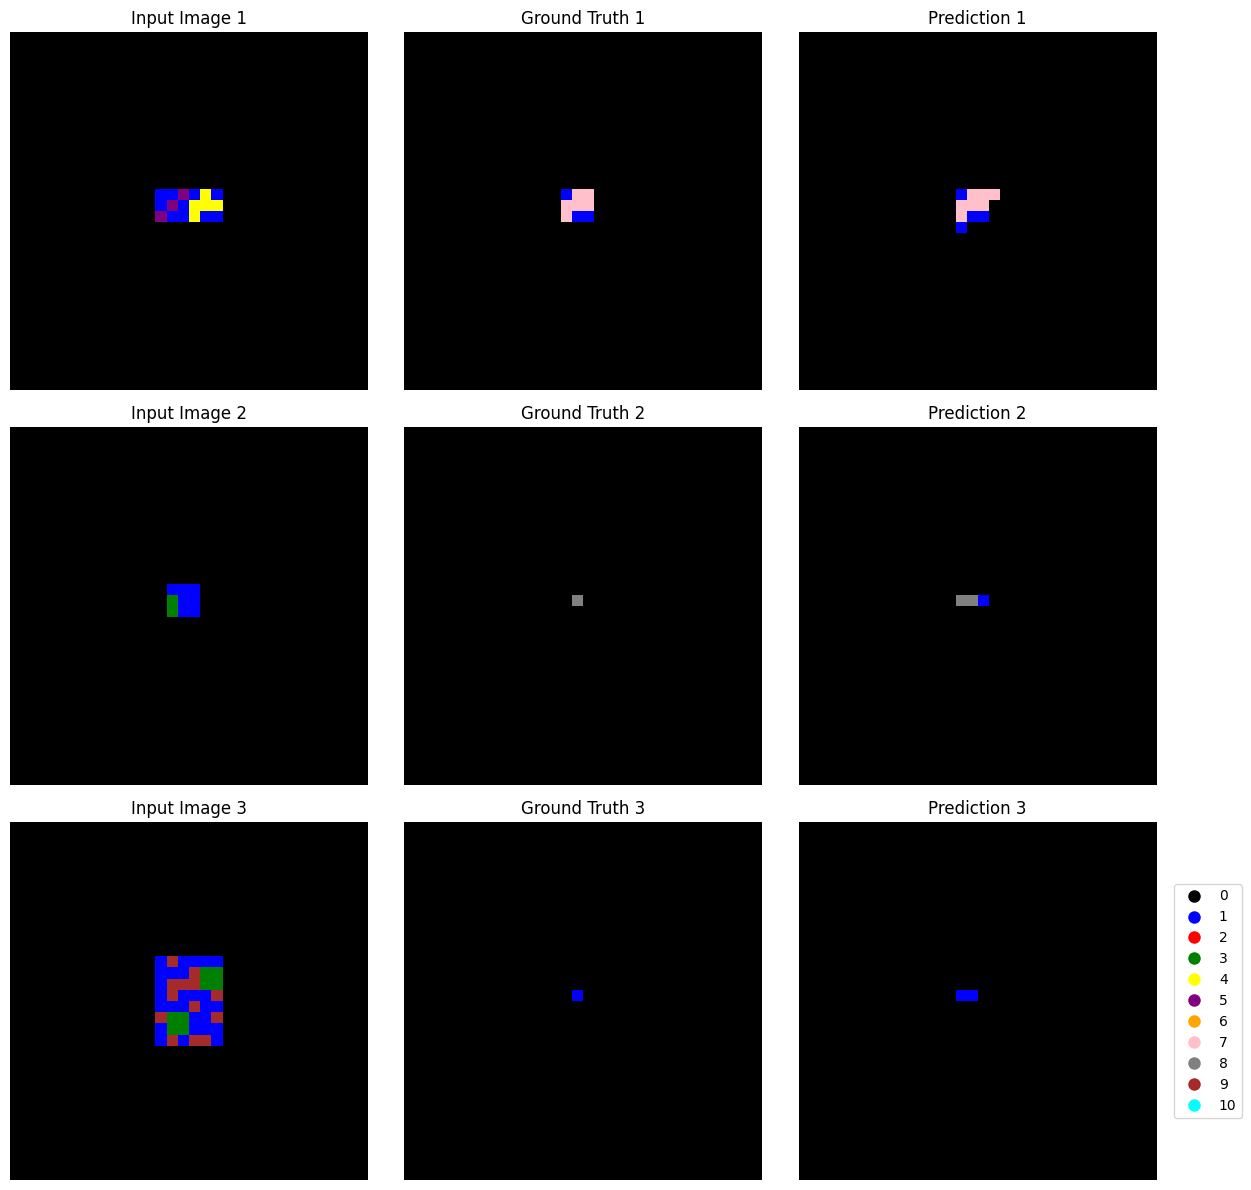

Test Average Loss: 6.008602 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.08%


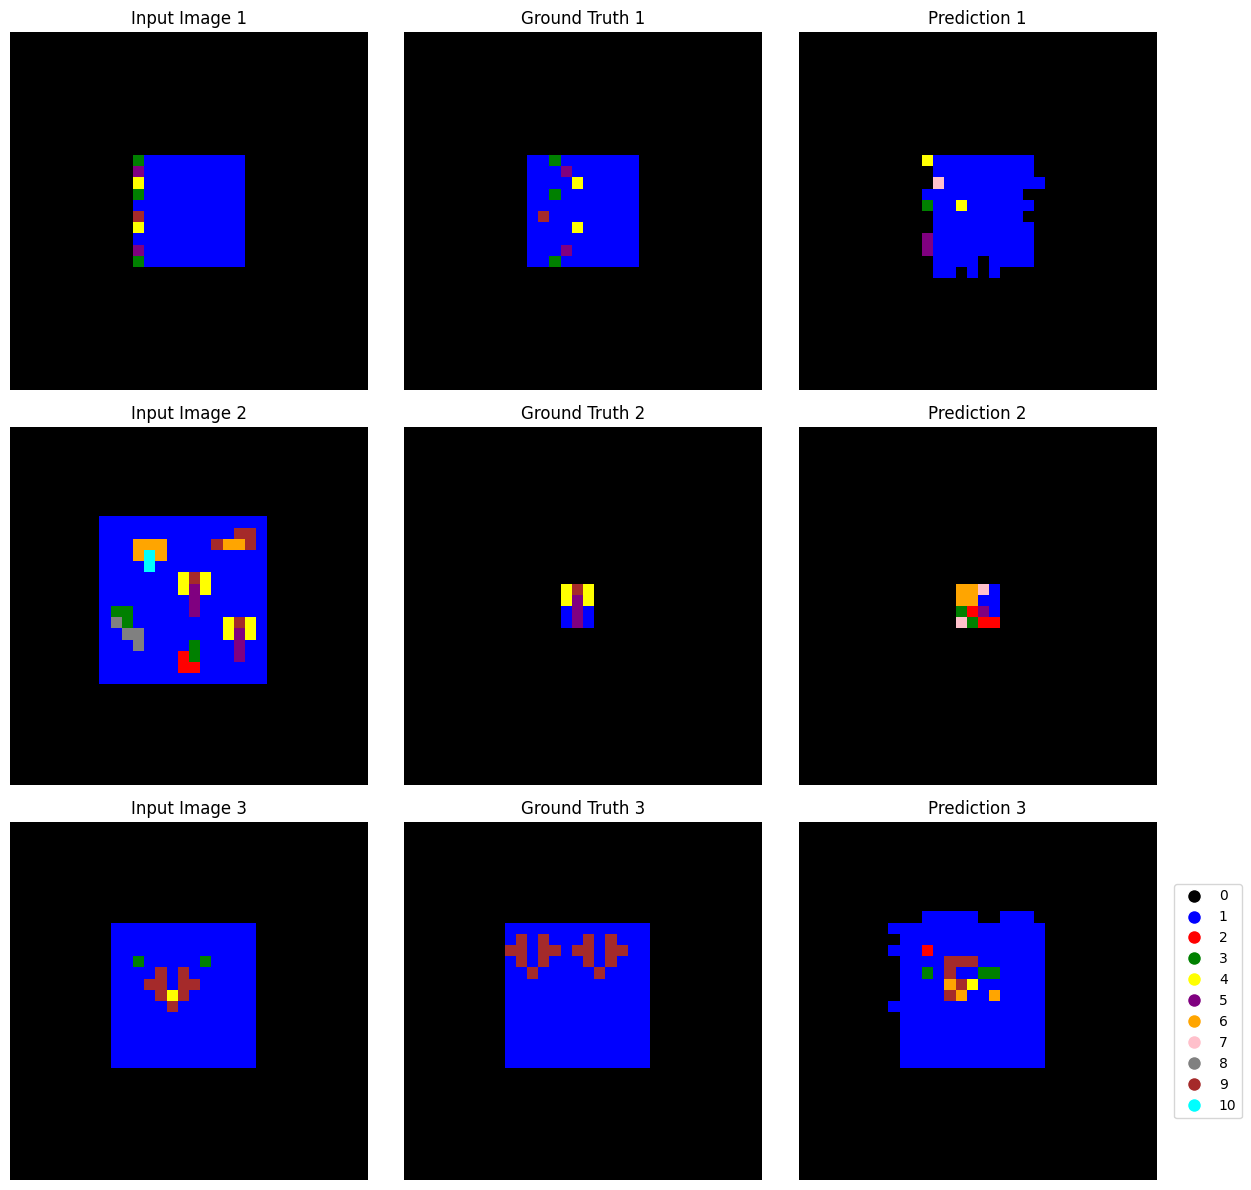

Epoch [601/1000] Complete | Average Loss: 0.012643 | Training Sample Accuracy: 15.2929% | Training Pixel Accuracy: 99.27%


Test Average Loss: 5.870550 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.94%


Epoch [602/1000] Complete | Average Loss: 0.015358 | Training Sample Accuracy: 13.6048% | Training Pixel Accuracy: 99.23%


Test Average Loss: 5.798791 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.72%


Epoch [603/1000] Complete | Average Loss: 0.020234 | Training Sample Accuracy: 10.9235% | Training Pixel Accuracy: 99.12%


Test Average Loss: 5.486085 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.83%


Epoch [604/1000] Complete | Average Loss: 0.023894 | Training Sample Accuracy: 8.2423% | Training Pixel Accuracy: 99.05%


Test Average Loss: 6.170792 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.52%


Epoch [605/1000] Complete | Average Loss: 0.019728 | Training Sample Accuracy: 7.3486% | Training Pixel Accuracy: 99.06%


Test Average Loss: 5.945573 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.87%


Epoch [606/1000] Complete | Average Loss: 0.020297 | Training Sample Accuracy: 9.1360% | Training Pixel Accuracy: 99.12%


Test Average Loss: 6.275549 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.92%


Epoch [607/1000] Complete | Average Loss: 0.018338 | Training Sample Accuracy: 7.8451% | Training Pixel Accuracy: 99.11%


Test Average Loss: 5.998673 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.68%


Epoch [608/1000] Complete | Average Loss: 0.019888 | Training Sample Accuracy: 9.2354% | Training Pixel Accuracy: 99.09%


Test Average Loss: 5.866687 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.83%


Epoch [609/1000] Complete | Average Loss: 0.021452 | Training Sample Accuracy: 8.5402% | Training Pixel Accuracy: 99.10%


Test Average Loss: 6.143505 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.74%


Epoch [610/1000] Complete | Average Loss: 0.024147 | Training Sample Accuracy: 8.4409% | Training Pixel Accuracy: 99.11%


Test Average Loss: 5.772140 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.01%


Epoch [611/1000] Complete | Average Loss: 0.023231 | Training Sample Accuracy: 9.2354% | Training Pixel Accuracy: 99.07%


Test Average Loss: 5.498128 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.73%


Epoch [612/1000] Complete | Average Loss: 0.020973 | Training Sample Accuracy: 8.3416% | Training Pixel Accuracy: 99.07%


Test Average Loss: 5.246879 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.80%


Epoch [613/1000] Complete | Average Loss: 0.016795 | Training Sample Accuracy: 8.1430% | Training Pixel Accuracy: 99.16%


Test Average Loss: 5.599761 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.97%


Epoch [614/1000] Complete | Average Loss: 0.016852 | Training Sample Accuracy: 11.9166% | Training Pixel Accuracy: 99.20%


Test Average Loss: 5.733940 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.96%


Epoch [615/1000] Complete | Average Loss: 0.013546 | Training Sample Accuracy: 12.4131% | Training Pixel Accuracy: 99.21%


Test Average Loss: 5.729513 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.13%


Epoch [616/1000] Complete | Average Loss: 0.012682 | Training Sample Accuracy: 12.7110% | Training Pixel Accuracy: 99.28%


Test Average Loss: 6.031877 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [617/1000] Complete | Average Loss: 0.010978 | Training Sample Accuracy: 13.6048% | Training Pixel Accuracy: 99.23%


Test Average Loss: 5.866540 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.16%


Epoch [618/1000] Complete | Average Loss: 0.010045 | Training Sample Accuracy: 15.6902% | Training Pixel Accuracy: 99.34%


Test Average Loss: 5.646355 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.11%


Epoch [619/1000] Complete | Average Loss: 0.011533 | Training Sample Accuracy: 15.8888% | Training Pixel Accuracy: 99.31%


Test Average Loss: 6.200806 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.19%


Epoch [620/1000] Complete | Average Loss: 0.013428 | Training Sample Accuracy: 12.4131% | Training Pixel Accuracy: 99.21%


Test Average Loss: 4.616084 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.51%


Epoch [621/1000] Complete | Average Loss: 0.015344 | Training Sample Accuracy: 8.8381% | Training Pixel Accuracy: 99.12%


Test Average Loss: 5.203723 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.89%


Epoch [622/1000] Complete | Average Loss: 0.014337 | Training Sample Accuracy: 11.2214% | Training Pixel Accuracy: 99.20%


Test Average Loss: 5.990278 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.86%


Epoch [623/1000] Complete | Average Loss: 0.017250 | Training Sample Accuracy: 11.3208% | Training Pixel Accuracy: 99.25%


Test Average Loss: 6.157365 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.15%


Epoch [624/1000] Complete | Average Loss: 0.016146 | Training Sample Accuracy: 11.0228% | Training Pixel Accuracy: 99.25%


Test Average Loss: 5.255726 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.79%


Epoch [625/1000] Complete | Average Loss: 0.015663 | Training Sample Accuracy: 12.1152% | Training Pixel Accuracy: 99.21%


Test Average Loss: 5.293126 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.82%


Epoch [626/1000] Complete | Average Loss: 0.017060 | Training Sample Accuracy: 13.2075% | Training Pixel Accuracy: 99.17%


Test Average Loss: 5.297085 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [627/1000] Complete | Average Loss: 0.014041 | Training Sample Accuracy: 14.4985% | Training Pixel Accuracy: 99.25%


Test Average Loss: 5.677612 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.11%


Epoch [628/1000] Complete | Average Loss: 0.011515 | Training Sample Accuracy: 14.0020% | Training Pixel Accuracy: 99.29%


Test Average Loss: 6.199431 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [629/1000] Complete | Average Loss: 0.010038 | Training Sample Accuracy: 14.4985% | Training Pixel Accuracy: 99.33%


Test Average Loss: 5.970606 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.28%


Epoch [630/1000] Complete | Average Loss: 0.010750 | Training Sample Accuracy: 15.0943% | Training Pixel Accuracy: 99.31%


Test Average Loss: 6.041997 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.20%


Epoch [631/1000] Complete | Average Loss: 0.010133 | Training Sample Accuracy: 19.1658% | Training Pixel Accuracy: 99.40%


Test Average Loss: 6.288157 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [632/1000] Complete | Average Loss: 0.010766 | Training Sample Accuracy: 18.6693% | Training Pixel Accuracy: 99.34%


Test Average Loss: 5.837005 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.95%


Epoch [633/1000] Complete | Average Loss: 0.013055 | Training Sample Accuracy: 13.8034% | Training Pixel Accuracy: 99.19%


Test Average Loss: 5.737355 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.07%


Epoch [634/1000] Complete | Average Loss: 0.015495 | Training Sample Accuracy: 12.8103% | Training Pixel Accuracy: 99.19%


Test Average Loss: 5.974949 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.08%


Epoch [635/1000] Complete | Average Loss: 0.016101 | Training Sample Accuracy: 12.6117% | Training Pixel Accuracy: 99.27%


Test Average Loss: 5.699635 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.62%


Epoch [636/1000] Complete | Average Loss: 0.016538 | Training Sample Accuracy: 10.6256% | Training Pixel Accuracy: 99.21%


Test Average Loss: 6.054414 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.06%


Epoch [637/1000] Complete | Average Loss: 0.019859 | Training Sample Accuracy: 11.6187% | Training Pixel Accuracy: 99.10%


Test Average Loss: 6.956165 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.16%


Epoch [638/1000] Complete | Average Loss: 0.018181 | Training Sample Accuracy: 10.1291% | Training Pixel Accuracy: 99.18%


Test Average Loss: 5.458232 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [639/1000] Complete | Average Loss: 0.015419 | Training Sample Accuracy: 12.7110% | Training Pixel Accuracy: 99.19%


Test Average Loss: 5.321949 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.89%


Epoch [640/1000] Complete | Average Loss: 0.013754 | Training Sample Accuracy: 13.7041% | Training Pixel Accuracy: 99.28%


Test Average Loss: 6.165083 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.23%


Epoch [641/1000] Complete | Average Loss: 0.014736 | Training Sample Accuracy: 11.8173% | Training Pixel Accuracy: 99.24%


Test Average Loss: 5.668867 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.06%


Epoch [642/1000] Complete | Average Loss: 0.014097 | Training Sample Accuracy: 12.8103% | Training Pixel Accuracy: 99.27%


Test Average Loss: 5.622883 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [643/1000] Complete | Average Loss: 0.013868 | Training Sample Accuracy: 13.1082% | Training Pixel Accuracy: 99.23%


Test Average Loss: 6.064088 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.10%


Epoch [644/1000] Complete | Average Loss: 0.013319 | Training Sample Accuracy: 13.6048% | Training Pixel Accuracy: 99.26%


Test Average Loss: 6.101026 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.16%


Epoch [645/1000] Complete | Average Loss: 0.012857 | Training Sample Accuracy: 13.2075% | Training Pixel Accuracy: 99.30%


Test Average Loss: 5.513990 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.09%


Epoch [646/1000] Complete | Average Loss: 0.015076 | Training Sample Accuracy: 12.4131% | Training Pixel Accuracy: 99.27%


Test Average Loss: 5.969200 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.10%


Epoch [647/1000] Complete | Average Loss: 0.013862 | Training Sample Accuracy: 12.0159% | Training Pixel Accuracy: 99.26%


Test Average Loss: 6.024993 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.07%


Epoch [648/1000] Complete | Average Loss: 0.011584 | Training Sample Accuracy: 14.6971% | Training Pixel Accuracy: 99.31%


Test Average Loss: 5.997142 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [649/1000] Complete | Average Loss: 0.011992 | Training Sample Accuracy: 15.6902% | Training Pixel Accuracy: 99.31%


Test Average Loss: 6.132933 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.93%


Epoch [650/1000] Complete | Average Loss: 0.012095 | Training Sample Accuracy: 14.0020% | Training Pixel Accuracy: 99.24%


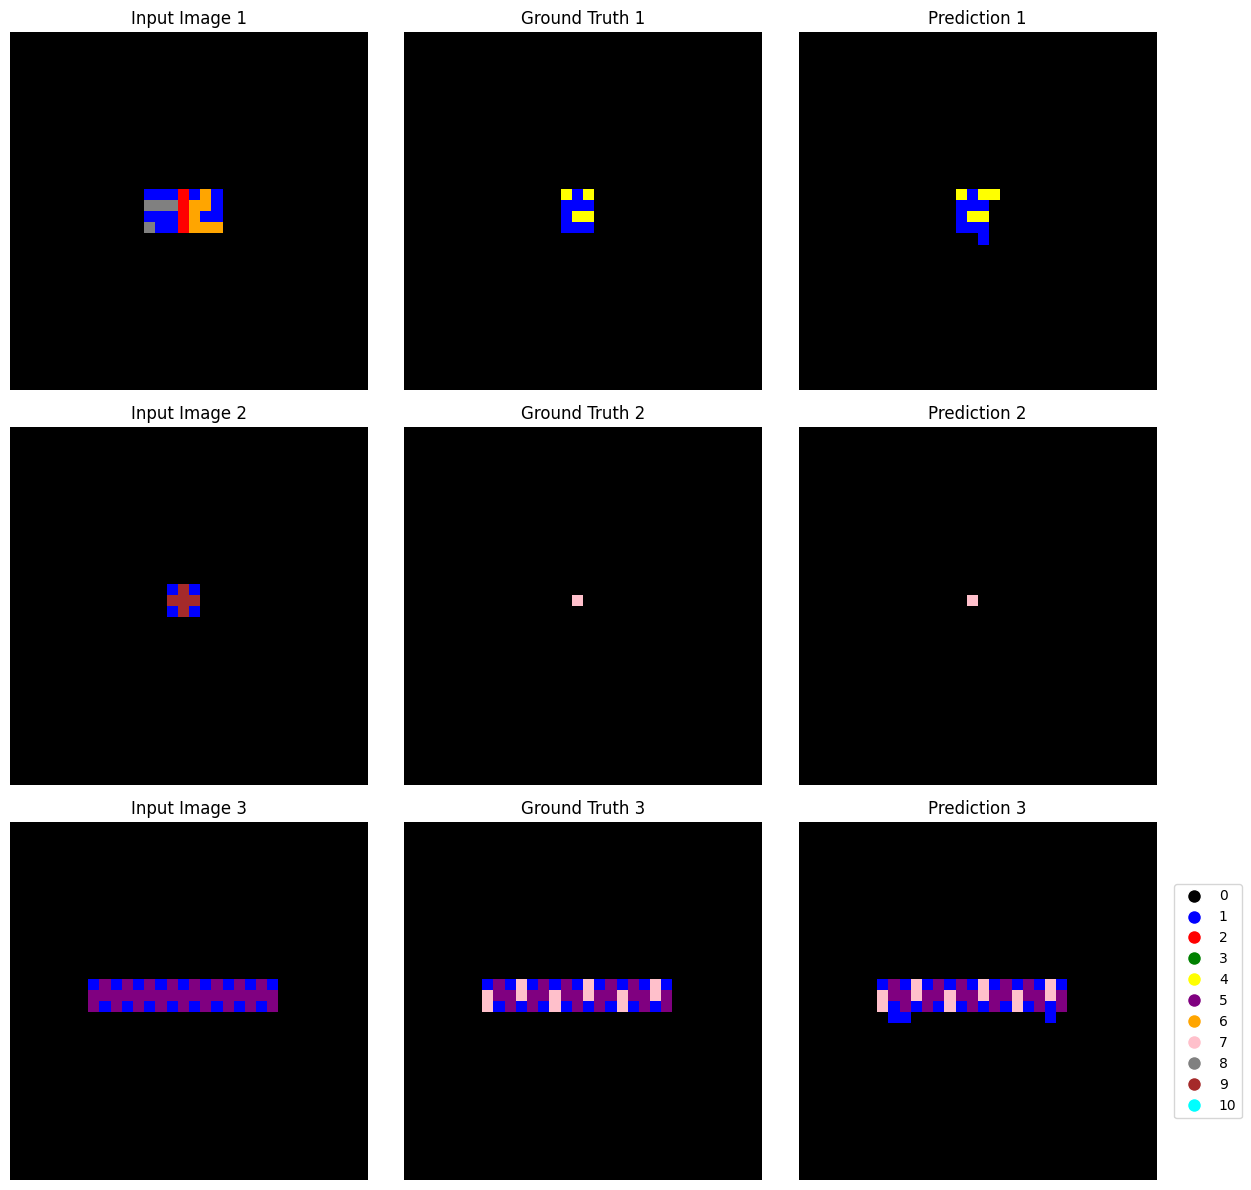

Test Average Loss: 5.766943 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.89%


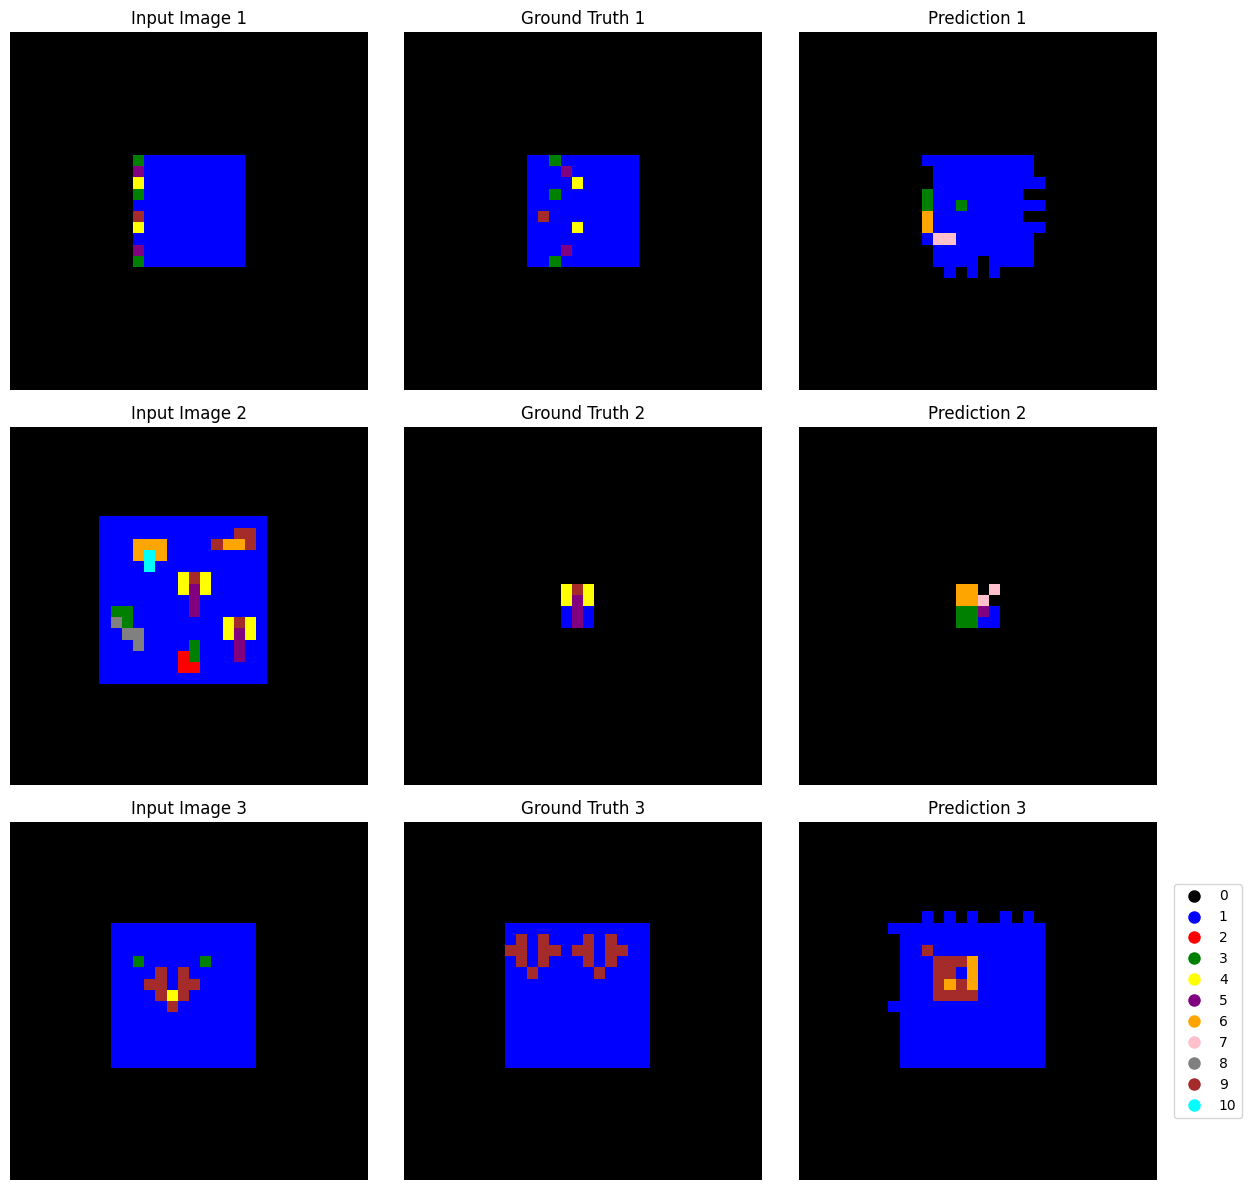

Epoch [651/1000] Complete | Average Loss: 0.010405 | Training Sample Accuracy: 10.9235% | Training Pixel Accuracy: 99.29%


Test Average Loss: 6.257048 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.26%


Epoch [652/1000] Complete | Average Loss: 0.011531 | Training Sample Accuracy: 13.7041% | Training Pixel Accuracy: 99.32%


Test Average Loss: 5.902661 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.00%


Epoch [653/1000] Complete | Average Loss: 0.010593 | Training Sample Accuracy: 16.1867% | Training Pixel Accuracy: 99.35%


Test Average Loss: 6.529084 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.09%


Epoch [654/1000] Complete | Average Loss: 0.010279 | Training Sample Accuracy: 15.2929% | Training Pixel Accuracy: 99.35%


Test Average Loss: 6.464300 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.08%


Epoch [655/1000] Complete | Average Loss: 0.011994 | Training Sample Accuracy: 16.3853% | Training Pixel Accuracy: 99.32%


Test Average Loss: 5.503100 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.82%


Epoch [656/1000] Complete | Average Loss: 0.013068 | Training Sample Accuracy: 12.6117% | Training Pixel Accuracy: 99.29%


Test Average Loss: 5.546055 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.88%


Epoch [657/1000] Complete | Average Loss: 0.014851 | Training Sample Accuracy: 10.4270% | Training Pixel Accuracy: 99.27%


Test Average Loss: 5.803828 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.00%


Epoch [658/1000] Complete | Average Loss: 0.015060 | Training Sample Accuracy: 13.1082% | Training Pixel Accuracy: 99.30%


Test Average Loss: 5.725993 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.13%


Epoch [659/1000] Complete | Average Loss: 0.014416 | Training Sample Accuracy: 12.1152% | Training Pixel Accuracy: 99.22%


Test Average Loss: 5.444241 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.92%


Epoch [660/1000] Complete | Average Loss: 0.012773 | Training Sample Accuracy: 15.9881% | Training Pixel Accuracy: 99.33%


Test Average Loss: 6.377590 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [661/1000] Complete | Average Loss: 0.013622 | Training Sample Accuracy: 15.2929% | Training Pixel Accuracy: 99.35%


Test Average Loss: 5.521483 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.95%


Epoch [662/1000] Complete | Average Loss: 0.014226 | Training Sample Accuracy: 15.1936% | Training Pixel Accuracy: 99.29%


Test Average Loss: 6.126513 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.17%


Epoch [663/1000] Complete | Average Loss: 0.019889 | Training Sample Accuracy: 10.2284% | Training Pixel Accuracy: 99.22%


Test Average Loss: 5.649037 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.96%


Epoch [664/1000] Complete | Average Loss: 0.030644 | Training Sample Accuracy: 10.0298% | Training Pixel Accuracy: 99.07%


Test Average Loss: 6.424636 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.90%


Epoch [665/1000] Complete | Average Loss: 0.031497 | Training Sample Accuracy: 9.0367% | Training Pixel Accuracy: 99.05%


Test Average Loss: 5.508518 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.74%


Epoch [666/1000] Complete | Average Loss: 0.031593 | Training Sample Accuracy: 9.5333% | Training Pixel Accuracy: 99.02%


Test Average Loss: 7.030977 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.75%


Epoch [667/1000] Complete | Average Loss: 0.030069 | Training Sample Accuracy: 8.7388% | Training Pixel Accuracy: 99.02%


Test Average Loss: 5.660839 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.08%


Epoch [668/1000] Complete | Average Loss: 0.025488 | Training Sample Accuracy: 10.5263% | Training Pixel Accuracy: 99.08%


Test Average Loss: 5.293314 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.73%


Epoch [669/1000] Complete | Average Loss: 0.034146 | Training Sample Accuracy: 7.2493% | Training Pixel Accuracy: 98.98%


Test Average Loss: 6.068296 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.88%


Epoch [670/1000] Complete | Average Loss: 0.055370 | Training Sample Accuracy: 6.9513% | Training Pixel Accuracy: 98.91%


Test Average Loss: 5.728393 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.83%


Epoch [671/1000] Complete | Average Loss: 0.077936 | Training Sample Accuracy: 1.9861% | Training Pixel Accuracy: 98.54%


Test Average Loss: 6.982198 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.77%


Epoch [672/1000] Complete | Average Loss: 0.076402 | Training Sample Accuracy: 2.5819% | Training Pixel Accuracy: 98.52%


Test Average Loss: 5.033908 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.58%


Epoch [673/1000] Complete | Average Loss: 0.100736 | Training Sample Accuracy: 3.6743% | Training Pixel Accuracy: 98.28%


Test Average Loss: 4.539961 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 88.90%


Epoch [674/1000] Complete | Average Loss: 0.067642 | Training Sample Accuracy: 1.6882% | Training Pixel Accuracy: 98.46%


Test Average Loss: 4.817854 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.12%


Epoch [675/1000] Complete | Average Loss: 0.051164 | Training Sample Accuracy: 2.4826% | Training Pixel Accuracy: 98.59%


Test Average Loss: 4.942701 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.57%


Epoch [676/1000] Complete | Average Loss: 0.039258 | Training Sample Accuracy: 4.0715% | Training Pixel Accuracy: 98.82%


Test Average Loss: 5.025681 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.90%


Epoch [677/1000] Complete | Average Loss: 0.030964 | Training Sample Accuracy: 8.6395% | Training Pixel Accuracy: 98.93%


Test Average Loss: 4.931634 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.81%


Epoch [678/1000] Complete | Average Loss: 0.024955 | Training Sample Accuracy: 8.4409% | Training Pixel Accuracy: 99.00%


Test Average Loss: 4.829338 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.68%


Epoch [679/1000] Complete | Average Loss: 0.020320 | Training Sample Accuracy: 8.0437% | Training Pixel Accuracy: 99.08%


Test Average Loss: 5.685375 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.02%


Epoch [680/1000] Complete | Average Loss: 0.014590 | Training Sample Accuracy: 10.3277% | Training Pixel Accuracy: 99.18%


Test Average Loss: 5.323326 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.01%


Epoch [681/1000] Complete | Average Loss: 0.011211 | Training Sample Accuracy: 14.2006% | Training Pixel Accuracy: 99.22%


Test Average Loss: 6.057450 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.18%


Epoch [682/1000] Complete | Average Loss: 0.010727 | Training Sample Accuracy: 12.8103% | Training Pixel Accuracy: 99.27%


Test Average Loss: 5.149661 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.03%


Epoch [683/1000] Complete | Average Loss: 0.009626 | Training Sample Accuracy: 13.4062% | Training Pixel Accuracy: 99.27%


Test Average Loss: 6.421376 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.45%


Epoch [684/1000] Complete | Average Loss: 0.008467 | Training Sample Accuracy: 19.9603% | Training Pixel Accuracy: 99.36%


Test Average Loss: 6.122142 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [685/1000] Complete | Average Loss: 0.009304 | Training Sample Accuracy: 17.8749% | Training Pixel Accuracy: 99.34%


Test Average Loss: 5.724139 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.98%


Epoch [686/1000] Complete | Average Loss: 0.008329 | Training Sample Accuracy: 16.7825% | Training Pixel Accuracy: 99.35%


Test Average Loss: 6.528167 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.19%


Epoch [687/1000] Complete | Average Loss: 0.009182 | Training Sample Accuracy: 19.9603% | Training Pixel Accuracy: 99.37%


Test Average Loss: 6.263401 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.14%


Epoch [688/1000] Complete | Average Loss: 0.007334 | Training Sample Accuracy: 18.4707% | Training Pixel Accuracy: 99.38%


Test Average Loss: 6.469230 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [689/1000] Complete | Average Loss: 0.007245 | Training Sample Accuracy: 20.2582% | Training Pixel Accuracy: 99.42%


Test Average Loss: 6.432755 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.12%


Epoch [690/1000] Complete | Average Loss: 0.007599 | Training Sample Accuracy: 19.9603% | Training Pixel Accuracy: 99.40%


Test Average Loss: 6.726617 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [691/1000] Complete | Average Loss: 0.007145 | Training Sample Accuracy: 18.3714% | Training Pixel Accuracy: 99.38%


Test Average Loss: 6.716241 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.41%


Epoch [692/1000] Complete | Average Loss: 0.006470 | Training Sample Accuracy: 21.1519% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.616362 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.27%


Epoch [693/1000] Complete | Average Loss: 0.006246 | Training Sample Accuracy: 22.5422% | Training Pixel Accuracy: 99.46%


Test Average Loss: 6.754955 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.33%


Epoch [694/1000] Complete | Average Loss: 0.006095 | Training Sample Accuracy: 20.2582% | Training Pixel Accuracy: 99.43%


Test Average Loss: 7.038567 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.41%


Epoch [695/1000] Complete | Average Loss: 0.006259 | Training Sample Accuracy: 19.6624% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.613515 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [696/1000] Complete | Average Loss: 0.006027 | Training Sample Accuracy: 20.6554% | Training Pixel Accuracy: 99.46%


Test Average Loss: 6.990935 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [697/1000] Complete | Average Loss: 0.007733 | Training Sample Accuracy: 19.7617% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.127733 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.19%


Epoch [698/1000] Complete | Average Loss: 0.008697 | Training Sample Accuracy: 19.4638% | Training Pixel Accuracy: 99.40%


Test Average Loss: 6.840503 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [699/1000] Complete | Average Loss: 0.006860 | Training Sample Accuracy: 16.2860% | Training Pixel Accuracy: 99.43%


Test Average Loss: 6.816067 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.38%


Epoch [700/1000] Complete | Average Loss: 0.006437 | Training Sample Accuracy: 18.5700% | Training Pixel Accuracy: 99.44%


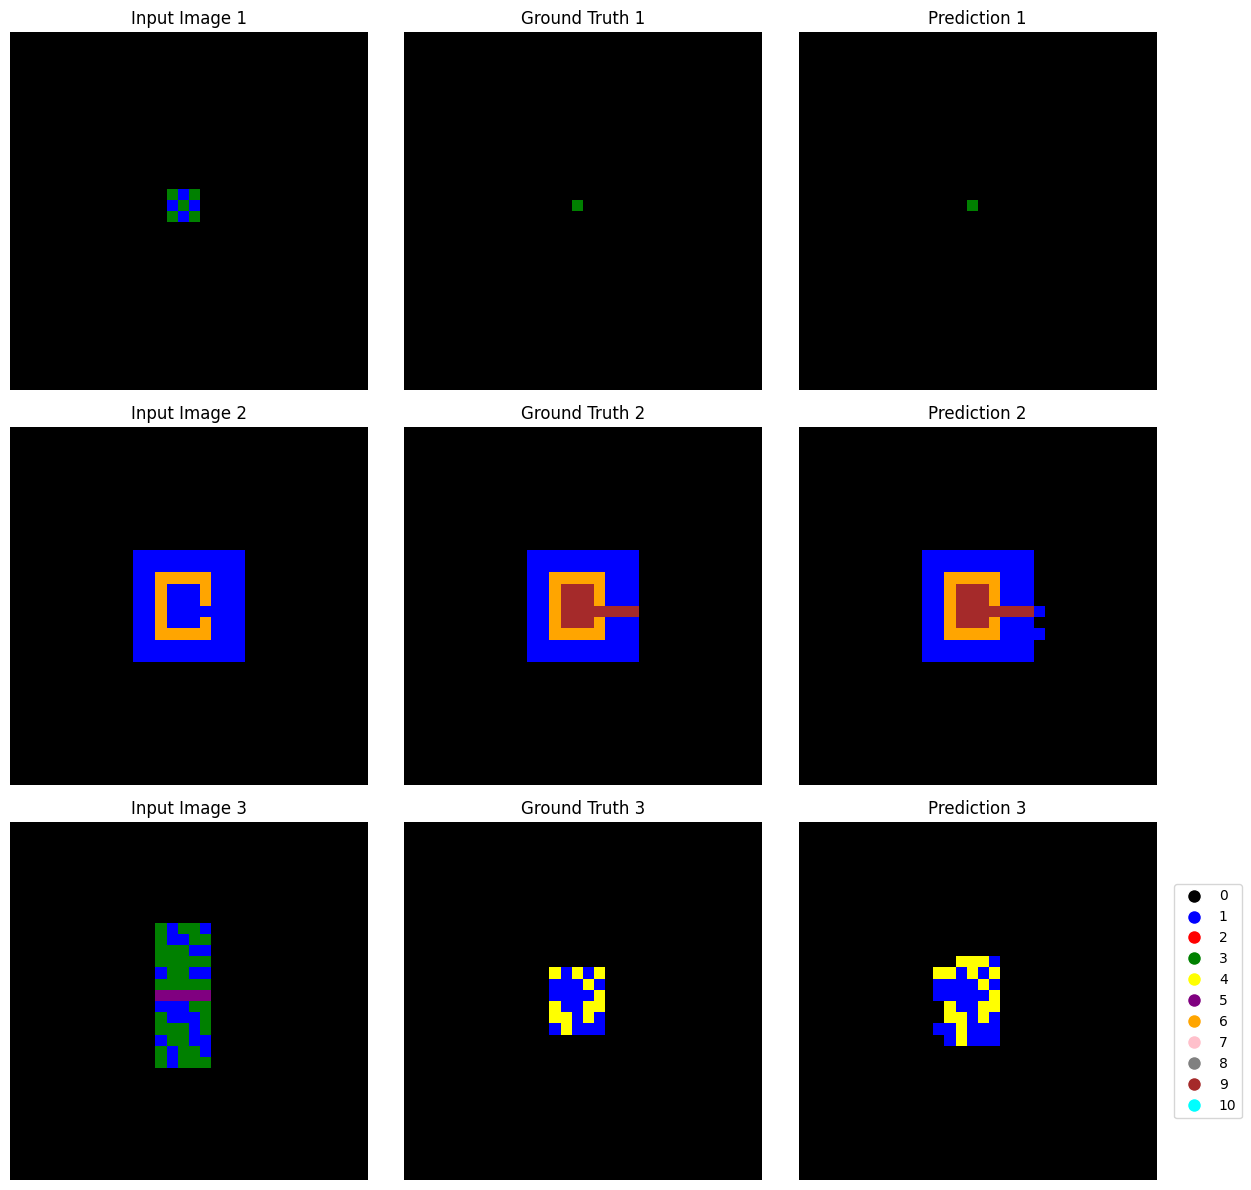

Test Average Loss: 6.705498 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


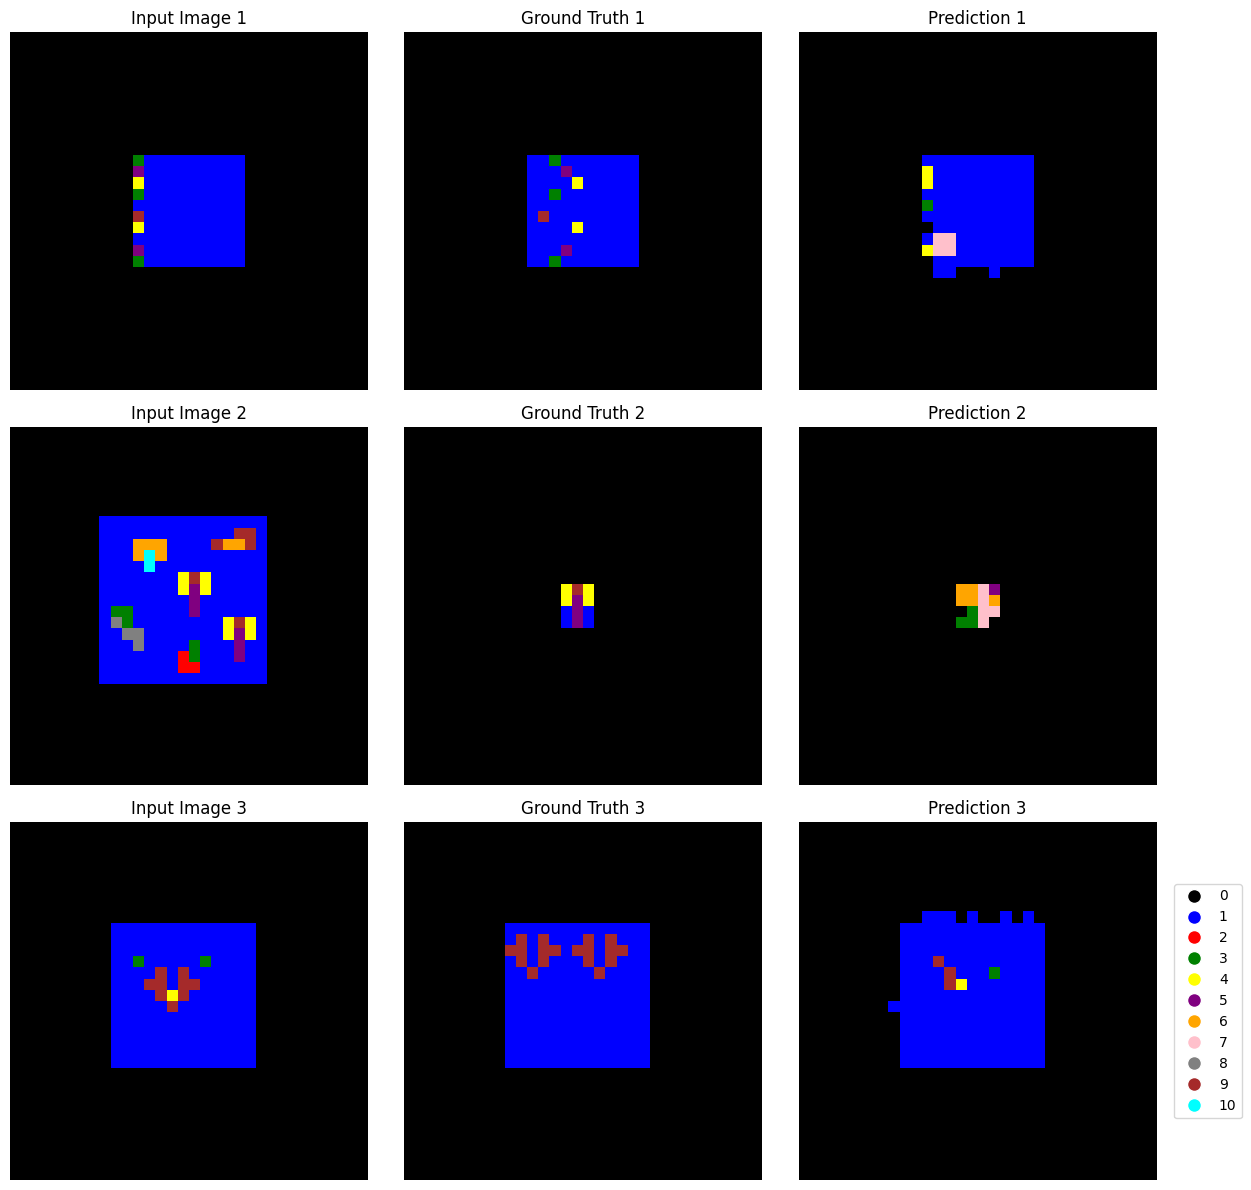

Epoch [701/1000] Complete | Average Loss: 0.006349 | Training Sample Accuracy: 21.0526% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.386334 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [702/1000] Complete | Average Loss: 0.008813 | Training Sample Accuracy: 23.0387% | Training Pixel Accuracy: 99.45%


Test Average Loss: 6.725400 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.38%


Epoch [703/1000] Complete | Average Loss: 0.007960 | Training Sample Accuracy: 18.3714% | Training Pixel Accuracy: 99.40%


Test Average Loss: 6.329203 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.33%


Epoch [704/1000] Complete | Average Loss: 0.008774 | Training Sample Accuracy: 22.0457% | Training Pixel Accuracy: 99.42%


Test Average Loss: 6.721791 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.43%


Epoch [705/1000] Complete | Average Loss: 0.013701 | Training Sample Accuracy: 16.6832% | Training Pixel Accuracy: 99.36%


Test Average Loss: 6.175011 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.32%


Epoch [706/1000] Complete | Average Loss: 0.014103 | Training Sample Accuracy: 13.5055% | Training Pixel Accuracy: 99.26%


Test Average Loss: 5.990415 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.18%


Epoch [707/1000] Complete | Average Loss: 0.011606 | Training Sample Accuracy: 11.3208% | Training Pixel Accuracy: 99.29%


Test Average Loss: 6.591158 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [708/1000] Complete | Average Loss: 0.011696 | Training Sample Accuracy: 14.7964% | Training Pixel Accuracy: 99.32%


Test Average Loss: 5.991876 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.88%


Epoch [709/1000] Complete | Average Loss: 0.012188 | Training Sample Accuracy: 14.1013% | Training Pixel Accuracy: 99.32%


Test Average Loss: 5.735957 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.94%


Epoch [710/1000] Complete | Average Loss: 0.013838 | Training Sample Accuracy: 12.3138% | Training Pixel Accuracy: 99.27%


Test Average Loss: 6.514411 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.21%


Epoch [711/1000] Complete | Average Loss: 0.014277 | Training Sample Accuracy: 9.5333% | Training Pixel Accuracy: 99.23%


Test Average Loss: 6.292357 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.06%


Epoch [712/1000] Complete | Average Loss: 0.013458 | Training Sample Accuracy: 14.9950% | Training Pixel Accuracy: 99.32%


Test Average Loss: 6.573598 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.87%


Epoch [713/1000] Complete | Average Loss: 0.014401 | Training Sample Accuracy: 12.5124% | Training Pixel Accuracy: 99.30%


Test Average Loss: 6.172153 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.00%


Epoch [714/1000] Complete | Average Loss: 0.013717 | Training Sample Accuracy: 13.6048% | Training Pixel Accuracy: 99.30%


Test Average Loss: 6.586997 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.92%


Epoch [715/1000] Complete | Average Loss: 0.013471 | Training Sample Accuracy: 17.2790% | Training Pixel Accuracy: 99.35%


Test Average Loss: 6.005714 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.84%


Epoch [716/1000] Complete | Average Loss: 0.013263 | Training Sample Accuracy: 13.4062% | Training Pixel Accuracy: 99.26%


Test Average Loss: 6.807875 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [717/1000] Complete | Average Loss: 0.012798 | Training Sample Accuracy: 14.2006% | Training Pixel Accuracy: 99.33%


Test Average Loss: 6.091833 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.98%


Epoch [718/1000] Complete | Average Loss: 0.018844 | Training Sample Accuracy: 6.4548% | Training Pixel Accuracy: 99.10%


Test Average Loss: 5.251585 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.25%


Epoch [719/1000] Complete | Average Loss: 0.022138 | Training Sample Accuracy: 10.7249% | Training Pixel Accuracy: 99.14%


Test Average Loss: 6.613019 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.86%


Epoch [720/1000] Complete | Average Loss: 0.023443 | Training Sample Accuracy: 8.8381% | Training Pixel Accuracy: 99.09%


Test Average Loss: 5.984468 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.87%


Epoch [721/1000] Complete | Average Loss: 0.023085 | Training Sample Accuracy: 8.7388% | Training Pixel Accuracy: 99.02%


Test Average Loss: 5.782199 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.76%


Epoch [722/1000] Complete | Average Loss: 0.026488 | Training Sample Accuracy: 10.8242% | Training Pixel Accuracy: 99.09%


Test Average Loss: 5.734408 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.95%


Epoch [723/1000] Complete | Average Loss: 0.033283 | Training Sample Accuracy: 8.4409% | Training Pixel Accuracy: 98.91%


Test Average Loss: 4.947866 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 88.91%


Epoch [724/1000] Complete | Average Loss: 0.031906 | Training Sample Accuracy: 7.4479% | Training Pixel Accuracy: 98.92%


Test Average Loss: 5.057671 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.45%


Epoch [725/1000] Complete | Average Loss: 0.031257 | Training Sample Accuracy: 8.4409% | Training Pixel Accuracy: 98.96%


Test Average Loss: 5.728109 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.77%


Epoch [726/1000] Complete | Average Loss: 0.036672 | Training Sample Accuracy: 5.8590% | Training Pixel Accuracy: 98.25%


Test Average Loss: 4.839493 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 87.61%


Epoch [727/1000] Complete | Average Loss: 0.041105 | Training Sample Accuracy: 4.8659% | Training Pixel Accuracy: 98.31%


Test Average Loss: 4.709895 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.59%


Epoch [728/1000] Complete | Average Loss: 0.035952 | Training Sample Accuracy: 4.5680% | Training Pixel Accuracy: 98.81%


Test Average Loss: 5.212377 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.04%


Epoch [729/1000] Complete | Average Loss: 0.029506 | Training Sample Accuracy: 5.8590% | Training Pixel Accuracy: 98.86%


Test Average Loss: 5.756399 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.85%


Epoch [730/1000] Complete | Average Loss: 0.024578 | Training Sample Accuracy: 8.4409% | Training Pixel Accuracy: 99.01%


Test Average Loss: 5.024383 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.80%


Epoch [731/1000] Complete | Average Loss: 0.020295 | Training Sample Accuracy: 8.6395% | Training Pixel Accuracy: 99.10%


Test Average Loss: 4.862154 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.71%


Epoch [732/1000] Complete | Average Loss: 0.017003 | Training Sample Accuracy: 12.8103% | Training Pixel Accuracy: 99.17%


Test Average Loss: 5.684884 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.90%


Epoch [733/1000] Complete | Average Loss: 0.016477 | Training Sample Accuracy: 10.5263% | Training Pixel Accuracy: 99.18%


Test Average Loss: 4.949365 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.59%


Epoch [734/1000] Complete | Average Loss: 0.015932 | Training Sample Accuracy: 10.8242% | Training Pixel Accuracy: 99.05%


Test Average Loss: 5.542052 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.07%


Epoch [735/1000] Complete | Average Loss: 0.012607 | Training Sample Accuracy: 12.4131% | Training Pixel Accuracy: 99.18%


Test Average Loss: 5.863612 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.18%


Epoch [736/1000] Complete | Average Loss: 0.011943 | Training Sample Accuracy: 14.4985% | Training Pixel Accuracy: 99.26%


Test Average Loss: 6.220736 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [737/1000] Complete | Average Loss: 0.009379 | Training Sample Accuracy: 14.8957% | Training Pixel Accuracy: 99.32%


Test Average Loss: 6.411256 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.52%


Epoch [738/1000] Complete | Average Loss: 0.008063 | Training Sample Accuracy: 17.3784% | Training Pixel Accuracy: 99.40%


Test Average Loss: 5.942021 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.26%


Epoch [739/1000] Complete | Average Loss: 0.009075 | Training Sample Accuracy: 19.5631% | Training Pixel Accuracy: 99.39%


Test Average Loss: 5.904461 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [740/1000] Complete | Average Loss: 0.008582 | Training Sample Accuracy: 16.4846% | Training Pixel Accuracy: 99.35%


Test Average Loss: 5.536912 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.07%


Epoch [741/1000] Complete | Average Loss: 0.010639 | Training Sample Accuracy: 17.2790% | Training Pixel Accuracy: 99.34%


Test Average Loss: 5.552292 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.05%


Epoch [742/1000] Complete | Average Loss: 0.010097 | Training Sample Accuracy: 16.4846% | Training Pixel Accuracy: 99.38%


Test Average Loss: 5.960259 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.30%


Epoch [743/1000] Complete | Average Loss: 0.010393 | Training Sample Accuracy: 15.0943% | Training Pixel Accuracy: 99.36%


Test Average Loss: 5.553228 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.11%


Epoch [744/1000] Complete | Average Loss: 0.011020 | Training Sample Accuracy: 14.1013% | Training Pixel Accuracy: 99.36%


Test Average Loss: 6.131572 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [745/1000] Complete | Average Loss: 0.010379 | Training Sample Accuracy: 12.0159% | Training Pixel Accuracy: 99.36%


Test Average Loss: 5.714648 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.19%


Epoch [746/1000] Complete | Average Loss: 0.009353 | Training Sample Accuracy: 15.4916% | Training Pixel Accuracy: 99.39%


Test Average Loss: 6.624266 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.53%


Epoch [747/1000] Complete | Average Loss: 0.011706 | Training Sample Accuracy: 17.3784% | Training Pixel Accuracy: 99.39%


Test Average Loss: 6.052038 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.28%


Epoch [748/1000] Complete | Average Loss: 0.011160 | Training Sample Accuracy: 17.3784% | Training Pixel Accuracy: 99.40%


Test Average Loss: 6.251507 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.45%


Epoch [749/1000] Complete | Average Loss: 0.012367 | Training Sample Accuracy: 18.0735% | Training Pixel Accuracy: 99.32%


Test Average Loss: 6.091954 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.51%


Epoch [750/1000] Complete | Average Loss: 0.022341 | Training Sample Accuracy: 15.6902% | Training Pixel Accuracy: 99.32%


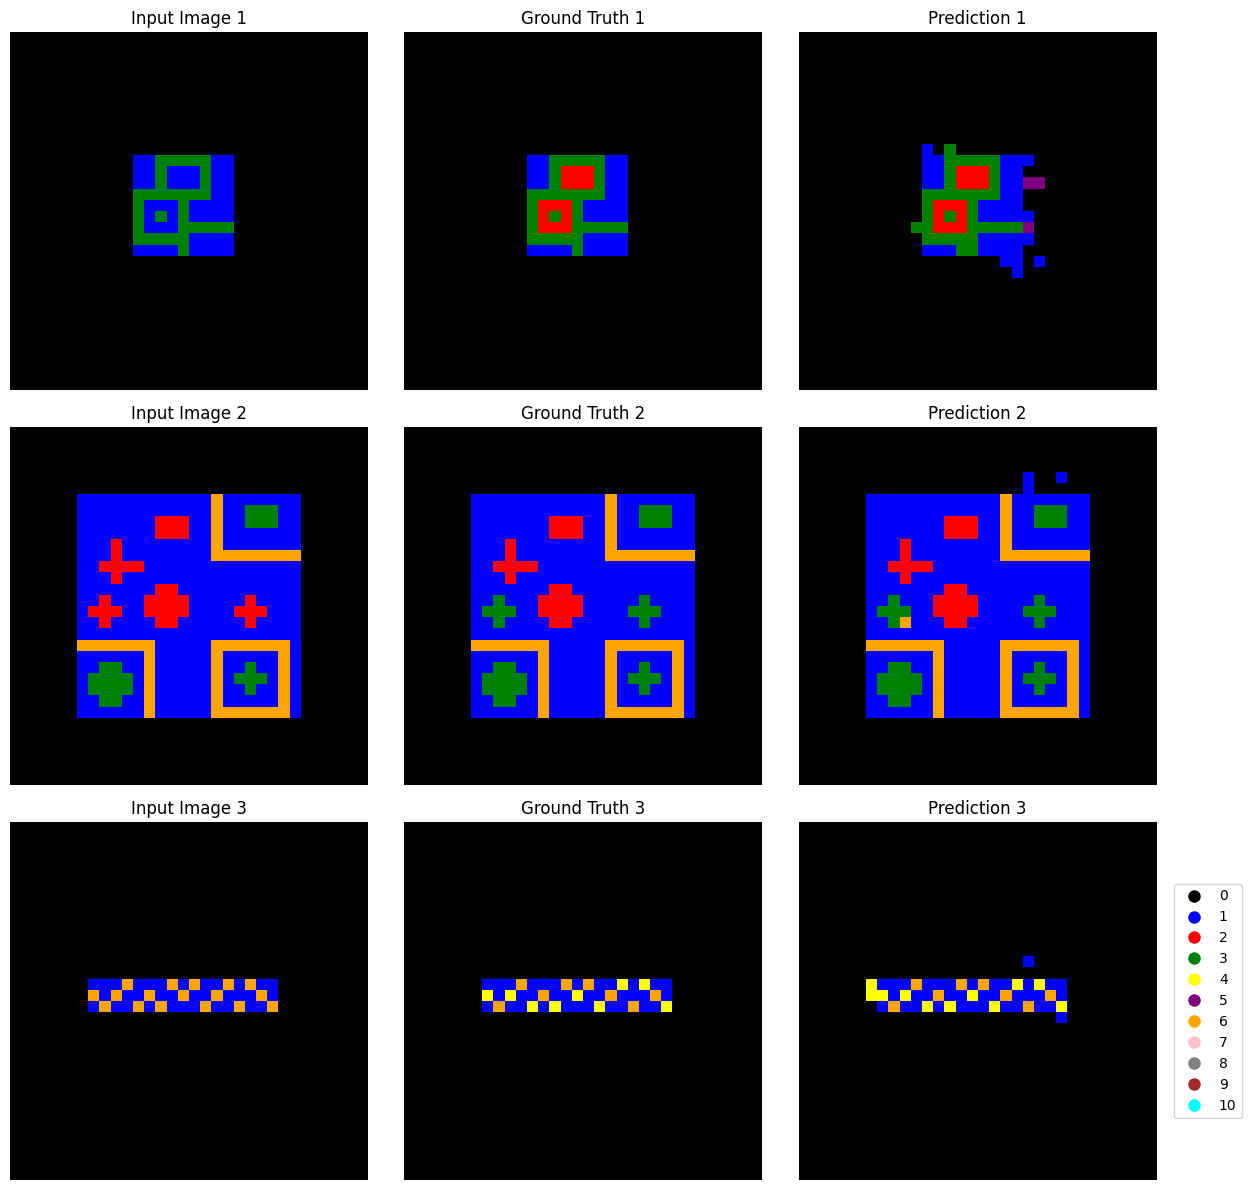

Test Average Loss: 5.529004 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.71%


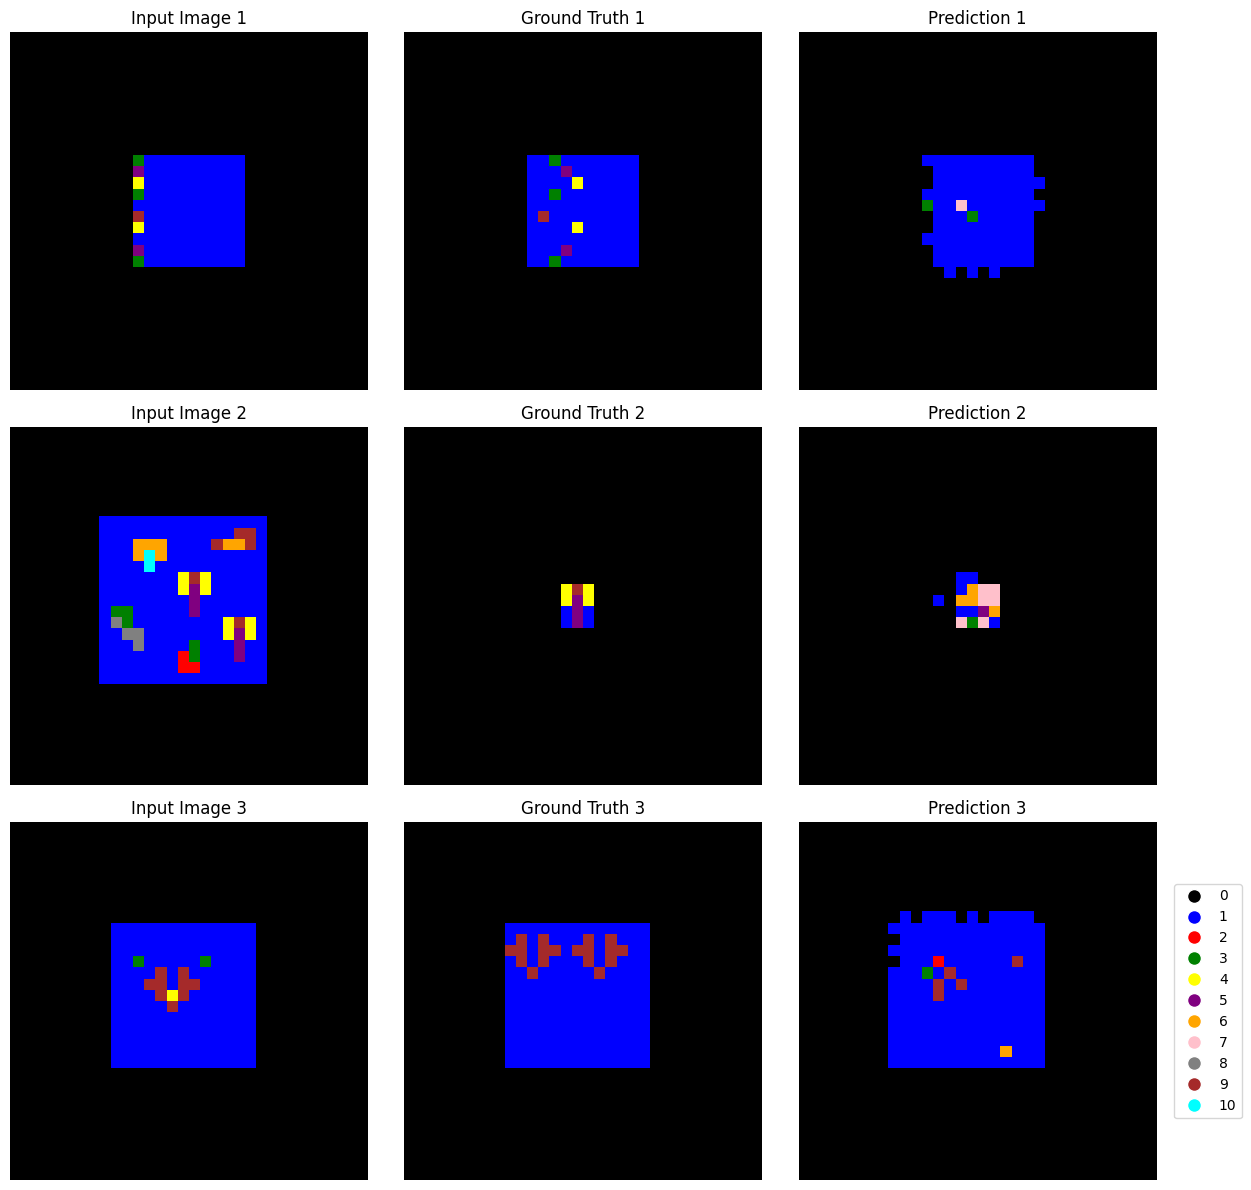

Epoch [751/1000] Complete | Average Loss: 0.027294 | Training Sample Accuracy: 13.6048% | Training Pixel Accuracy: 99.09%


Test Average Loss: 5.323689 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.09%


Epoch [752/1000] Complete | Average Loss: 0.026379 | Training Sample Accuracy: 8.7388% | Training Pixel Accuracy: 99.03%


Test Average Loss: 5.308039 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.02%


Epoch [753/1000] Complete | Average Loss: 0.027082 | Training Sample Accuracy: 8.8381% | Training Pixel Accuracy: 99.10%


Test Average Loss: 5.755971 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.87%


Epoch [754/1000] Complete | Average Loss: 0.026671 | Training Sample Accuracy: 8.8381% | Training Pixel Accuracy: 99.09%


Test Average Loss: 5.639715 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [755/1000] Complete | Average Loss: 0.026038 | Training Sample Accuracy: 8.4409% | Training Pixel Accuracy: 99.10%


Test Average Loss: 5.390493 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.81%


Epoch [756/1000] Complete | Average Loss: 0.020163 | Training Sample Accuracy: 11.2214% | Training Pixel Accuracy: 99.20%


Test Average Loss: 6.626038 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.20%


Epoch [757/1000] Complete | Average Loss: 0.015936 | Training Sample Accuracy: 11.2214% | Training Pixel Accuracy: 99.24%


Test Average Loss: 5.310590 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.89%


Epoch [758/1000] Complete | Average Loss: 0.012675 | Training Sample Accuracy: 10.6256% | Training Pixel Accuracy: 99.25%


Test Average Loss: 5.845552 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.17%


Epoch [759/1000] Complete | Average Loss: 0.011673 | Training Sample Accuracy: 15.3923% | Training Pixel Accuracy: 99.36%


Test Average Loss: 5.798881 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.05%


Epoch [760/1000] Complete | Average Loss: 0.016171 | Training Sample Accuracy: 14.9950% | Training Pixel Accuracy: 99.32%


Test Average Loss: 5.876883 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [761/1000] Complete | Average Loss: 0.012498 | Training Sample Accuracy: 17.2790% | Training Pixel Accuracy: 99.37%


Test Average Loss: 6.965147 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.34%


Epoch [762/1000] Complete | Average Loss: 0.012640 | Training Sample Accuracy: 15.6902% | Training Pixel Accuracy: 99.37%


Test Average Loss: 6.244221 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.08%


Epoch [763/1000] Complete | Average Loss: 0.010805 | Training Sample Accuracy: 17.8749% | Training Pixel Accuracy: 99.36%


Test Average Loss: 5.747450 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.11%


Epoch [764/1000] Complete | Average Loss: 0.009288 | Training Sample Accuracy: 21.1519% | Training Pixel Accuracy: 99.43%


Test Average Loss: 7.265782 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.20%


Epoch [765/1000] Complete | Average Loss: 0.008045 | Training Sample Accuracy: 19.8610% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.834362 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [766/1000] Complete | Average Loss: 0.007958 | Training Sample Accuracy: 20.1589% | Training Pixel Accuracy: 99.46%


Test Average Loss: 6.368867 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.19%


Epoch [767/1000] Complete | Average Loss: 0.007835 | Training Sample Accuracy: 21.8471% | Training Pixel Accuracy: 99.45%


Test Average Loss: 6.394999 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.42%


Epoch [768/1000] Complete | Average Loss: 0.007513 | Training Sample Accuracy: 20.9533% | Training Pixel Accuracy: 99.46%


Test Average Loss: 6.980000 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.37%


Epoch [769/1000] Complete | Average Loss: 0.007558 | Training Sample Accuracy: 21.5492% | Training Pixel Accuracy: 99.48%


Test Average Loss: 6.297430 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.26%


Epoch [770/1000] Complete | Average Loss: 0.006882 | Training Sample Accuracy: 21.4499% | Training Pixel Accuracy: 99.45%


Test Average Loss: 6.685165 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.50%


Epoch [771/1000] Complete | Average Loss: 0.006089 | Training Sample Accuracy: 24.1311% | Training Pixel Accuracy: 99.51%


Test Average Loss: 5.902192 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.37%


Epoch [772/1000] Complete | Average Loss: 0.006564 | Training Sample Accuracy: 19.9603% | Training Pixel Accuracy: 99.46%


Test Average Loss: 6.595827 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.48%


Epoch [773/1000] Complete | Average Loss: 0.006503 | Training Sample Accuracy: 19.0665% | Training Pixel Accuracy: 99.47%


Test Average Loss: 5.737124 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.05%


Epoch [774/1000] Complete | Average Loss: 0.006526 | Training Sample Accuracy: 26.7130% | Training Pixel Accuracy: 99.50%


Test Average Loss: 6.516179 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.45%


Epoch [775/1000] Complete | Average Loss: 0.007172 | Training Sample Accuracy: 20.0596% | Training Pixel Accuracy: 99.48%


Test Average Loss: 6.132208 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.35%


Epoch [776/1000] Complete | Average Loss: 0.006261 | Training Sample Accuracy: 22.8401% | Training Pixel Accuracy: 99.51%


Test Average Loss: 6.709822 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.50%


Epoch [777/1000] Complete | Average Loss: 0.007953 | Training Sample Accuracy: 22.9394% | Training Pixel Accuracy: 99.50%


Test Average Loss: 5.796798 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.90%


Epoch [778/1000] Complete | Average Loss: 0.007586 | Training Sample Accuracy: 20.8540% | Training Pixel Accuracy: 99.48%


Test Average Loss: 6.004071 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.17%


Epoch [779/1000] Complete | Average Loss: 0.007720 | Training Sample Accuracy: 18.5700% | Training Pixel Accuracy: 99.45%


Test Average Loss: 6.794348 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.22%


Epoch [780/1000] Complete | Average Loss: 0.008576 | Training Sample Accuracy: 21.8471% | Training Pixel Accuracy: 99.46%


Test Average Loss: 6.020489 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.07%


Epoch [781/1000] Complete | Average Loss: 0.008630 | Training Sample Accuracy: 22.4429% | Training Pixel Accuracy: 99.47%


Test Average Loss: 6.646030 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.41%


Epoch [782/1000] Complete | Average Loss: 0.012500 | Training Sample Accuracy: 19.2651% | Training Pixel Accuracy: 99.45%


Test Average Loss: 5.989933 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.91%


Epoch [783/1000] Complete | Average Loss: 0.015591 | Training Sample Accuracy: 14.7964% | Training Pixel Accuracy: 99.31%


Test Average Loss: 5.791821 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.99%


Epoch [784/1000] Complete | Average Loss: 0.013117 | Training Sample Accuracy: 19.7617% | Training Pixel Accuracy: 99.39%


Test Average Loss: 6.745145 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.34%


Epoch [785/1000] Complete | Average Loss: 0.011345 | Training Sample Accuracy: 15.1936% | Training Pixel Accuracy: 99.35%


Test Average Loss: 6.062926 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.21%


Epoch [786/1000] Complete | Average Loss: 0.009558 | Training Sample Accuracy: 18.9672% | Training Pixel Accuracy: 99.40%


Test Average Loss: 6.538668 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.43%


Epoch [787/1000] Complete | Average Loss: 0.009187 | Training Sample Accuracy: 20.1589% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.225287 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [788/1000] Complete | Average Loss: 0.009481 | Training Sample Accuracy: 21.4499% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.382593 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.35%


Epoch [789/1000] Complete | Average Loss: 0.009563 | Training Sample Accuracy: 22.2443% | Training Pixel Accuracy: 99.48%


Test Average Loss: 6.308327 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.37%


Epoch [790/1000] Complete | Average Loss: 0.010337 | Training Sample Accuracy: 19.8610% | Training Pixel Accuracy: 99.47%


Test Average Loss: 6.723199 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.46%


Epoch [791/1000] Complete | Average Loss: 0.012384 | Training Sample Accuracy: 15.8888% | Training Pixel Accuracy: 99.41%


Test Average Loss: 6.513103 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.25%


Epoch [792/1000] Complete | Average Loss: 0.014082 | Training Sample Accuracy: 10.1291% | Training Pixel Accuracy: 99.33%


Test Average Loss: 7.305242 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [793/1000] Complete | Average Loss: 0.016859 | Training Sample Accuracy: 13.7041% | Training Pixel Accuracy: 99.35%


Test Average Loss: 6.689295 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.28%


Epoch [794/1000] Complete | Average Loss: 0.022536 | Training Sample Accuracy: 10.9235% | Training Pixel Accuracy: 99.25%


Test Average Loss: 6.377371 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.13%


Epoch [795/1000] Complete | Average Loss: 0.025183 | Training Sample Accuracy: 16.3853% | Training Pixel Accuracy: 99.32%


Test Average Loss: 5.537254 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.64%


Epoch [796/1000] Complete | Average Loss: 0.030152 | Training Sample Accuracy: 11.0228% | Training Pixel Accuracy: 99.09%


Test Average Loss: 4.754488 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.23%


Epoch [797/1000] Complete | Average Loss: 0.035408 | Training Sample Accuracy: 8.9374% | Training Pixel Accuracy: 99.02%


Test Average Loss: 5.916074 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.18%


Epoch [798/1000] Complete | Average Loss: 0.030916 | Training Sample Accuracy: 8.1430% | Training Pixel Accuracy: 99.12%


Test Average Loss: 6.138316 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.15%


Epoch [799/1000] Complete | Average Loss: 0.027199 | Training Sample Accuracy: 9.5333% | Training Pixel Accuracy: 99.13%


Test Average Loss: 5.579192 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.95%


Epoch [800/1000] Complete | Average Loss: 0.024792 | Training Sample Accuracy: 10.8242% | Training Pixel Accuracy: 99.13%


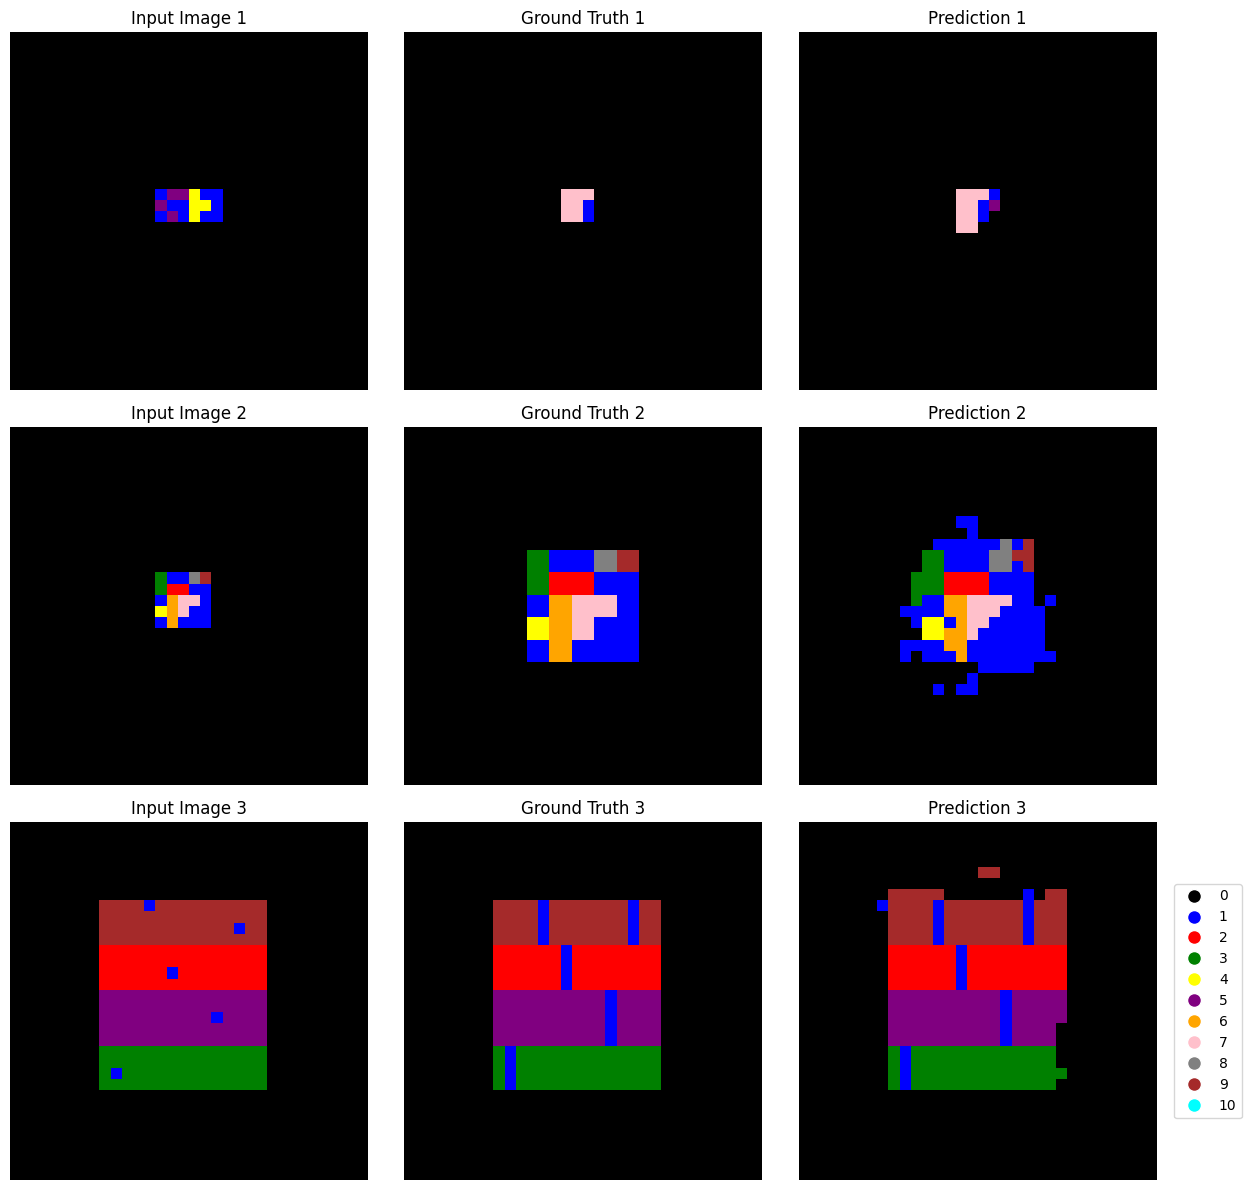

Test Average Loss: 5.383583 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.95%


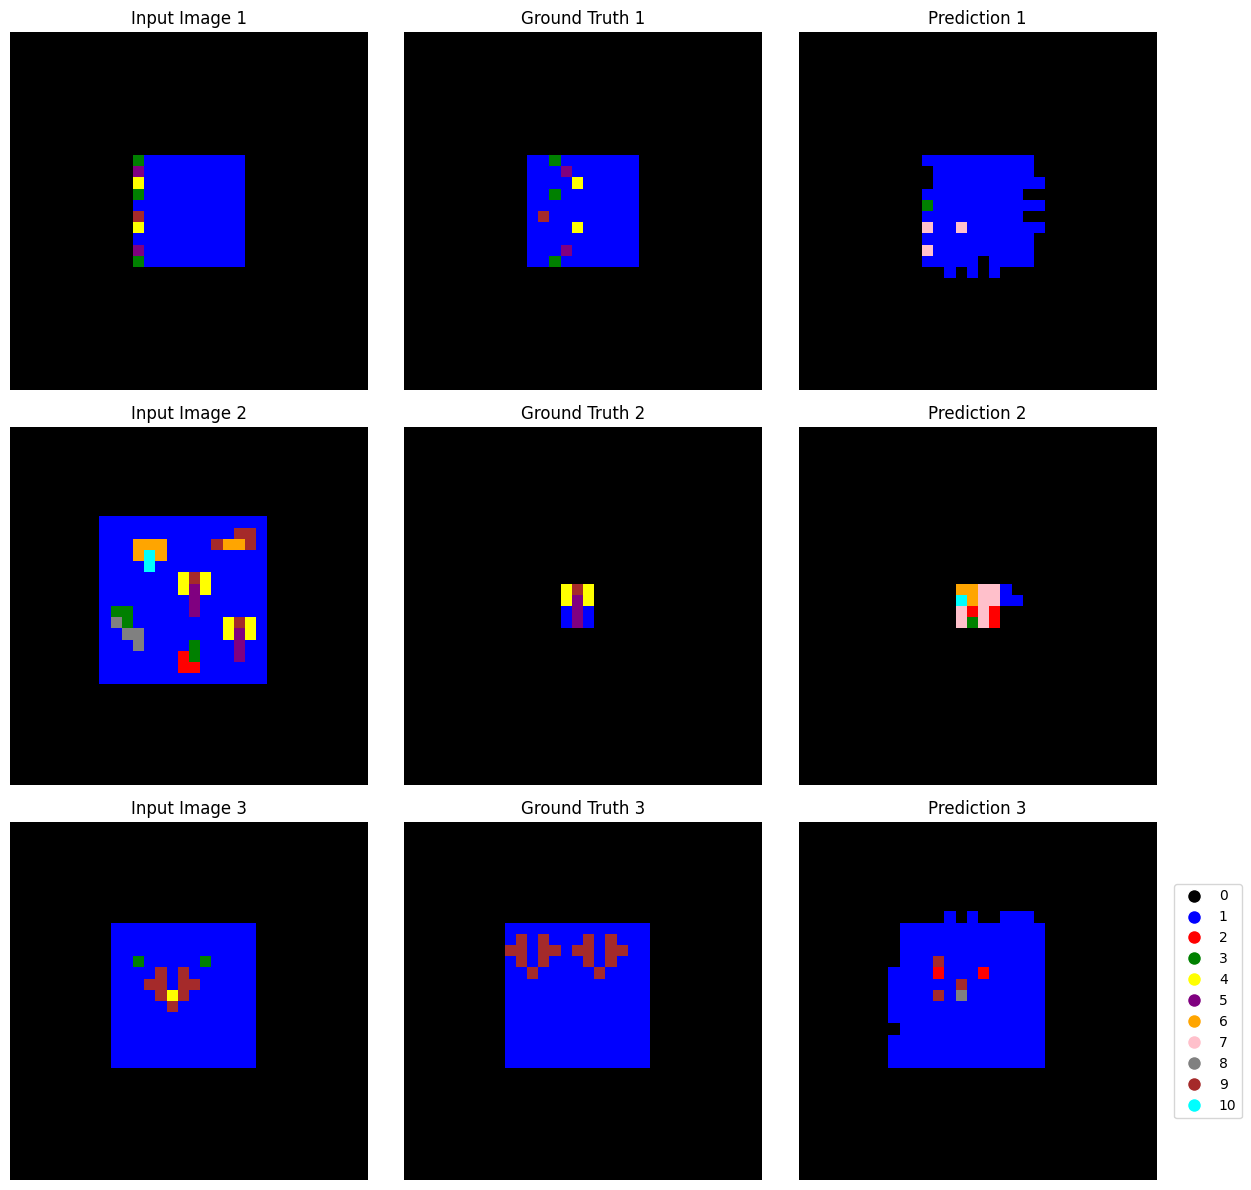

Epoch [801/1000] Complete | Average Loss: 0.022679 | Training Sample Accuracy: 8.4409% | Training Pixel Accuracy: 99.07%


Test Average Loss: 4.982193 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.77%


Epoch [802/1000] Complete | Average Loss: 0.017035 | Training Sample Accuracy: 13.2075% | Training Pixel Accuracy: 99.21%


Test Average Loss: 5.524007 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.08%


Epoch [803/1000] Complete | Average Loss: 0.013891 | Training Sample Accuracy: 15.9881% | Training Pixel Accuracy: 99.33%


Test Average Loss: 5.865705 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.14%


Epoch [804/1000] Complete | Average Loss: 0.011395 | Training Sample Accuracy: 11.2214% | Training Pixel Accuracy: 99.31%


Test Average Loss: 5.510534 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.88%


Epoch [805/1000] Complete | Average Loss: 0.010006 | Training Sample Accuracy: 16.8818% | Training Pixel Accuracy: 99.40%


Test Average Loss: 6.302165 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.15%


Epoch [806/1000] Complete | Average Loss: 0.009602 | Training Sample Accuracy: 16.5839% | Training Pixel Accuracy: 99.40%


Test Average Loss: 5.913668 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.97%


Epoch [807/1000] Complete | Average Loss: 0.008808 | Training Sample Accuracy: 18.8679% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.380069 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [808/1000] Complete | Average Loss: 0.007578 | Training Sample Accuracy: 19.7617% | Training Pixel Accuracy: 99.47%


Test Average Loss: 5.858338 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.21%


Epoch [809/1000] Complete | Average Loss: 0.006375 | Training Sample Accuracy: 21.6485% | Training Pixel Accuracy: 99.47%


Test Average Loss: 6.704690 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.51%


Epoch [810/1000] Complete | Average Loss: 0.006830 | Training Sample Accuracy: 25.4220% | Training Pixel Accuracy: 99.50%


Test Average Loss: 6.172883 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [811/1000] Complete | Average Loss: 0.006653 | Training Sample Accuracy: 20.3575% | Training Pixel Accuracy: 99.52%


Test Average Loss: 7.092452 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.48%


Epoch [812/1000] Complete | Average Loss: 0.006464 | Training Sample Accuracy: 23.9325% | Training Pixel Accuracy: 99.53%


Test Average Loss: 6.704844 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [813/1000] Complete | Average Loss: 0.006675 | Training Sample Accuracy: 23.8332% | Training Pixel Accuracy: 99.52%


Test Average Loss: 6.603904 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [814/1000] Complete | Average Loss: 0.006382 | Training Sample Accuracy: 22.2443% | Training Pixel Accuracy: 99.53%


Test Average Loss: 6.746832 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [815/1000] Complete | Average Loss: 0.007670 | Training Sample Accuracy: 25.6207% | Training Pixel Accuracy: 99.52%


Test Average Loss: 6.292909 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.18%


Epoch [816/1000] Complete | Average Loss: 0.007231 | Training Sample Accuracy: 26.9116% | Training Pixel Accuracy: 99.53%


Test Average Loss: 6.335673 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.30%


Epoch [817/1000] Complete | Average Loss: 0.006409 | Training Sample Accuracy: 26.9116% | Training Pixel Accuracy: 99.54%


Test Average Loss: 6.224101 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.33%


Epoch [818/1000] Complete | Average Loss: 0.007097 | Training Sample Accuracy: 24.8262% | Training Pixel Accuracy: 99.52%


Test Average Loss: 6.267410 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.25%


Epoch [819/1000] Complete | Average Loss: 0.006871 | Training Sample Accuracy: 22.3436% | Training Pixel Accuracy: 99.53%


Test Average Loss: 6.675792 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.47%


Epoch [820/1000] Complete | Average Loss: 0.007976 | Training Sample Accuracy: 25.9186% | Training Pixel Accuracy: 99.56%


Test Average Loss: 6.635818 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.27%


Epoch [821/1000] Complete | Average Loss: 0.007610 | Training Sample Accuracy: 23.4359% | Training Pixel Accuracy: 99.50%


Test Average Loss: 6.560801 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.45%


Epoch [822/1000] Complete | Average Loss: 0.008332 | Training Sample Accuracy: 20.7547% | Training Pixel Accuracy: 99.46%


Test Average Loss: 7.126230 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.31%


Epoch [823/1000] Complete | Average Loss: 0.009716 | Training Sample Accuracy: 23.6346% | Training Pixel Accuracy: 99.50%


Test Average Loss: 7.173838 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.45%


Epoch [824/1000] Complete | Average Loss: 0.009874 | Training Sample Accuracy: 14.8957% | Training Pixel Accuracy: 99.42%


Test Average Loss: 6.531221 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.25%


Epoch [825/1000] Complete | Average Loss: 0.011306 | Training Sample Accuracy: 19.7617% | Training Pixel Accuracy: 99.47%


Test Average Loss: 6.262436 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.15%


Epoch [826/1000] Complete | Average Loss: 0.011169 | Training Sample Accuracy: 17.2790% | Training Pixel Accuracy: 99.44%


Test Average Loss: 7.039991 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.48%


Epoch [827/1000] Complete | Average Loss: 0.011959 | Training Sample Accuracy: 17.8749% | Training Pixel Accuracy: 99.42%


Test Average Loss: 6.798169 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.30%


Epoch [828/1000] Complete | Average Loss: 0.012593 | Training Sample Accuracy: 21.1519% | Training Pixel Accuracy: 99.43%


Test Average Loss: 8.103466 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.34%


Epoch [829/1000] Complete | Average Loss: 0.014559 | Training Sample Accuracy: 14.1013% | Training Pixel Accuracy: 99.34%


Test Average Loss: 5.639664 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.83%


Epoch [830/1000] Complete | Average Loss: 0.015609 | Training Sample Accuracy: 12.5124% | Training Pixel Accuracy: 99.29%


Test Average Loss: 6.135957 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.66%


Epoch [831/1000] Complete | Average Loss: 0.013957 | Training Sample Accuracy: 15.9881% | Training Pixel Accuracy: 99.32%


Test Average Loss: 6.118455 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.87%


Epoch [832/1000] Complete | Average Loss: 0.016472 | Training Sample Accuracy: 15.2929% | Training Pixel Accuracy: 99.30%


Test Average Loss: 5.856036 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.98%


Epoch [833/1000] Complete | Average Loss: 0.019127 | Training Sample Accuracy: 14.2006% | Training Pixel Accuracy: 99.28%


Test Average Loss: 5.335966 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.80%


Epoch [834/1000] Complete | Average Loss: 0.021153 | Training Sample Accuracy: 12.1152% | Training Pixel Accuracy: 99.23%


Test Average Loss: 4.912101 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.64%


Epoch [835/1000] Complete | Average Loss: 0.020917 | Training Sample Accuracy: 13.6048% | Training Pixel Accuracy: 99.24%


Test Average Loss: 5.625139 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.57%


Epoch [836/1000] Complete | Average Loss: 0.021852 | Training Sample Accuracy: 15.3923% | Training Pixel Accuracy: 99.24%


Test Average Loss: 6.877473 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.81%


Epoch [837/1000] Complete | Average Loss: 0.022111 | Training Sample Accuracy: 10.0298% | Training Pixel Accuracy: 99.14%


Test Average Loss: 5.623581 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.89%


Epoch [838/1000] Complete | Average Loss: 0.022919 | Training Sample Accuracy: 12.3138% | Training Pixel Accuracy: 99.21%


Test Average Loss: 5.993741 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.08%


Epoch [839/1000] Complete | Average Loss: 0.039524 | Training Sample Accuracy: 3.8729% | Training Pixel Accuracy: 98.45%


Test Average Loss: 5.992471 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.48%


Epoch [840/1000] Complete | Average Loss: 0.041297 | Training Sample Accuracy: 3.4757% | Training Pixel Accuracy: 98.63%


Test Average Loss: 6.068521 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.54%


Epoch [841/1000] Complete | Average Loss: 0.036568 | Training Sample Accuracy: 5.6604% | Training Pixel Accuracy: 98.86%


Test Average Loss: 5.796811 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.63%


Epoch [842/1000] Complete | Average Loss: 0.031007 | Training Sample Accuracy: 8.3416% | Training Pixel Accuracy: 98.95%


Test Average Loss: 5.506132 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.82%


Epoch [843/1000] Complete | Average Loss: 0.026988 | Training Sample Accuracy: 9.2354% | Training Pixel Accuracy: 99.02%


Test Average Loss: 5.873310 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.64%


Epoch [844/1000] Complete | Average Loss: 0.062922 | Training Sample Accuracy: 7.2493% | Training Pixel Accuracy: 98.85%


Test Average Loss: 4.966909 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.32%


Epoch [845/1000] Complete | Average Loss: 0.077447 | Training Sample Accuracy: 2.4826% | Training Pixel Accuracy: 98.50%


Test Average Loss: 4.915877 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.24%


Epoch [846/1000] Complete | Average Loss: 0.077757 | Training Sample Accuracy: 2.4826% | Training Pixel Accuracy: 98.46%


Test Average Loss: 5.233320 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.36%


Epoch [847/1000] Complete | Average Loss: 0.070807 | Training Sample Accuracy: 3.5750% | Training Pixel Accuracy: 98.48%


Test Average Loss: 4.128862 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.37%


Epoch [848/1000] Complete | Average Loss: 0.075424 | Training Sample Accuracy: 2.7805% | Training Pixel Accuracy: 98.52%


Test Average Loss: 3.715242 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.69%


Epoch [849/1000] Complete | Average Loss: 0.063688 | Training Sample Accuracy: 3.6743% | Training Pixel Accuracy: 98.62%


Test Average Loss: 5.203384 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.55%


Epoch [850/1000] Complete | Average Loss: 0.052062 | Training Sample Accuracy: 5.5611% | Training Pixel Accuracy: 98.78%


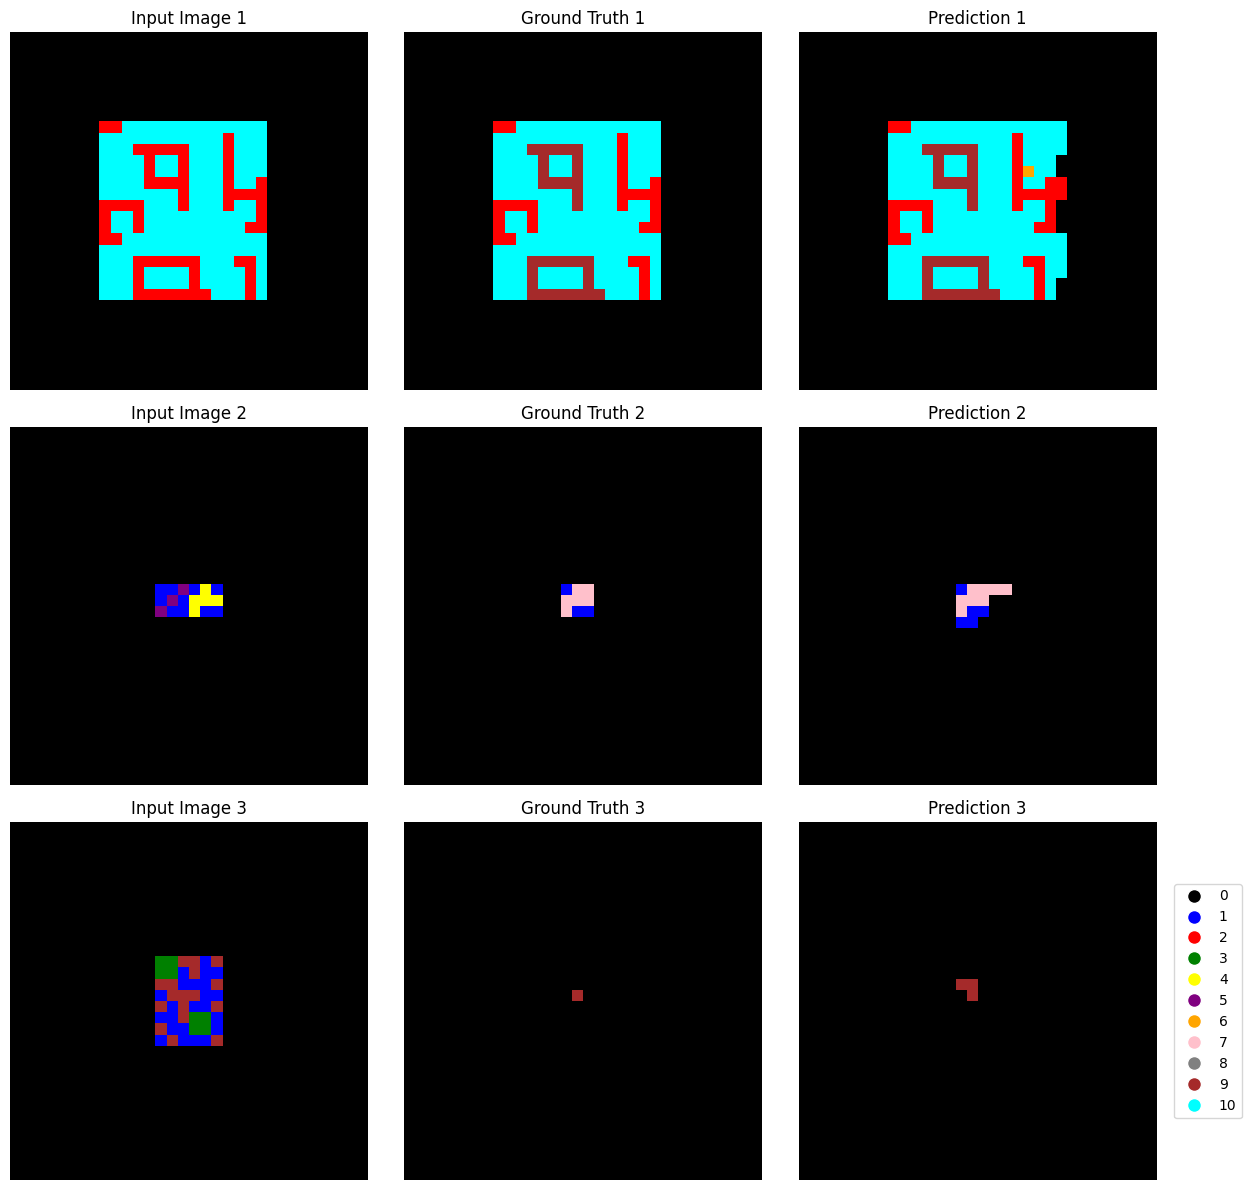

Test Average Loss: 4.911789 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.55%


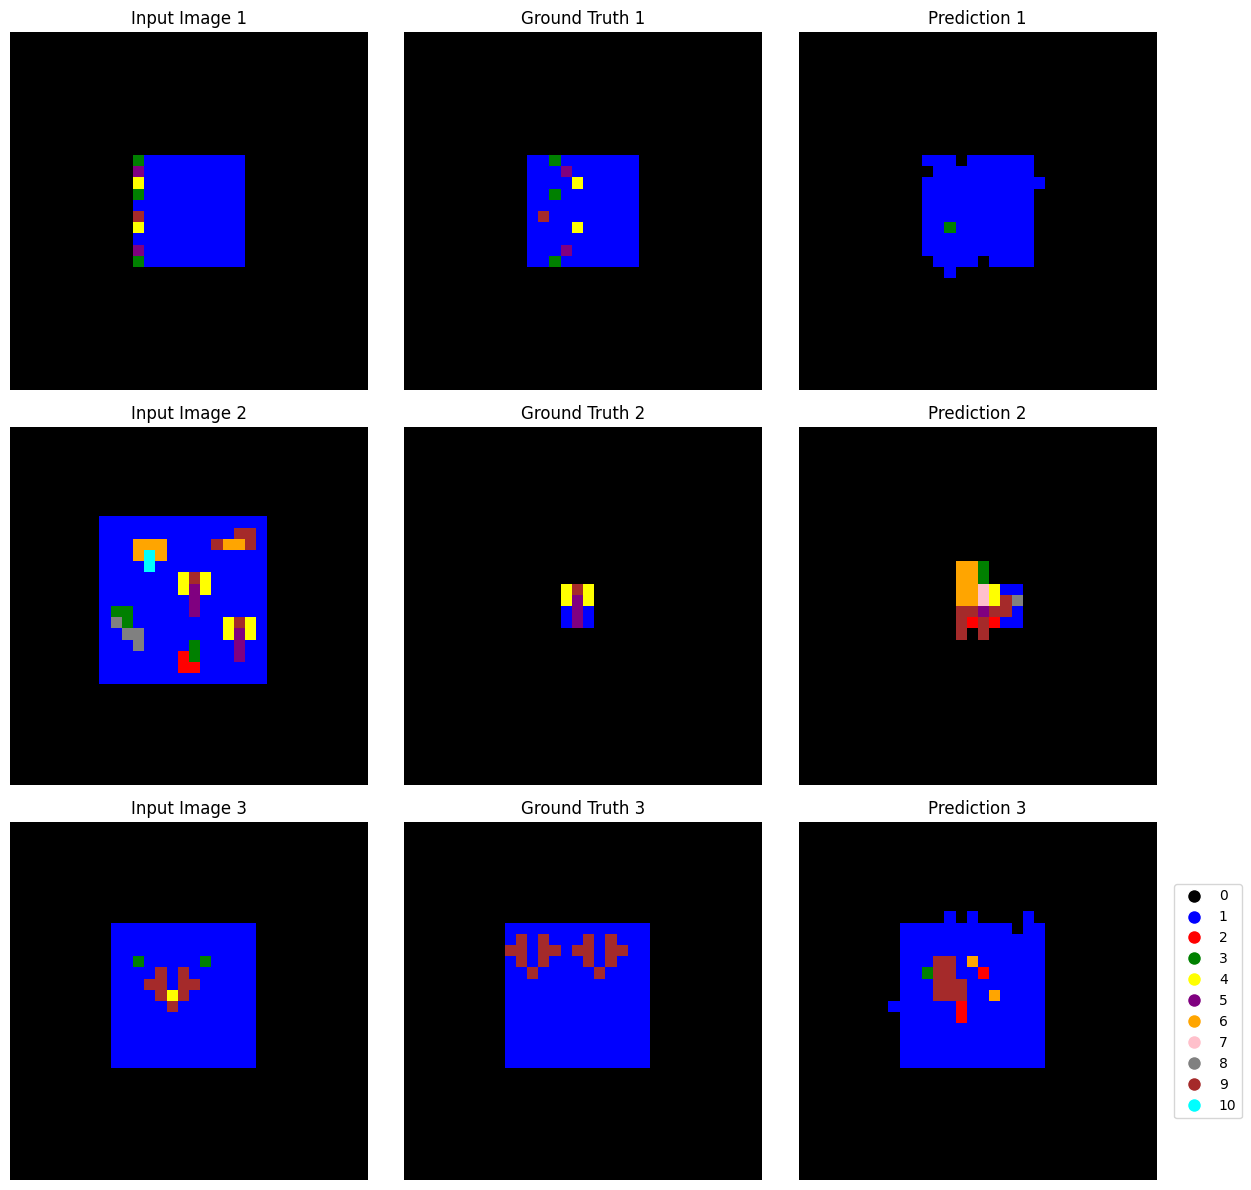

Epoch [851/1000] Complete | Average Loss: 0.034351 | Training Sample Accuracy: 5.5611% | Training Pixel Accuracy: 98.94%


Test Average Loss: 5.379636 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.81%


Epoch [852/1000] Complete | Average Loss: 0.021923 | Training Sample Accuracy: 9.3347% | Training Pixel Accuracy: 99.07%


Test Average Loss: 5.531466 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.12%


Epoch [853/1000] Complete | Average Loss: 0.014529 | Training Sample Accuracy: 10.6256% | Training Pixel Accuracy: 99.15%


Test Average Loss: 4.850835 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.81%


Epoch [854/1000] Complete | Average Loss: 0.010320 | Training Sample Accuracy: 13.8034% | Training Pixel Accuracy: 99.26%


Test Average Loss: 5.811102 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.17%


Epoch [855/1000] Complete | Average Loss: 0.008346 | Training Sample Accuracy: 15.0943% | Training Pixel Accuracy: 99.34%


Test Average Loss: 5.983760 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.43%


Epoch [856/1000] Complete | Average Loss: 0.006774 | Training Sample Accuracy: 17.5770% | Training Pixel Accuracy: 99.40%


Test Average Loss: 6.331574 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.39%


Epoch [857/1000] Complete | Average Loss: 0.006791 | Training Sample Accuracy: 19.7617% | Training Pixel Accuracy: 99.43%


Test Average Loss: 6.436147 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [858/1000] Complete | Average Loss: 0.006368 | Training Sample Accuracy: 20.9533% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.429222 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.33%


Epoch [859/1000] Complete | Average Loss: 0.005904 | Training Sample Accuracy: 19.4638% | Training Pixel Accuracy: 99.47%


Test Average Loss: 6.389901 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.37%


Epoch [860/1000] Complete | Average Loss: 0.005586 | Training Sample Accuracy: 24.5283% | Training Pixel Accuracy: 99.51%


Test Average Loss: 6.607567 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.40%


Epoch [861/1000] Complete | Average Loss: 0.004845 | Training Sample Accuracy: 26.1172% | Training Pixel Accuracy: 99.52%


Test Average Loss: 6.590845 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.46%


Epoch [862/1000] Complete | Average Loss: 0.004588 | Training Sample Accuracy: 25.8193% | Training Pixel Accuracy: 99.55%


Test Average Loss: 6.798004 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.47%


Epoch [863/1000] Complete | Average Loss: 0.004448 | Training Sample Accuracy: 28.8977% | Training Pixel Accuracy: 99.55%


Test Average Loss: 6.050695 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [864/1000] Complete | Average Loss: 0.004824 | Training Sample Accuracy: 27.1102% | Training Pixel Accuracy: 99.51%


Test Average Loss: 6.768560 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.50%


Epoch [865/1000] Complete | Average Loss: 0.004948 | Training Sample Accuracy: 29.3942% | Training Pixel Accuracy: 99.55%


Test Average Loss: 6.358423 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.38%


Epoch [866/1000] Complete | Average Loss: 0.004315 | Training Sample Accuracy: 28.3019% | Training Pixel Accuracy: 99.57%


Test Average Loss: 6.352607 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.51%


Epoch [867/1000] Complete | Average Loss: 0.004540 | Training Sample Accuracy: 25.9186% | Training Pixel Accuracy: 99.54%


Test Average Loss: 6.344413 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.41%


Epoch [868/1000] Complete | Average Loss: 0.005170 | Training Sample Accuracy: 27.1102% | Training Pixel Accuracy: 99.57%


Test Average Loss: 6.526570 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.44%


Epoch [869/1000] Complete | Average Loss: 0.005001 | Training Sample Accuracy: 25.8193% | Training Pixel Accuracy: 99.55%


Test Average Loss: 6.555100 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.44%


Epoch [870/1000] Complete | Average Loss: 0.004897 | Training Sample Accuracy: 26.7130% | Training Pixel Accuracy: 99.56%


Test Average Loss: 6.523854 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.52%


Epoch [871/1000] Complete | Average Loss: 0.004641 | Training Sample Accuracy: 29.6922% | Training Pixel Accuracy: 99.59%


Test Average Loss: 6.447617 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.53%


Epoch [872/1000] Complete | Average Loss: 0.004080 | Training Sample Accuracy: 27.0109% | Training Pixel Accuracy: 99.58%


Test Average Loss: 6.910865 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.48%


Epoch [873/1000] Complete | Average Loss: 0.004850 | Training Sample Accuracy: 30.6852% | Training Pixel Accuracy: 99.60%


Test Average Loss: 6.764285 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.43%


Epoch [874/1000] Complete | Average Loss: 0.004768 | Training Sample Accuracy: 27.3088% | Training Pixel Accuracy: 99.56%


Test Average Loss: 7.080936 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.56%


Epoch [875/1000] Complete | Average Loss: 0.004453 | Training Sample Accuracy: 32.3734% | Training Pixel Accuracy: 99.61%


Test Average Loss: 6.988362 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.47%


Epoch [876/1000] Complete | Average Loss: 0.004097 | Training Sample Accuracy: 32.5720% | Training Pixel Accuracy: 99.62%


Test Average Loss: 7.133639 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.48%


Epoch [877/1000] Complete | Average Loss: 0.004379 | Training Sample Accuracy: 31.8769% | Training Pixel Accuracy: 99.63%


Test Average Loss: 6.840215 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.40%


Epoch [878/1000] Complete | Average Loss: 0.004756 | Training Sample Accuracy: 28.5998% | Training Pixel Accuracy: 99.58%


Test Average Loss: 6.818477 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.33%


Epoch [879/1000] Complete | Average Loss: 0.004560 | Training Sample Accuracy: 30.2880% | Training Pixel Accuracy: 99.60%


Test Average Loss: 7.501360 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.42%


Epoch [880/1000] Complete | Average Loss: 0.004764 | Training Sample Accuracy: 33.6643% | Training Pixel Accuracy: 99.61%


Test Average Loss: 7.088272 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.40%


Epoch [881/1000] Complete | Average Loss: 0.005156 | Training Sample Accuracy: 29.3942% | Training Pixel Accuracy: 99.61%


Test Average Loss: 6.917062 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.17%


Epoch [882/1000] Complete | Average Loss: 0.004820 | Training Sample Accuracy: 32.6713% | Training Pixel Accuracy: 99.60%


Test Average Loss: 6.682328 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.37%


Epoch [883/1000] Complete | Average Loss: 0.005397 | Training Sample Accuracy: 31.5789% | Training Pixel Accuracy: 99.62%


Test Average Loss: 7.116167 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [884/1000] Complete | Average Loss: 0.004748 | Training Sample Accuracy: 31.2810% | Training Pixel Accuracy: 99.61%


Test Average Loss: 7.098511 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.38%


Epoch [885/1000] Complete | Average Loss: 0.004402 | Training Sample Accuracy: 27.3088% | Training Pixel Accuracy: 99.62%


Test Average Loss: 7.098834 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.43%


Epoch [886/1000] Complete | Average Loss: 0.004367 | Training Sample Accuracy: 29.9901% | Training Pixel Accuracy: 99.63%


Test Average Loss: 6.937815 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.25%


Epoch [887/1000] Complete | Average Loss: 0.004637 | Training Sample Accuracy: 33.6643% | Training Pixel Accuracy: 99.65%


Test Average Loss: 7.260704 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.39%


Epoch [888/1000] Complete | Average Loss: 0.004188 | Training Sample Accuracy: 30.7845% | Training Pixel Accuracy: 99.61%


Test Average Loss: 7.398906 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.43%


Epoch [889/1000] Complete | Average Loss: 0.004304 | Training Sample Accuracy: 33.3664% | Training Pixel Accuracy: 99.66%


Test Average Loss: 7.272403 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [890/1000] Complete | Average Loss: 0.006590 | Training Sample Accuracy: 30.0894% | Training Pixel Accuracy: 99.62%


Test Average Loss: 6.814154 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [891/1000] Complete | Average Loss: 0.017359 | Training Sample Accuracy: 26.1172% | Training Pixel Accuracy: 99.52%


Test Average Loss: 7.367988 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.53%


Epoch [892/1000] Complete | Average Loss: 0.022809 | Training Sample Accuracy: 10.5263% | Training Pixel Accuracy: 99.22%


Test Average Loss: 6.821764 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.84%


Epoch [893/1000] Complete | Average Loss: 0.026624 | Training Sample Accuracy: 12.0159% | Training Pixel Accuracy: 99.19%


Test Average Loss: 7.112095 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.08%


Epoch [894/1000] Complete | Average Loss: 0.025340 | Training Sample Accuracy: 14.4985% | Training Pixel Accuracy: 99.26%


Test Average Loss: 5.288420 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.91%


Epoch [895/1000] Complete | Average Loss: 0.036015 | Training Sample Accuracy: 6.4548% | Training Pixel Accuracy: 98.99%


Test Average Loss: 5.755295 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.49%


Epoch [896/1000] Complete | Average Loss: 0.035356 | Training Sample Accuracy: 7.7458% | Training Pixel Accuracy: 99.08%


Test Average Loss: 7.846173 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.81%


Epoch [897/1000] Complete | Average Loss: 0.054775 | Training Sample Accuracy: 5.9583% | Training Pixel Accuracy: 98.85%


Test Average Loss: 5.339024 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.68%


Epoch [898/1000] Complete | Average Loss: 0.036917 | Training Sample Accuracy: 4.4687% | Training Pixel Accuracy: 98.87%


Test Average Loss: 6.097866 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.29%


Epoch [899/1000] Complete | Average Loss: 0.026684 | Training Sample Accuracy: 7.2493% | Training Pixel Accuracy: 99.07%


Test Average Loss: 4.984964 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.95%


Epoch [900/1000] Complete | Average Loss: 0.020189 | Training Sample Accuracy: 8.5402% | Training Pixel Accuracy: 99.16%


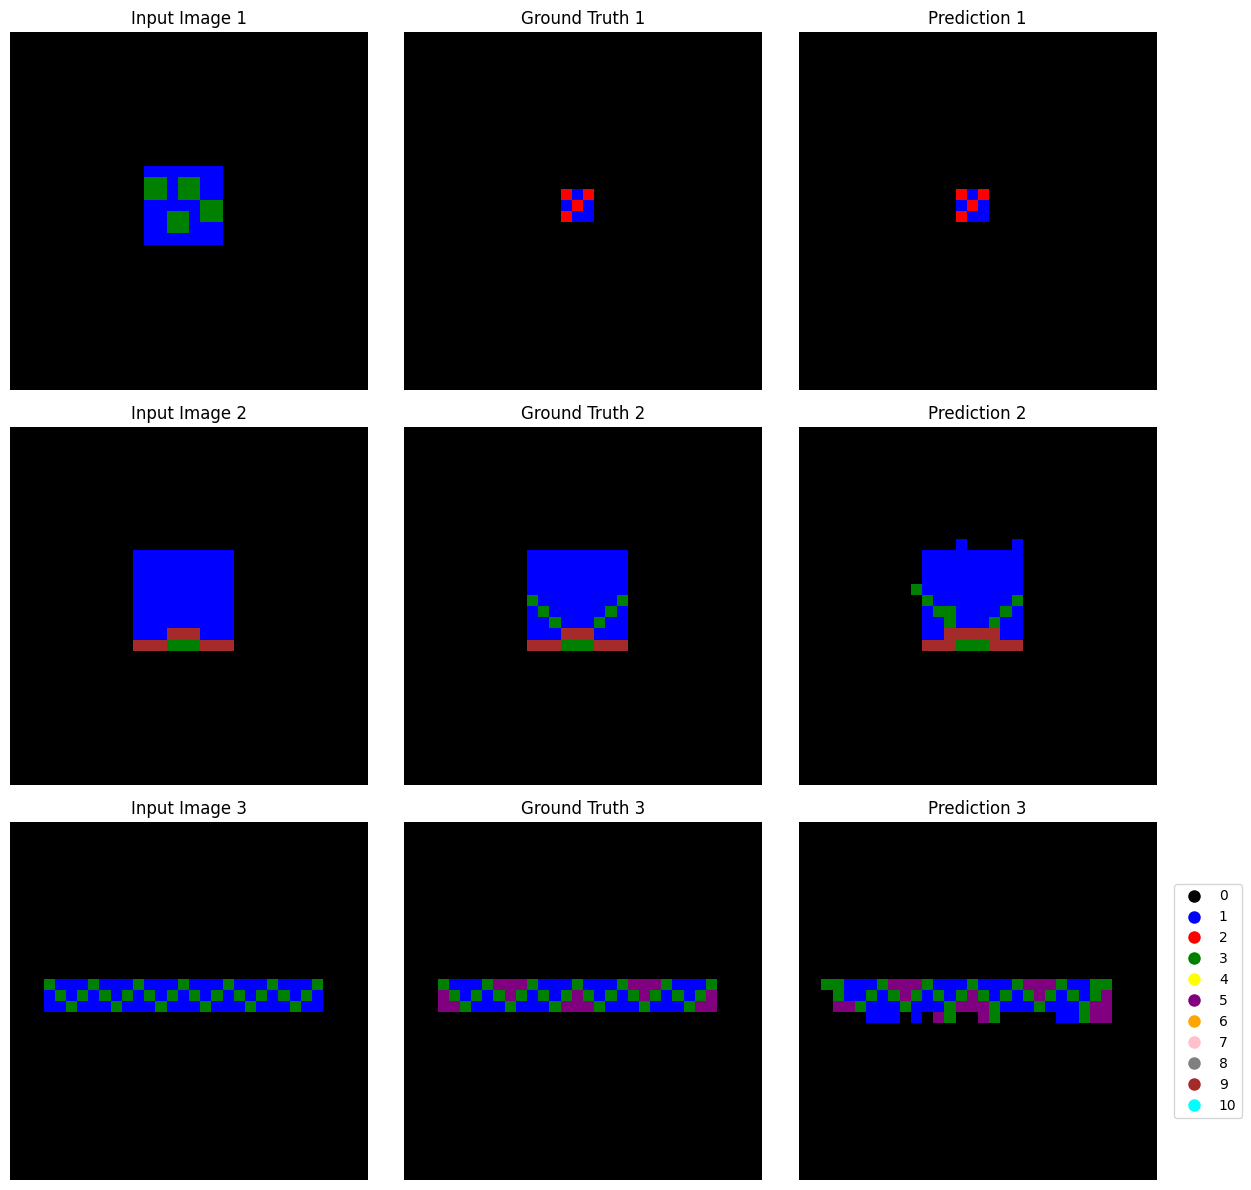

Test Average Loss: 5.742371 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.27%


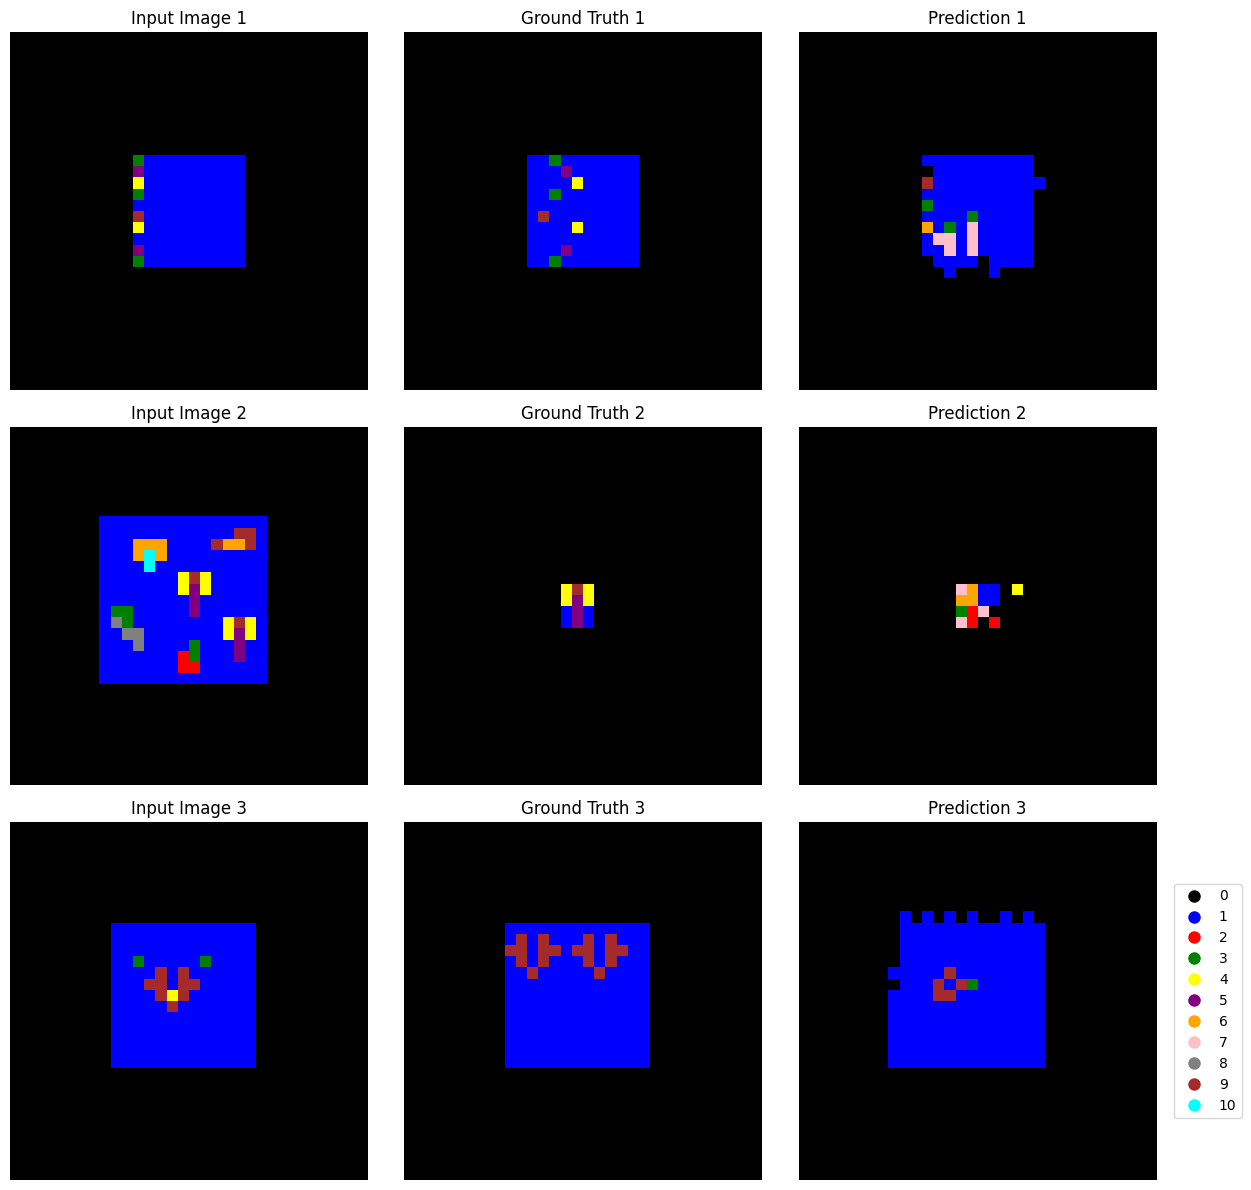

Epoch [901/1000] Complete | Average Loss: 0.014387 | Training Sample Accuracy: 11.4201% | Training Pixel Accuracy: 99.29%


Test Average Loss: 5.852995 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.38%


Epoch [902/1000] Complete | Average Loss: 0.011510 | Training Sample Accuracy: 16.7825% | Training Pixel Accuracy: 99.36%


Test Average Loss: 6.734727 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.42%


Epoch [903/1000] Complete | Average Loss: 0.009739 | Training Sample Accuracy: 17.6763% | Training Pixel Accuracy: 99.40%


Test Average Loss: 6.352808 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.51%


Epoch [904/1000] Complete | Average Loss: 0.009254 | Training Sample Accuracy: 17.3784% | Training Pixel Accuracy: 99.46%


Test Average Loss: 6.442979 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [905/1000] Complete | Average Loss: 0.009878 | Training Sample Accuracy: 18.6693% | Training Pixel Accuracy: 99.42%


Test Average Loss: 6.970819 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [906/1000] Complete | Average Loss: 0.010730 | Training Sample Accuracy: 17.5770% | Training Pixel Accuracy: 99.43%


Test Average Loss: 6.610574 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.42%


Epoch [907/1000] Complete | Average Loss: 0.009233 | Training Sample Accuracy: 22.7408% | Training Pixel Accuracy: 99.48%


Test Average Loss: 6.940893 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.45%


Epoch [908/1000] Complete | Average Loss: 0.008119 | Training Sample Accuracy: 25.9186% | Training Pixel Accuracy: 99.51%


Test Average Loss: 6.585095 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.37%


Epoch [909/1000] Complete | Average Loss: 0.007081 | Training Sample Accuracy: 22.7408% | Training Pixel Accuracy: 99.48%


Test Average Loss: 7.239712 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.60%


Epoch [910/1000] Complete | Average Loss: 0.006190 | Training Sample Accuracy: 24.8262% | Training Pixel Accuracy: 99.51%


Test Average Loss: 6.217425 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.38%


Epoch [911/1000] Complete | Average Loss: 0.007205 | Training Sample Accuracy: 25.9186% | Training Pixel Accuracy: 99.54%


Test Average Loss: 6.565358 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.38%


Epoch [912/1000] Complete | Average Loss: 0.006950 | Training Sample Accuracy: 24.0318% | Training Pixel Accuracy: 99.53%


Test Average Loss: 6.849494 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.49%


Epoch [913/1000] Complete | Average Loss: 0.008200 | Training Sample Accuracy: 23.3366% | Training Pixel Accuracy: 99.54%


Test Average Loss: 7.039791 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.20%


Epoch [914/1000] Complete | Average Loss: 0.010143 | Training Sample Accuracy: 20.7547% | Training Pixel Accuracy: 99.41%


Test Average Loss: 5.823984 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [915/1000] Complete | Average Loss: 0.009298 | Training Sample Accuracy: 18.8679% | Training Pixel Accuracy: 99.46%


Test Average Loss: 6.415755 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.37%


Epoch [916/1000] Complete | Average Loss: 0.008034 | Training Sample Accuracy: 20.4568% | Training Pixel Accuracy: 99.50%


Test Average Loss: 5.809120 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [917/1000] Complete | Average Loss: 0.007347 | Training Sample Accuracy: 22.5422% | Training Pixel Accuracy: 99.49%


Test Average Loss: 6.216978 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [918/1000] Complete | Average Loss: 0.006473 | Training Sample Accuracy: 22.4429% | Training Pixel Accuracy: 99.53%


Test Average Loss: 6.182751 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.30%


Epoch [919/1000] Complete | Average Loss: 0.005828 | Training Sample Accuracy: 24.7269% | Training Pixel Accuracy: 99.54%


Test Average Loss: 6.160981 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [920/1000] Complete | Average Loss: 0.005744 | Training Sample Accuracy: 26.0179% | Training Pixel Accuracy: 99.57%


Test Average Loss: 6.697547 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.33%


Epoch [921/1000] Complete | Average Loss: 0.005697 | Training Sample Accuracy: 25.4220% | Training Pixel Accuracy: 99.56%


Test Average Loss: 7.068217 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.51%


Epoch [922/1000] Complete | Average Loss: 0.005935 | Training Sample Accuracy: 23.7339% | Training Pixel Accuracy: 99.52%


Test Average Loss: 5.771684 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [923/1000] Complete | Average Loss: 0.005930 | Training Sample Accuracy: 26.9116% | Training Pixel Accuracy: 99.58%


Test Average Loss: 6.385966 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.46%


Epoch [924/1000] Complete | Average Loss: 0.008893 | Training Sample Accuracy: 23.2373% | Training Pixel Accuracy: 99.53%


Test Average Loss: 6.170985 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [925/1000] Complete | Average Loss: 0.009973 | Training Sample Accuracy: 26.8123% | Training Pixel Accuracy: 99.54%


Test Average Loss: 6.143868 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.25%


Epoch [926/1000] Complete | Average Loss: 0.012569 | Training Sample Accuracy: 25.7200% | Training Pixel Accuracy: 99.56%


Test Average Loss: 6.542193 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.27%


Epoch [927/1000] Complete | Average Loss: 0.018152 | Training Sample Accuracy: 17.5770% | Training Pixel Accuracy: 99.36%


Test Average Loss: 5.660818 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.10%


Epoch [928/1000] Complete | Average Loss: 0.020118 | Training Sample Accuracy: 14.8957% | Training Pixel Accuracy: 99.31%


Test Average Loss: 5.177878 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.49%


Epoch [929/1000] Complete | Average Loss: 0.021804 | Training Sample Accuracy: 13.5055% | Training Pixel Accuracy: 99.28%


Test Average Loss: 4.672802 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.74%


Epoch [930/1000] Complete | Average Loss: 0.018988 | Training Sample Accuracy: 16.0874% | Training Pixel Accuracy: 99.37%


Test Average Loss: 6.095048 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [931/1000] Complete | Average Loss: 0.018100 | Training Sample Accuracy: 14.2006% | Training Pixel Accuracy: 99.36%


Test Average Loss: 6.323078 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.41%


Epoch [932/1000] Complete | Average Loss: 0.015821 | Training Sample Accuracy: 14.3992% | Training Pixel Accuracy: 99.37%


Test Average Loss: 5.200650 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.68%


Epoch [933/1000] Complete | Average Loss: 0.014743 | Training Sample Accuracy: 17.8749% | Training Pixel Accuracy: 99.37%


Test Average Loss: 6.501900 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.28%


Epoch [934/1000] Complete | Average Loss: 0.014312 | Training Sample Accuracy: 16.4846% | Training Pixel Accuracy: 99.38%


Test Average Loss: 6.299888 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [935/1000] Complete | Average Loss: 0.013511 | Training Sample Accuracy: 17.5770% | Training Pixel Accuracy: 99.38%


Test Average Loss: 6.846294 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.25%


Epoch [936/1000] Complete | Average Loss: 0.011416 | Training Sample Accuracy: 19.7617% | Training Pixel Accuracy: 99.42%


Test Average Loss: 5.750781 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.15%


Epoch [937/1000] Complete | Average Loss: 0.010173 | Training Sample Accuracy: 20.4568% | Training Pixel Accuracy: 99.45%


Test Average Loss: 6.684764 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.51%


Epoch [938/1000] Complete | Average Loss: 0.009344 | Training Sample Accuracy: 21.0526% | Training Pixel Accuracy: 99.47%


Test Average Loss: 5.697444 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.07%


Epoch [939/1000] Complete | Average Loss: 0.009605 | Training Sample Accuracy: 17.6763% | Training Pixel Accuracy: 99.44%


Test Average Loss: 6.131656 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.21%


Epoch [940/1000] Complete | Average Loss: 0.010503 | Training Sample Accuracy: 22.3436% | Training Pixel Accuracy: 99.46%


Test Average Loss: 5.886094 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.24%


Epoch [941/1000] Complete | Average Loss: 0.008552 | Training Sample Accuracy: 21.7478% | Training Pixel Accuracy: 99.47%


Test Average Loss: 5.667930 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.17%


Epoch [942/1000] Complete | Average Loss: 0.008709 | Training Sample Accuracy: 22.8401% | Training Pixel Accuracy: 99.51%


Test Average Loss: 6.917017 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.56%


Epoch [943/1000] Complete | Average Loss: 0.009176 | Training Sample Accuracy: 19.9603% | Training Pixel Accuracy: 99.49%


Test Average Loss: 6.125317 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [944/1000] Complete | Average Loss: 0.009400 | Training Sample Accuracy: 15.3923% | Training Pixel Accuracy: 99.41%


Test Average Loss: 6.761325 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.37%


Epoch [945/1000] Complete | Average Loss: 0.009636 | Training Sample Accuracy: 19.1658% | Training Pixel Accuracy: 99.35%


Test Average Loss: 5.327706 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.36%


Epoch [946/1000] Complete | Average Loss: 0.009079 | Training Sample Accuracy: 17.7756% | Training Pixel Accuracy: 99.34%


Test Average Loss: 5.755635 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.85%


Epoch [947/1000] Complete | Average Loss: 0.007721 | Training Sample Accuracy: 24.3297% | Training Pixel Accuracy: 99.50%


Test Average Loss: 6.826583 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.31%


Epoch [948/1000] Complete | Average Loss: 0.009369 | Training Sample Accuracy: 20.0596% | Training Pixel Accuracy: 99.48%


Test Average Loss: 6.519954 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.20%


Epoch [949/1000] Complete | Average Loss: 0.007797 | Training Sample Accuracy: 24.8262% | Training Pixel Accuracy: 99.50%


Test Average Loss: 6.581753 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.36%


Epoch [950/1000] Complete | Average Loss: 0.007602 | Training Sample Accuracy: 26.6137% | Training Pixel Accuracy: 99.51%


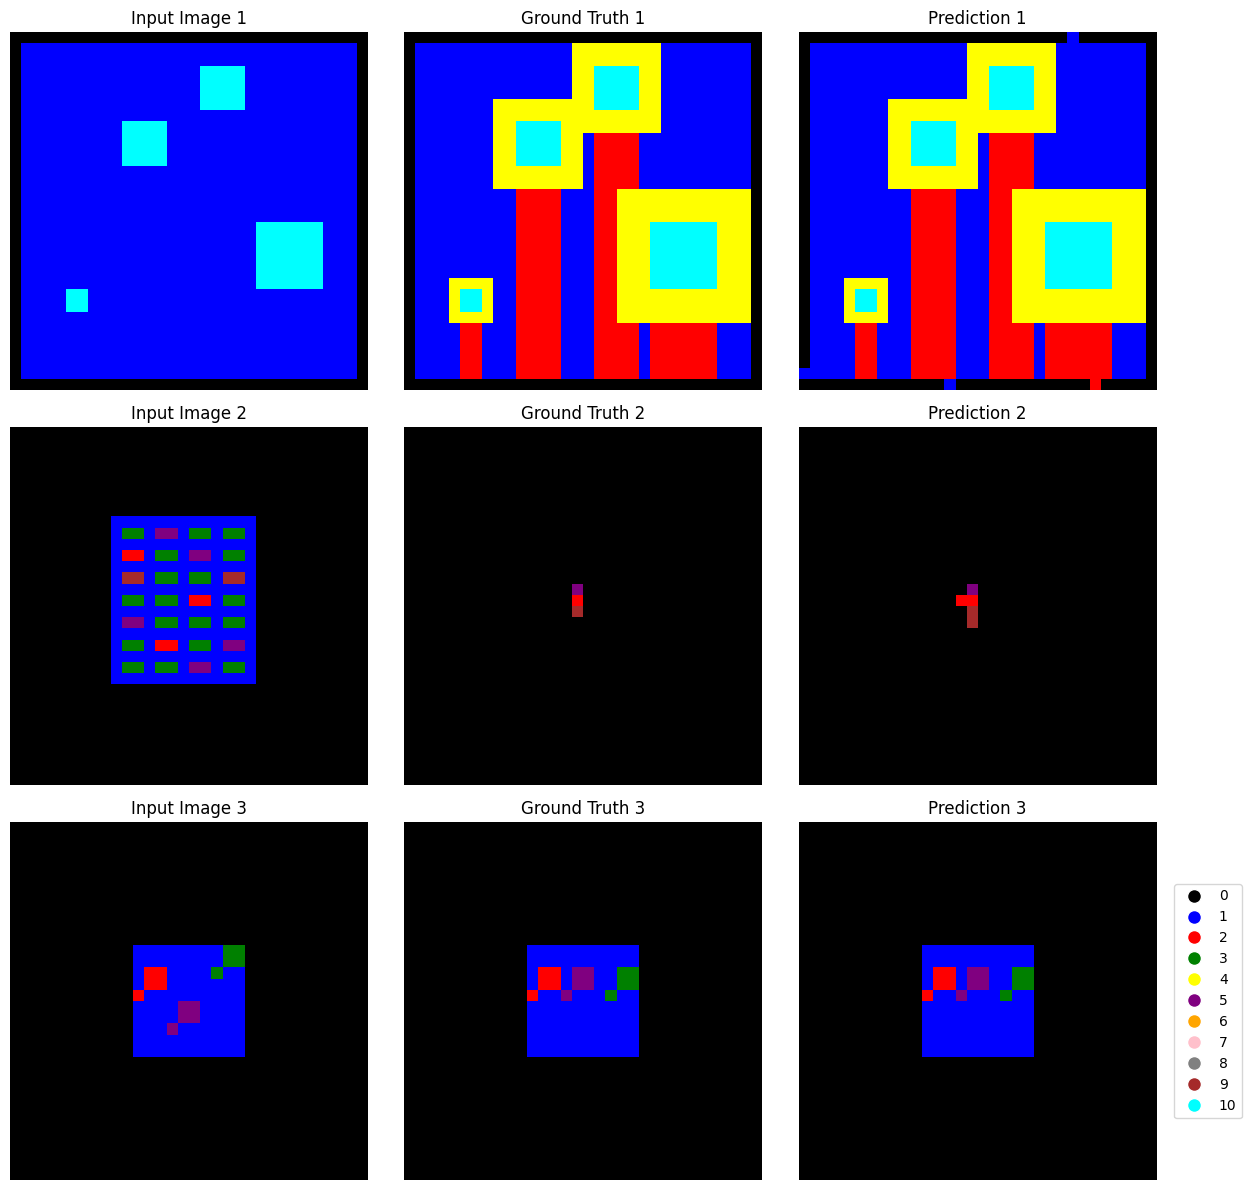

Test Average Loss: 6.244568 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.10%


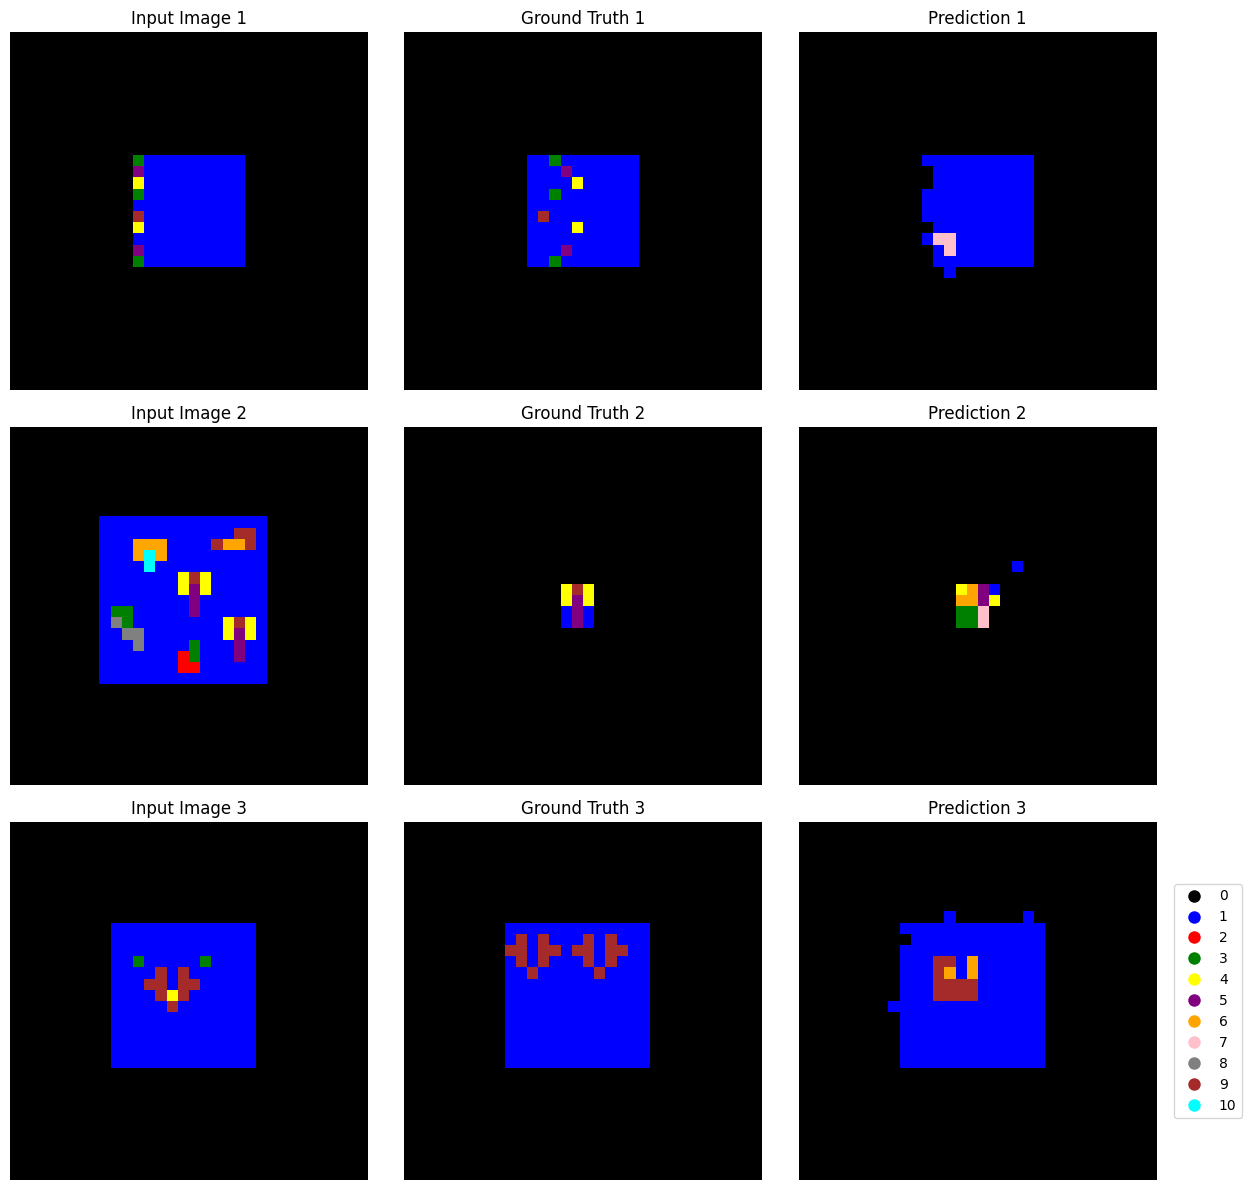

Epoch [951/1000] Complete | Average Loss: 0.007137 | Training Sample Accuracy: 23.3366% | Training Pixel Accuracy: 99.55%


Test Average Loss: 6.677884 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.42%


Epoch [952/1000] Complete | Average Loss: 0.006339 | Training Sample Accuracy: 24.5283% | Training Pixel Accuracy: 99.55%


Test Average Loss: 6.756078 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.39%


Epoch [953/1000] Complete | Average Loss: 0.005762 | Training Sample Accuracy: 27.5074% | Training Pixel Accuracy: 99.57%


Test Average Loss: 6.196166 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.38%


Epoch [954/1000] Complete | Average Loss: 0.006034 | Training Sample Accuracy: 31.2810% | Training Pixel Accuracy: 99.61%


Test Average Loss: 6.379245 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.44%


Epoch [955/1000] Complete | Average Loss: 0.006855 | Training Sample Accuracy: 28.1033% | Training Pixel Accuracy: 99.59%


Test Average Loss: 6.747159 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.57%


Epoch [956/1000] Complete | Average Loss: 0.006736 | Training Sample Accuracy: 22.8401% | Training Pixel Accuracy: 99.55%


Test Average Loss: 6.272511 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.52%


Epoch [957/1000] Complete | Average Loss: 0.006724 | Training Sample Accuracy: 24.8262% | Training Pixel Accuracy: 99.57%


Test Average Loss: 6.402874 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.48%


Epoch [958/1000] Complete | Average Loss: 0.006760 | Training Sample Accuracy: 27.1102% | Training Pixel Accuracy: 99.56%


Test Average Loss: 6.457507 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.45%


Epoch [959/1000] Complete | Average Loss: 0.006988 | Training Sample Accuracy: 24.7269% | Training Pixel Accuracy: 99.58%


Test Average Loss: 6.660664 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.41%


Epoch [960/1000] Complete | Average Loss: 0.006596 | Training Sample Accuracy: 24.3297% | Training Pixel Accuracy: 99.59%


Test Average Loss: 6.378924 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.35%


Epoch [961/1000] Complete | Average Loss: 0.006499 | Training Sample Accuracy: 28.1033% | Training Pixel Accuracy: 99.60%


Test Average Loss: 7.508530 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.54%


Epoch [962/1000] Complete | Average Loss: 0.006513 | Training Sample Accuracy: 27.3088% | Training Pixel Accuracy: 99.61%


Test Average Loss: 6.173119 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.25%


Epoch [963/1000] Complete | Average Loss: 0.004968 | Training Sample Accuracy: 30.1887% | Training Pixel Accuracy: 99.61%


Test Average Loss: 6.496095 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.45%


Epoch [964/1000] Complete | Average Loss: 0.005068 | Training Sample Accuracy: 28.9970% | Training Pixel Accuracy: 99.59%


Test Average Loss: 6.306126 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.42%


Epoch [965/1000] Complete | Average Loss: 0.004924 | Training Sample Accuracy: 32.2741% | Training Pixel Accuracy: 99.64%


Test Average Loss: 6.536164 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.59%


Epoch [966/1000] Complete | Average Loss: 0.006579 | Training Sample Accuracy: 31.9762% | Training Pixel Accuracy: 99.65%


Test Average Loss: 6.045163 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.44%


Epoch [967/1000] Complete | Average Loss: 0.007235 | Training Sample Accuracy: 31.6783% | Training Pixel Accuracy: 99.60%


Test Average Loss: 6.577330 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.48%


Epoch [968/1000] Complete | Average Loss: 0.007736 | Training Sample Accuracy: 29.2949% | Training Pixel Accuracy: 99.58%


Test Average Loss: 5.765761 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.24%


Epoch [969/1000] Complete | Average Loss: 0.009246 | Training Sample Accuracy: 27.7061% | Training Pixel Accuracy: 99.57%


Test Average Loss: 5.976304 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.27%


Epoch [970/1000] Complete | Average Loss: 0.011440 | Training Sample Accuracy: 25.9186% | Training Pixel Accuracy: 99.56%


Test Average Loss: 7.571332 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.60%


Epoch [971/1000] Complete | Average Loss: 0.009609 | Training Sample Accuracy: 22.6415% | Training Pixel Accuracy: 99.53%


Test Average Loss: 6.467768 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.32%


Epoch [972/1000] Complete | Average Loss: 0.009892 | Training Sample Accuracy: 26.3158% | Training Pixel Accuracy: 99.56%


Test Average Loss: 6.663815 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [973/1000] Complete | Average Loss: 0.008911 | Training Sample Accuracy: 27.6068% | Training Pixel Accuracy: 99.56%


Test Average Loss: 6.518418 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.29%


Epoch [974/1000] Complete | Average Loss: 0.009724 | Training Sample Accuracy: 25.6207% | Training Pixel Accuracy: 99.56%


Test Average Loss: 5.494202 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.02%


Epoch [975/1000] Complete | Average Loss: 0.009810 | Training Sample Accuracy: 27.4081% | Training Pixel Accuracy: 99.55%


Test Average Loss: 5.818649 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.35%


Epoch [976/1000] Complete | Average Loss: 0.009379 | Training Sample Accuracy: 23.6346% | Training Pixel Accuracy: 99.52%


Test Average Loss: 7.304240 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.60%


Epoch [977/1000] Complete | Average Loss: 0.009237 | Training Sample Accuracy: 26.2165% | Training Pixel Accuracy: 99.59%


Test Average Loss: 6.352626 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [978/1000] Complete | Average Loss: 0.009214 | Training Sample Accuracy: 25.5214% | Training Pixel Accuracy: 99.56%


Test Average Loss: 7.050466 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.50%


Epoch [979/1000] Complete | Average Loss: 0.008710 | Training Sample Accuracy: 23.9325% | Training Pixel Accuracy: 99.53%


Test Average Loss: 5.975912 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.37%


Epoch [980/1000] Complete | Average Loss: 0.008825 | Training Sample Accuracy: 26.4151% | Training Pixel Accuracy: 99.57%


Test Average Loss: 6.346612 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.26%


Epoch [981/1000] Complete | Average Loss: 0.009022 | Training Sample Accuracy: 21.4499% | Training Pixel Accuracy: 99.55%


Test Average Loss: 7.470250 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.50%


Epoch [982/1000] Complete | Average Loss: 0.010882 | Training Sample Accuracy: 18.4707% | Training Pixel Accuracy: 99.54%


Test Average Loss: 6.595226 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.30%


Epoch [983/1000] Complete | Average Loss: 0.009729 | Training Sample Accuracy: 22.7408% | Training Pixel Accuracy: 99.49%


Test Average Loss: 7.034267 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.30%


Epoch [984/1000] Complete | Average Loss: 0.011712 | Training Sample Accuracy: 23.8332% | Training Pixel Accuracy: 99.54%


Test Average Loss: 7.425821 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.23%


Epoch [985/1000] Complete | Average Loss: 0.012636 | Training Sample Accuracy: 21.7478% | Training Pixel Accuracy: 99.45%


Test Average Loss: 7.757918 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.25%


Epoch [986/1000] Complete | Average Loss: 0.017818 | Training Sample Accuracy: 15.0943% | Training Pixel Accuracy: 99.31%


Test Average Loss: 6.965983 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.11%


Epoch [987/1000] Complete | Average Loss: 0.016471 | Training Sample Accuracy: 18.4707% | Training Pixel Accuracy: 99.41%


Test Average Loss: 6.381084 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.09%


Epoch [988/1000] Complete | Average Loss: 0.017631 | Training Sample Accuracy: 15.0943% | Training Pixel Accuracy: 99.36%


Test Average Loss: 6.772065 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.05%


Epoch [989/1000] Complete | Average Loss: 0.016344 | Training Sample Accuracy: 18.7686% | Training Pixel Accuracy: 99.44%


Test Average Loss: 5.075783 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.74%


Epoch [990/1000] Complete | Average Loss: 0.020402 | Training Sample Accuracy: 18.9672% | Training Pixel Accuracy: 99.38%


Test Average Loss: 5.659485 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.79%


Epoch [991/1000] Complete | Average Loss: 0.022030 | Training Sample Accuracy: 14.6971% | Training Pixel Accuracy: 99.33%


Test Average Loss: 6.739825 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.04%


Epoch [992/1000] Complete | Average Loss: 0.021691 | Training Sample Accuracy: 15.4916% | Training Pixel Accuracy: 99.37%


Test Average Loss: 5.434142 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.89%


Epoch [993/1000] Complete | Average Loss: 0.027981 | Training Sample Accuracy: 10.6256% | Training Pixel Accuracy: 99.21%


Test Average Loss: 5.739523 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.77%


Epoch [994/1000] Complete | Average Loss: 0.062356 | Training Sample Accuracy: 8.1430% | Training Pixel Accuracy: 98.97%


Test Average Loss: 5.444086 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.57%


Epoch [995/1000] Complete | Average Loss: 0.205146 | Training Sample Accuracy: 1.5889% | Training Pixel Accuracy: 97.22%


Test Average Loss: 4.338202 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.60%


Epoch [996/1000] Complete | Average Loss: 0.191447 | Training Sample Accuracy: 0.2979% | Training Pixel Accuracy: 96.72%


Test Average Loss: 4.197475 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 88.82%


Epoch [997/1000] Complete | Average Loss: 0.125689 | Training Sample Accuracy: 1.1917% | Training Pixel Accuracy: 97.54%


Test Average Loss: 4.420252 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 89.10%


Epoch [998/1000] Complete | Average Loss: 0.072823 | Training Sample Accuracy: 1.0924% | Training Pixel Accuracy: 98.34%


Test Average Loss: 5.865919 | Test Sample Accuracy: 0.0000% | Test Pixel Accuracy: 90.01%


Epoch [999/1000] Complete | Average Loss: 0.036122 | Training Sample Accuracy: 3.6743% | Training Pixel Accuracy: 98.76%


Test Average Loss: 5.250671 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 89.84%


Epoch [1000/1000] Complete | Average Loss: 0.021853 | Training Sample Accuracy: 7.4479% | Training Pixel Accuracy: 98.99%


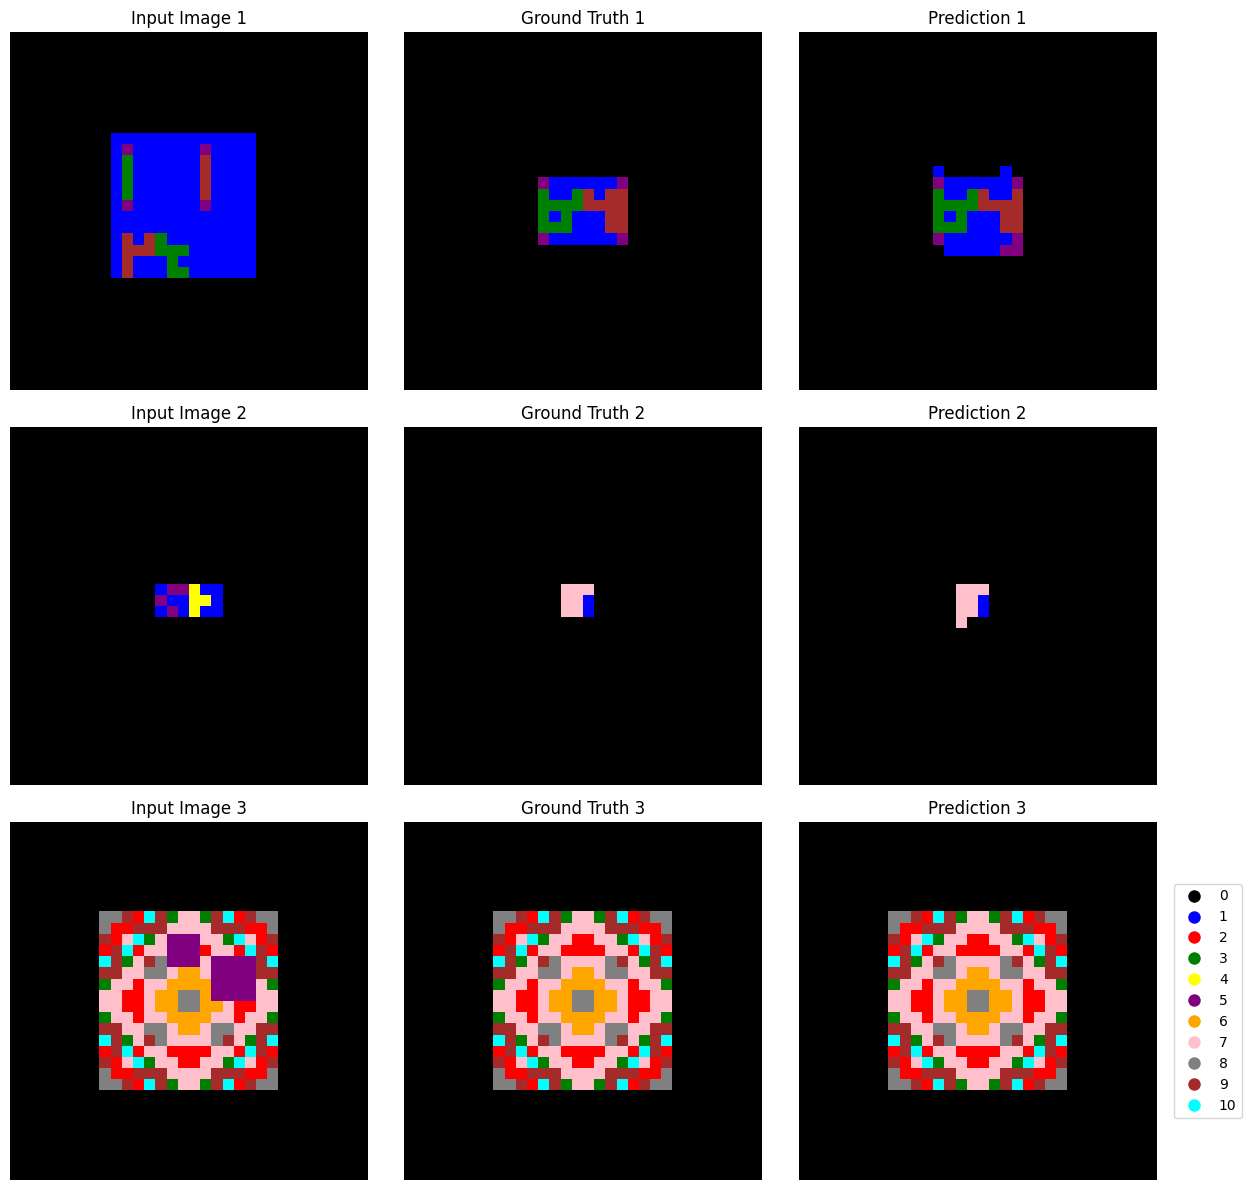

Test Average Loss: 5.893845 | Test Sample Accuracy: 0.0804% | Test Pixel Accuracy: 90.16%


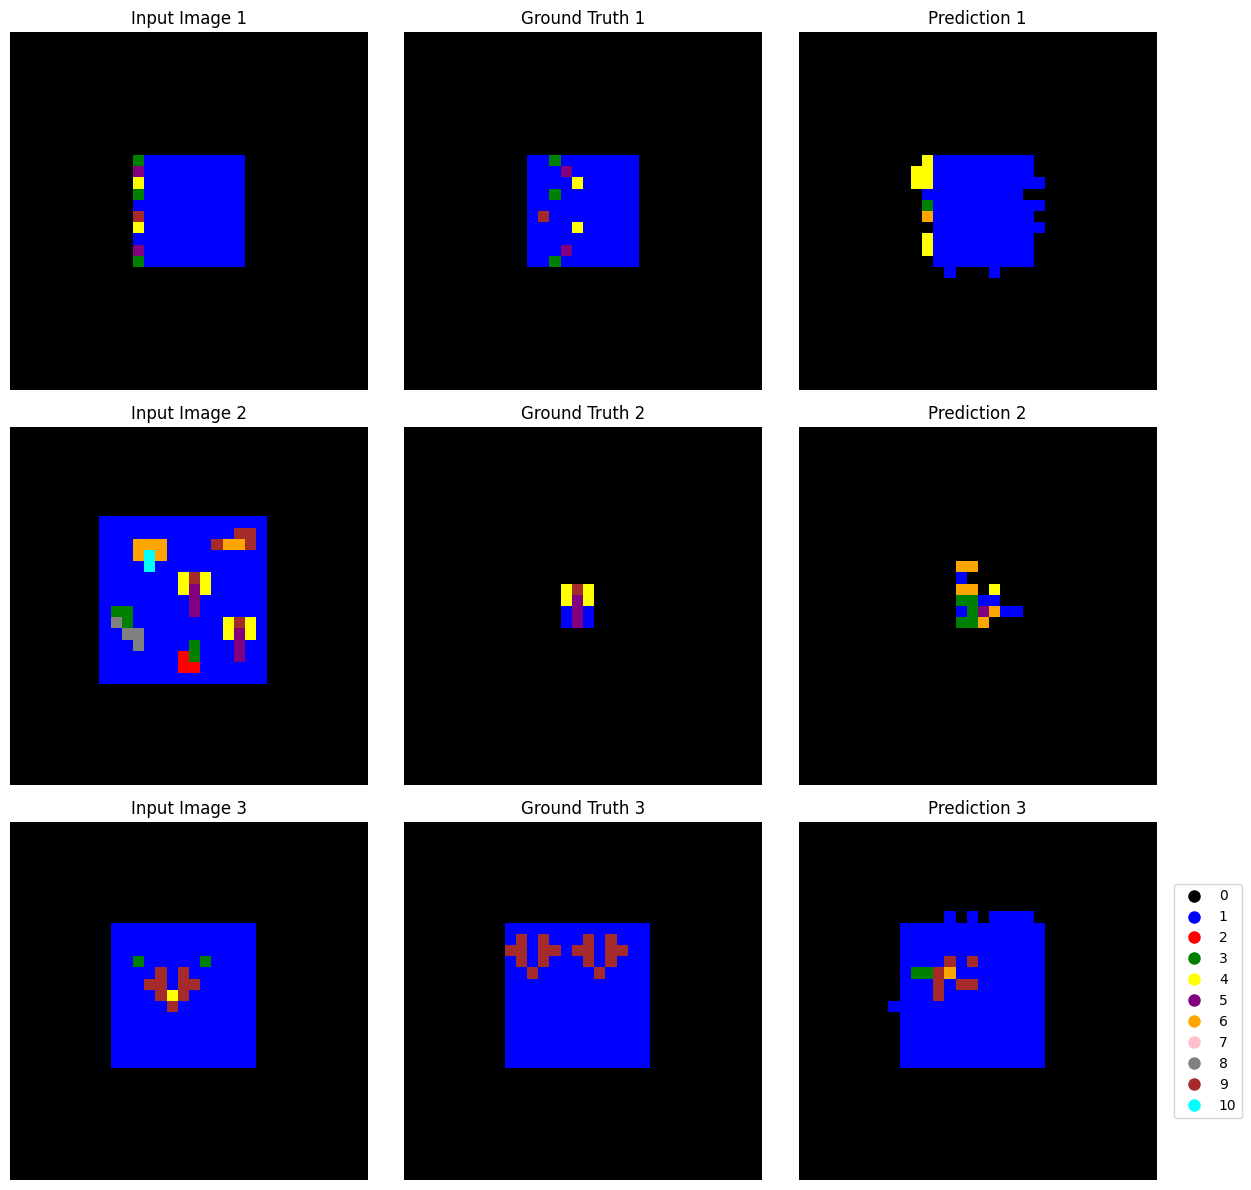

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▁▁▂▂▃▃▄▄▅▅▅▅▆▅▄▅▅▆▆▆▆▆▆▅▆▆▆▆▆▆▇▇▆▆▇█▇▇▆▅
test_pixel_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▆▇▇██████▇██▇█▇████▇█▇███▇
test_sample_accuracy,▁▁▁▁▁▁▁▁███▁█▁▁▁██▁███▁▁█▁▁████████▁████
train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pixel_accuracy,▁▅▆▆▇▇▇▇▇█████▇█████████████████████████
train_sample_accuracy,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▃▄▄▄▄▅▃▄▄▃▅▃▄▆▃▇▂▇▃▇▅█▅
epoch,1000
test_loss,5.89385
test_pixel_accuracy,90.16262
test_sample_accuracy,0.08039


In [16]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import wandb

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

train_args = {
    'challenges': train_challenge,
    'solution': train_solution,
    'num_classes': 11,
    'batch_size': 64,
    'epochs': 1000,
    'learning_rate': 0.001,
}

model_args = {
    'dims': (16,32,64,128),
    'heads': 4,
    'ff_expansion': 4,
    'reduction_ratio': (4,2,2,2),
    'num_layers': (1,2,4,4),
    'channels': 11,
    'num_classes': 11,
    'kernel_stride_paddings': ((3, 1, 1),(3, 1, 1),(3, 2, 1),(3, 2, 1))
    }
# WandB 설정
wandb.init(project="arc-agi-training")

# train_args와 model_args를 config에 추가
wandb.config.update(train_args)
wandb.config.update(model_args)

best_test_accuracy = 0  # 최고 test 정확도를 기록할 변수

# 모델 저장 함수
def save_checkpoint(state, filename="best_model.pth"):
    torch.save(state, filename)
    
def criterion(y_pred, y):
    y = y.long().squeeze(1)
    weight = torch.ones(train_args['num_classes']).to(y.device)
    weight[0] = 0.008
    weight[1] = 0.8
    ce = F.cross_entropy(y_pred, y, weight=weight) 
    return ce


# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
print(f'Using {device} device')

# 데이터셋 및 데이터로더 생성
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=train_args['batch_size'], shuffle=True)

eval_dataset = ARC_Dataset(eval_challenge, eval_solution)
eval_loader = DataLoader(eval_dataset, batch_size=train_args['batch_size'], shuffle=False)

# 모델 정의
model = ARC_Net(**model_args).to(device)

# 옵티마이저 정의
optimizer = optim.AdamW(model.parameters(), lr=train_args['learning_rate'])

# train 함수 수정
def train(epoch):
    model.train()
    total_loss = 0
    total_correct_samples = 0
    total_samples = 0
    total_correct_pixels = 0
    total_pixels = 0

    last_task_inputs = None
    last_task_outputs = None
    last_output = None

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{train_args["epochs"]}', leave=False)

    for batch_idx, (task_inputs, task_outputs, ex_inputs, ex_outputs) in progress_bar:
        task_inputs = task_inputs.to(device, non_blocking=True)
        task_outputs = task_outputs.to(device, non_blocking=True)
        ex_inputs = ex_inputs.to(device, non_blocking=True)
        ex_outputs = ex_outputs.to(device, non_blocking=True)

        optimizer.zero_grad()
        output = model(task_inputs, ex_inputs, ex_outputs)

        # 손실 함수 계산
        loss = criterion(output, task_outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # 정확도 계산
        correct_samples, batch_total_samples, correct_pixels, batch_total_pixels = calculate_accuracy(output, task_outputs)
        total_correct_samples += correct_samples
        total_samples += batch_total_samples
        total_correct_pixels += correct_pixels
        total_pixels += batch_total_pixels

        # 마지막 배치의 데이터 저장 (clone 제거)
        last_task_inputs = task_inputs.detach()
        last_task_outputs = task_outputs.detach()
        last_output = output.detach()
        
        # 프로그레스 바 업데이트
        progress_bar.set_postfix(loss=f'{loss.item():.4f}')
    
    avg_sample_accuracy = 100. * float(total_correct_samples) / float(total_samples)
    avg_pixel_accuracy = 100. * float(total_correct_pixels) / float(total_pixels)
    avg_loss = total_loss / len(train_loader)

    # WandB 로그 기록
    wandb.log({
        "train_loss": avg_loss,
        "train_sample_accuracy": avg_sample_accuracy,
        "train_pixel_accuracy": avg_pixel_accuracy,
        "epoch": epoch+1
    })

    print(f'Epoch [{epoch+1}/{train_args["epochs"]}] Complete | Average Loss: {avg_loss:.6f} | Training Sample Accuracy: {avg_sample_accuracy:.4f}% | Training Pixel Accuracy: {avg_pixel_accuracy:.2f}%')

    if (epoch + 1) % 50 == 0:
        visualize_predictions(last_task_inputs, last_task_outputs, last_output, condition=True)

# test 함수 수정
def test(epoch):
    global best_test_accuracy
    model.eval()
    total_loss = 0
    total_correct_samples = 0
    total_samples = 0
    total_correct_pixels = 0
    total_pixels = 0

    last_task_inputs = None
    last_task_outputs = None
    last_output = None

    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader), desc='Testing', leave=False)

    with torch.no_grad():
        for batch_idx, (task_inputs, task_outputs, ex_inputs, ex_outputs) in progress_bar:
            task_inputs = task_inputs.to(device, non_blocking=True)
            task_outputs = task_outputs.to(device, non_blocking=True)
            ex_inputs = ex_inputs.to(device, non_blocking=True)
            ex_outputs = ex_outputs.to(device, non_blocking=True)

            output = model(task_inputs, ex_inputs, ex_outputs)

            # 손실 함수 계산
            loss = criterion(output, task_outputs)
            total_loss += loss.item()

            # 정확도 계산
            correct_samples, batch_total_samples, correct_pixels, batch_total_pixels = calculate_accuracy(output, task_outputs)
            total_correct_samples += correct_samples
            total_samples += batch_total_samples
            total_correct_pixels += correct_pixels
            total_pixels += batch_total_pixels

            # 마지막 배치의 데이터 저장 (clone 제거)
            last_task_inputs = task_inputs.detach()
            last_task_outputs = task_outputs.detach()
            last_output = output.detach()
            
            # 프로그레스 바 업데이트
            progress_bar.set_postfix(loss=f'{loss.item():.4f}')
    
    avg_sample_accuracy = 100. * float(total_correct_samples) / float(total_samples)
    avg_pixel_accuracy = 100. * float(total_correct_pixels) / float(total_pixels)
    avg_loss = total_loss / len(eval_loader)

    # WandB 로그 기록
    wandb.log({
        "test_loss": avg_loss,
        "test_sample_accuracy": avg_sample_accuracy,
        "test_pixel_accuracy": avg_pixel_accuracy,
        "epoch": epoch+1
    })

    print(f'Test Average Loss: {avg_loss:.6f} | Test Sample Accuracy: {avg_sample_accuracy:.4f}% | Test Pixel Accuracy: {avg_pixel_accuracy:.2f}%')

    # 최고 성능 모델 저장
    if avg_sample_accuracy > best_test_accuracy:
        print(f"New best model found! Saving model with accuracy {avg_sample_accuracy:.4f}%")
        best_test_accuracy = avg_sample_accuracy
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_test_accuracy': best_test_accuracy,
            'optimizer': optimizer.state_dict(),
        }, filename="best_model.pth")

    if (epoch + 1) % 50 == 0:
        visualize_predictions(last_task_inputs, last_task_outputs, last_output, condition=True)

# 학습 실행
for epoch in range(train_args['epochs']):  
    train(epoch)
    test(epoch)

# WandB 종료
wandb.finish()